# make_grid:
## Make high res grid, choose either GEBCO_v2023 or bedmachine v3
### Version id:
### bedmachine v3



In [3]:

run ='wilk'
vers='10km_v1'
plotting = False

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import xarray as xr
import scipy.io as sio
from scipy.interpolate import griddata
import datetime
import cmocean
# import h5py
import bathy_smoother
# import pyresample


import socket
comp_name = socket.gethostname()
if comp_name=='SEES-3PV4VV3':
    print('running locally')
else:
    os.chdir('/g/data/jk72/deg581/wilkes-setup/notebooks')

#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
# from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.smoothing_Laplacian_rx0 import smoothing_Laplacian_rx0
from ext.tools.uvp_masks import uvp_masks



out_path = os.path.join(data_dir,'proc',run+'_'+vers+'_grd.nc')


# define coordinate transforms
## convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# load my functions for calculating rx0,rx1 and adjusting the grid
# from ext.tools.calc_z import calc_z as calc_z_old
from functions import GridStiffness
from functions.GridAdjustments import adjustWCT,adjustMask,smoothRegion,minWCTRegion

# Set model vertical coordinate settings

# N=31
# Vtransform=2
# Vstretching=4
# theta_s=1
# theta_b=4
# Tcline=250
# hc=Tcline # if Vtransform==2, hc=Tcline


N=31
Vtransform=2
Vstretching=4
theta_s=0.8
theta_b=3
Tcline=50
hc=Tcline # if Vtransform==2, hc=Tcline


running locally



In [4]:
mr = 10
grid_xLims= (800,1600) #km
grid_yLims= (-2400,-1800) #km
#establish the grid with grid point distances of mr/2 in km
#we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
#we need an extra line of u and v points at first to calculate all dx and dy on rho points
x,y = np.meshgrid(np.arange(grid_xLims[0],grid_xLims[1]+mr/2,mr/2),np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2))
x_rho = x[1::2,1::2]
y_rho = y[1::2,1::2]

print('x_rho size is: ',x_rho.shape)

x_rho size is:  (60, 80)


In [5]:
GeoGrid=False
if GeoGrid:
    print('making grid points with geographic coordinates')
    res = 1/40
    xc = (94.5,105)
    yc = (-66.8,-63)
    
    Lats = np.arange(yc[0],yc[1]+res/2,res/2)
    Lons = np.arange(xc[0],xc[1]+res/2,res/2)
    
    lat,lon = np.meshgrid(Lats,Lons)
    
    lonr_to_x,latr_to_y = ll_to_ps.transform(lat,lon)
    
    x_rho = lonr_to_x/1000
    y_rho = latr_to_y/1000
    
    print('x_rho size is (note possibly divide by 2): ',x_rho.shape)
    print('x_rho min/max: ',x_rho.min(),' ',x_rho.max())
    print('y_rho min/max: ',y_rho.min(),' ',y_rho.max())
    dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
    dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])

    print('min dx/dy: ',dx.min(),' ',dy.min())


quick plot of extents


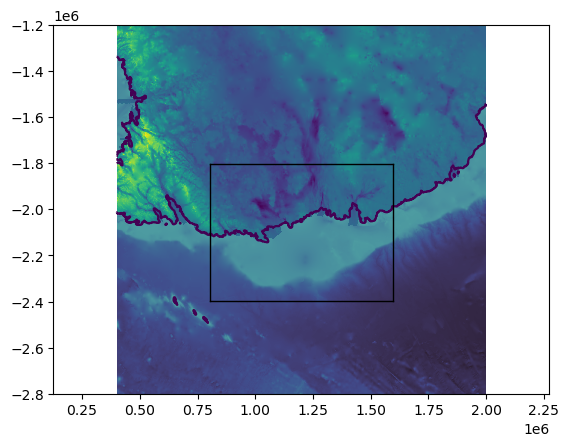

In [6]:
#load BM3 geometry
bedmachine_v3_path = os.path.join(data_dir,'raw','BedMachineAntarctica-v3','BedMachineAntarctica-v3.nc')

bm3_raw = xr.load_dataset(bedmachine_v3_path)

#subset bedmachine dataset
bm3=bm3_raw.sel(x=slice(.4e6,2e6)).sel(y=slice(-1.2e6,-2.8e6)) # note reversed y coord

# make XX and YY coordinates
X,Y = np.meshgrid(bm3.x,bm3.y)
bm3 = bm3.assign_coords({"X": (("y", "x"), X), "Y": (("y", "x"), Y)})

bm3_lat,bm3_lon = ps_to_ll.transform(bm3.X,bm3.Y)
bm3 = bm3.assign_coords({"lon": (("y", "x"), bm3_lon), "lat": (("y", "x"), bm3_lat)})

# make 'draft' abd 'bathy' variables
bm3["draft"]=-(bm3.thickness-bm3.surface) #draft is negative
bm3["bathy"]=-bm3.bed # bathy is postive



geom = bm3
# make masks
geom['mask_full']=bm3.mask
geom["mask_ice"]=np.isfinite(geom.mask_full.where(geom.mask_full==3,np.NaN))
geom["mask_ocean"]=np.isfinite(geom.mask_full.where((geom.mask_full==0)|(geom.mask_full==3),np.NaN))

#%matplotlib widget
%matplotlib inline
print('quick plot of extents')
plt.close('all')
masked_ice = geom.draft.where(geom.draft!=0,np.NaN).copy()
plt.pcolormesh(geom.X,geom.Y,geom.bathy,cmap='cmo.deep')
plt.pcolormesh(geom.X,geom.Y,masked_ice)

plt.contour(geom.X,geom.Y,geom.draft+geom.bathy,levels=0)
# plt.plot(x_rho*1000,y_rho*1000,'ko',markersize=1,alpha=0.02,mec=None)
plt.plot(x_rho[0,:]*1000,y_rho[0,:]*1000,'k',linewidth=1)
plt.plot(x_rho[-1,:]*1000,y_rho[-1,:]*1000,'k',linewidth=1)
plt.plot(x_rho[:,0]*1000,y_rho[:,0]*1000,'k',linewidth=1)
plt.plot(x_rho[:,-1]*1000,y_rho[:,-1]*1000,'k',linewidth=1)
plt.axis('equal')
plt.show()


<Figure size 640x480 with 0 Axes>

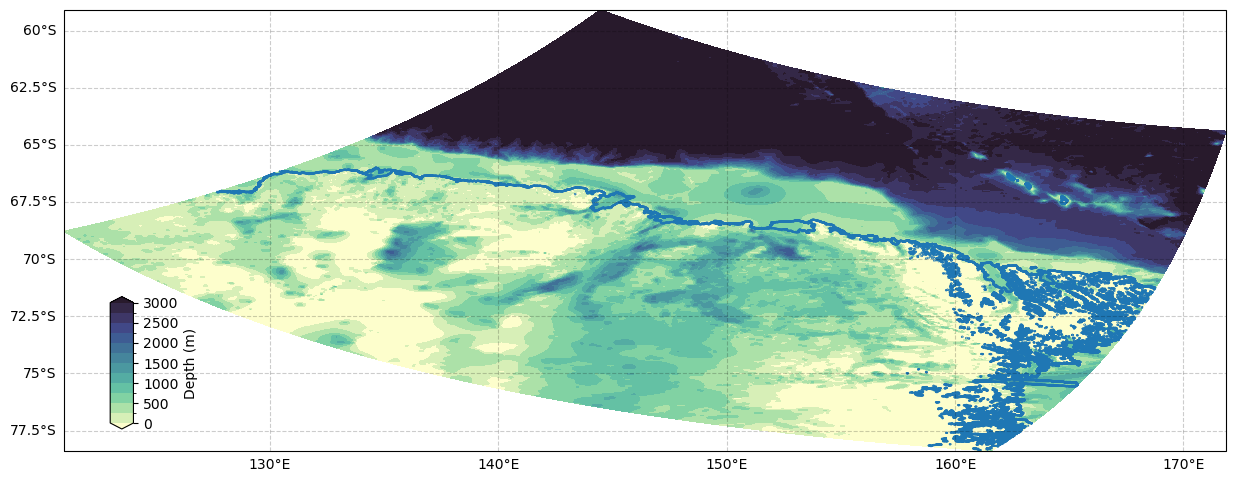

In [7]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.set_extent([64, 80, -75, -62])

#add data
im = (geom['bathy']).plot.contourf(x='lon',y='lat',cmap='cmo.deep',levels=np.array([*np.arange(00,3250,250)]),add_colorbar=False)
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


<Figure size 640x480 with 0 Axes>

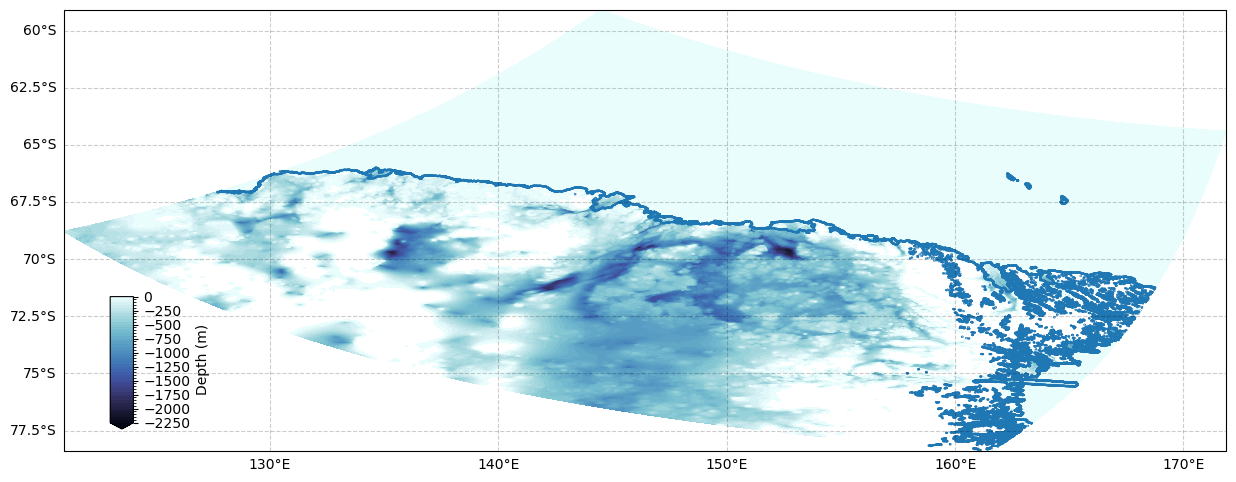

In [8]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.set_extent([64, 80, -75, -62])

#add data
im = (geom.draft).plot.contourf(x='lon',y='lat',cmap='cmo.ice',levels=np.array([*np.arange(-2250,50,50)]),add_colorbar=False,extend='min')
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


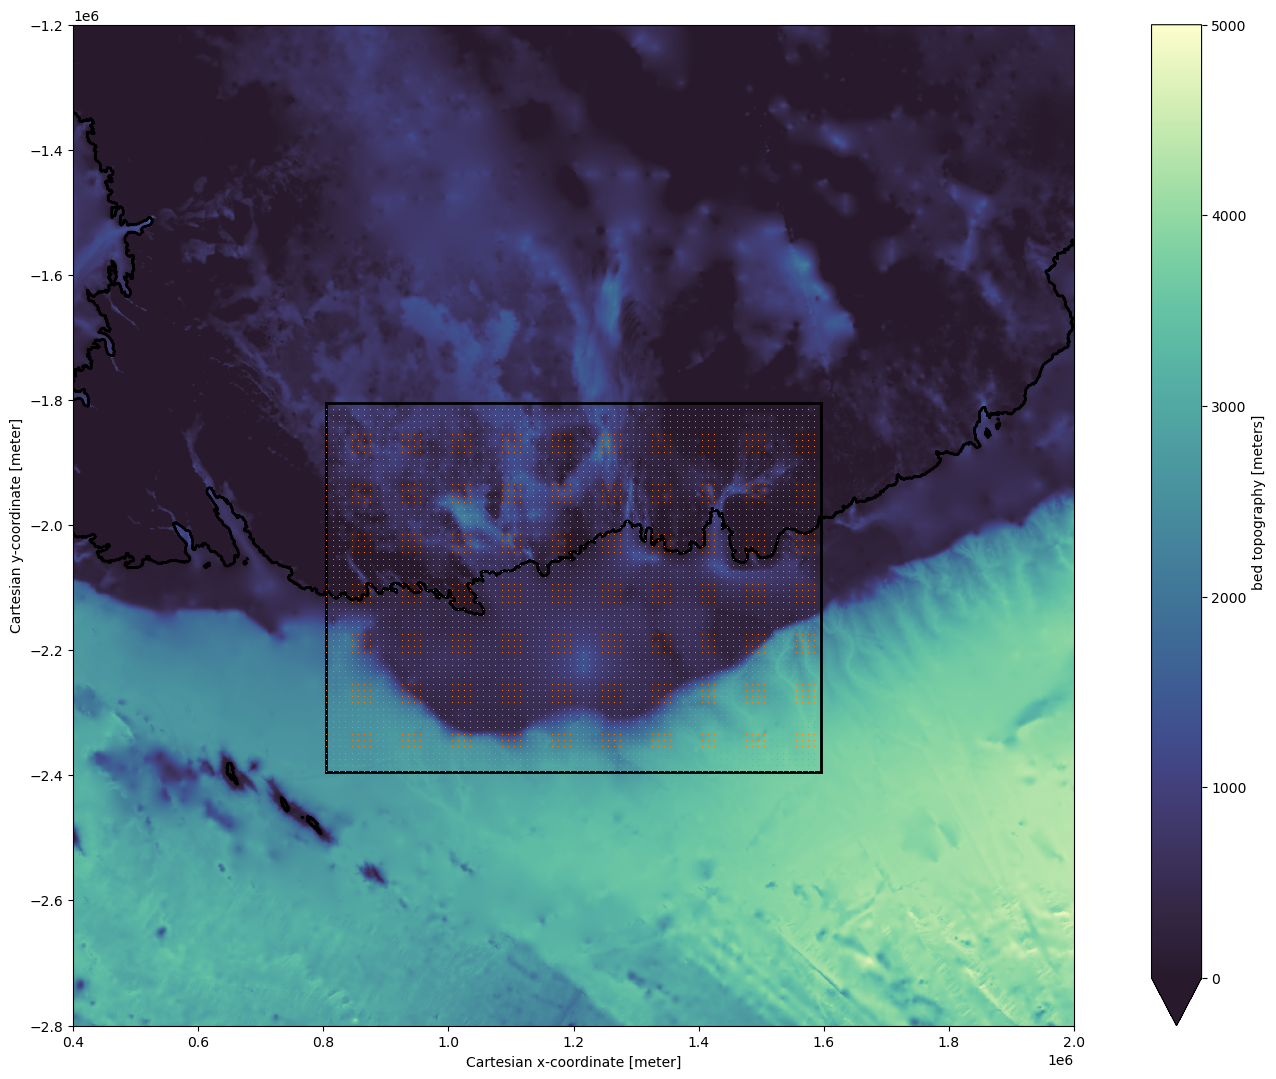

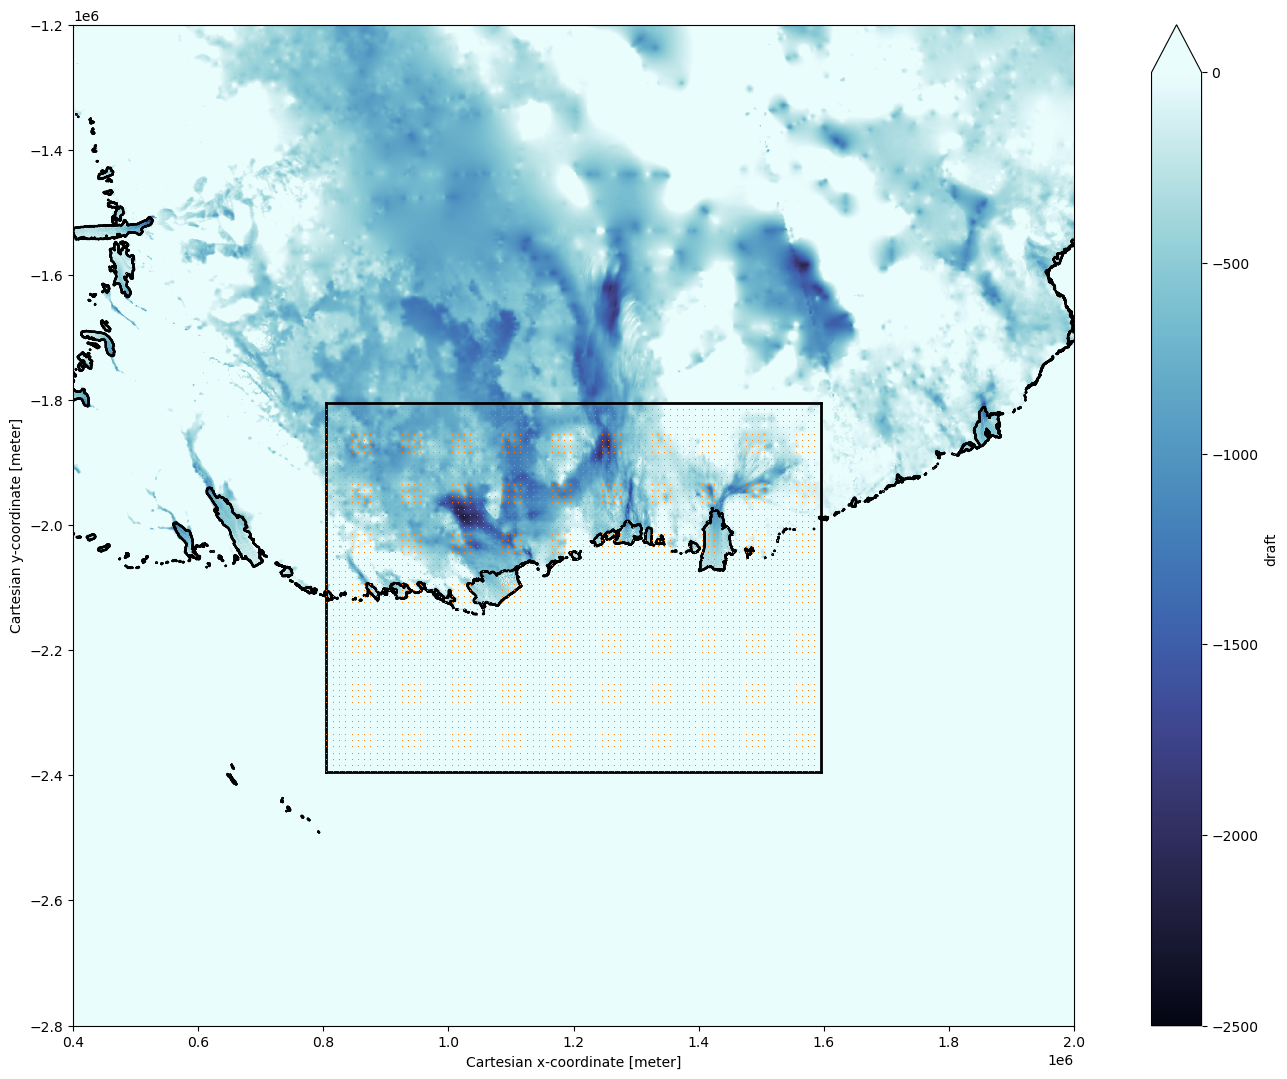

In [9]:
# plot of chosen subset
plot_res=1
fig,ax=plt.subplots(figsize=(20,13))
geom.bathy.plot(vmin=000,vmax=5000,cmap='cmo.deep_r')
geom.mask_ocean.plot.contour(colors='k')
ax.plot(x_rho[0,:]*1000,y_rho[0,:]*1000,'k',linewidth=2)
ax.plot(x_rho[-1,:]*1000,y_rho[-1,:]*1000,'k',linewidth=2)
ax.plot(x_rho[:,0]*1000,y_rho[:,0]*1000,'k',linewidth=2)
ax.plot(x_rho[:,-1]*1000,y_rho[:,-1]*1000,'k',linewidth=2)
ax.plot(x_rho[0:-1:plot_res,0:-1:plot_res]*1000,y_rho[0:-1:plot_res,0:-1:plot_res]*1000,linestyle='',color='C1',marker=',',markersize=0.1)
ax.plot(x_rho[0:-1:plot_res,0:-1:plot_res].T*1000,y_rho[0:-1:plot_res,0:-1:plot_res].T*1000,linestyle='',color='C1',marker=',',markersize=0.1)
ax.set_aspect('equal','box')

plt.show()
fig,ax=plt.subplots(figsize=(20,13))
geom.draft.plot(vmin=-2500,vmax=0,cmap='cmo.ice')
geom.mask_ice.plot.contour(colors='k')
ax.plot(x_rho[0,:]*1000,y_rho[0,:]*1000,'k',linewidth=2)
ax.plot(x_rho[-1,:]*1000,y_rho[-1,:]*1000,'k',linewidth=2)
ax.plot(x_rho[:,0]*1000,y_rho[:,0]*1000,'k',linewidth=2)
ax.plot(x_rho[:,-1]*1000,y_rho[:,-1]*1000,'k',linewidth=2)
ax.plot(x_rho[0:-1:plot_res,0:-1:plot_res]*1000,y_rho[0:-1:plot_res,0:-1:plot_res]*1000,linestyle='',color='C1',marker=',',markersize=0.1)
ax.plot(x_rho[0:-1:plot_res,0:-1:plot_res].T*1000,y_rho[0:-1:plot_res,0:-1:plot_res].T*1000,linestyle='',color='C1',marker=',',markersize=0.1)
ax.set_aspect('equal','box')


In [10]:
#load south polar stereographic projection to convert from grid point distance in m to lat/lon and back

#get lat/lon coordinates at all grid points by shifting the grid to the lower left corner of the map
lat,lon = inverse_polar_stereo(x,y,0,0,-71.0)

#calculate curvilinear coordinate distances at rho points
dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])


#calculate curvilinear coordinate metrices
pm = 1.0/dx
pn = 1.0/dy
 
dndx = np.empty_like(pm)
dmde = np.empty_like(pn)

dndx[:,1:-1] = 0.5*(pn[:,2:] - pn[:,:-2])
dmde[1:-1,:] = 0.5*(pm[2:,:] - pm[:-2,:])

dndx[:,0]  = 2*dndx[:,1]  - dndx[:,2]
dndx[:,-1] = 2*dndx[:,-2] - dndx[:,-3]
dmde[0,:]  = 2*dmde[1,:]  - dmde[2,:]
dmde[-1,:] = 2*dmde[-2,:] - dmde[-3,:]

#subset lat and lon at rho, psi, u and v points
lon_rho = lon[1::2,1::2]
lat_rho = lat[1::2,1::2]

lon_psi = lon[2:-1:2,2:-1:2]
lat_psi = lat[2:-1:2,2:-1:2]

lon_u = lon[1::2,2:-1:2]
lat_u = lat[1::2,2:-1:2]

lon_v = lon[2:-1:2,1::2]
lat_v = lat[2:-1:2,1::2]

In [11]:
# convert the final rho,psi,u,v points to x,y grid

x_rho,y_rho = ll_to_ps.transform(lat_rho,lon_rho)
x_psi,y_psi = ll_to_ps.transform(lat_psi,lon_psi)
x_u,y_u = ll_to_ps.transform(lat_u,lon_u)
x_v,y_v = ll_to_ps.transform(lat_v,lon_v)




In [12]:
lat_s = geom.lat.values.flatten()
lon_s = geom.lon.values.flatten()

In [13]:
# interpolate from the geometry grid to the new roms grid

from scipy.interpolate import griddata

def grid_data(data):
    return griddata((lon_s,lat_s),data,(lon_rho,lat_rho),'nearest')

roms_tmp = {}
for key in ['bathy','draft','mask_ice','mask_ocean']:
    roms_tmp[key] = grid_data(geom[key].values.flatten())
    print('interpolated',key)

interpolated bathy
interpolated draft
interpolated mask_ice
interpolated mask_ocean


In [14]:
if plotting:
    plt.close()
    for key,data in roms_tmp.items():
        fig,ax = plt.subplots(figsize=(15,10))
        if key=='draft':
            plot = ax.pcolormesh(data)        
        else:
            plot = ax.pcolormesh(data)
        ax.set_title(key)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('equal')
        plt.show()

  
Minimum r-value =  0.0
Maximum r-value =  0.9957850575447083
Mean    r-value =  0.05520479739008482
Median  r-value =  0.014431044459342957


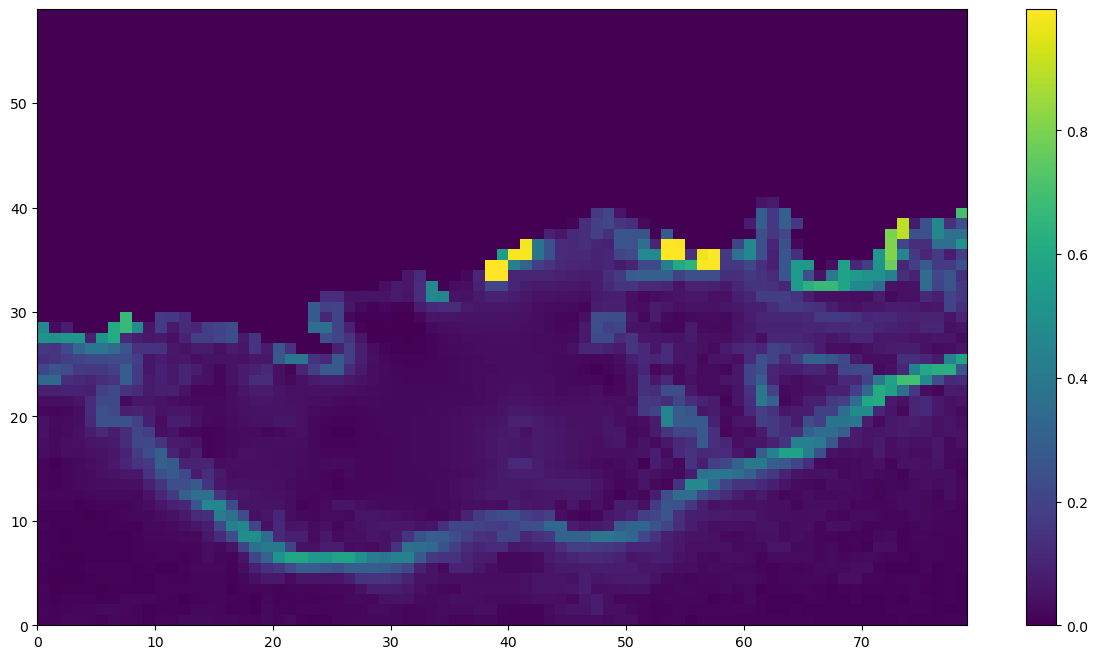

  
Minimum r-value =  nan
Maximum r-value =  nan
Mean    r-value =  nan
Median  r-value =  nan


/home/woden/Documents/wilkes-setup/src/functions/GridStiffness.py:141: RuntimeWarning: divide by zero encountered in divide
  zx[k,:] = abs((z_w[k,1:,:] - z_w[k,:-1,:] + z_w[k-1,1:,:] - z_w[k-1,:-1,:]) /
/home/woden/Documents/wilkes-setup/src/functions/GridStiffness.py:143: RuntimeWarning: divide by zero encountered in divide
  zy[k,:] = abs((z_w[k,:,1:] - z_w[k,:,:-1] + z_w[k-1,:,1:] - z_w[k-1,:,:-1]) /
/home/woden/Documents/wilkes-setup/src/functions/GridStiffness.py:145: RuntimeWarning: invalid value encountered in multiply
  zx[k,:] = zx[k,:] * umask
/home/woden/Documents/wilkes-setup/src/functions/GridStiffness.py:146: RuntimeWarning: invalid value encountered in multiply
  zy[k,:] = zy[k,:] * vmask


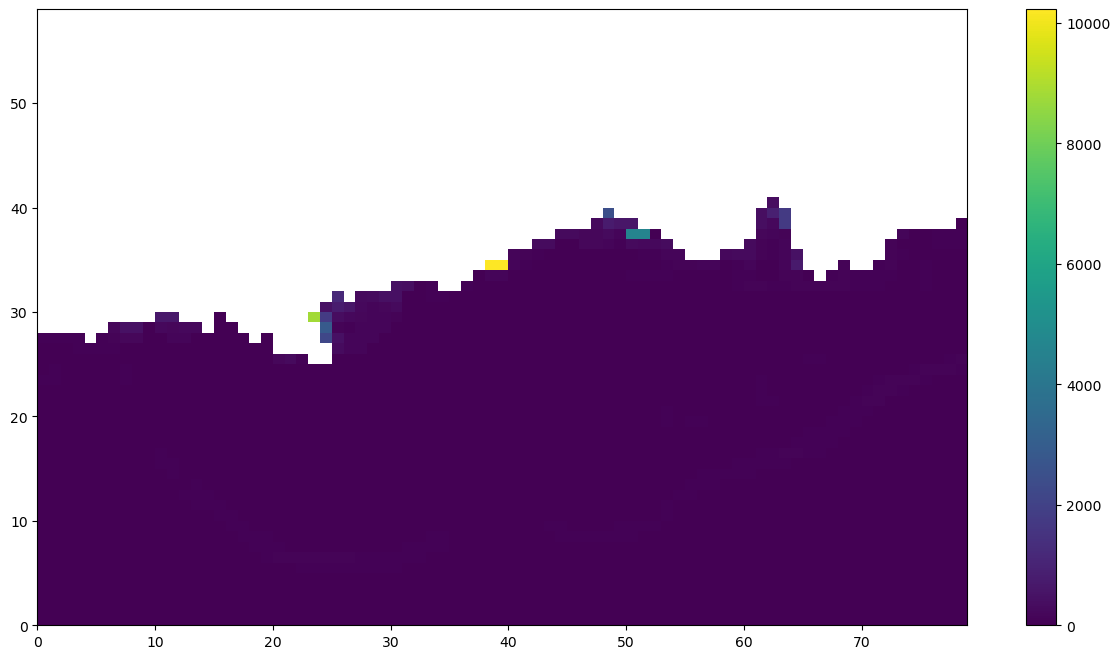

In [15]:


z_rho_pre,z_w_pre,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bathy'],roms_tmp['draft'])


fig = plt.figure(figsize=(15,8))
grd_rx0_pre=GridStiffness.rx0(roms_tmp['bathy'],roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx0_pre)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(15,8))
grd_rx1_pre=GridStiffness.rx1(z_w_pre,roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx1_pre)
plt.colorbar()
plt.show()

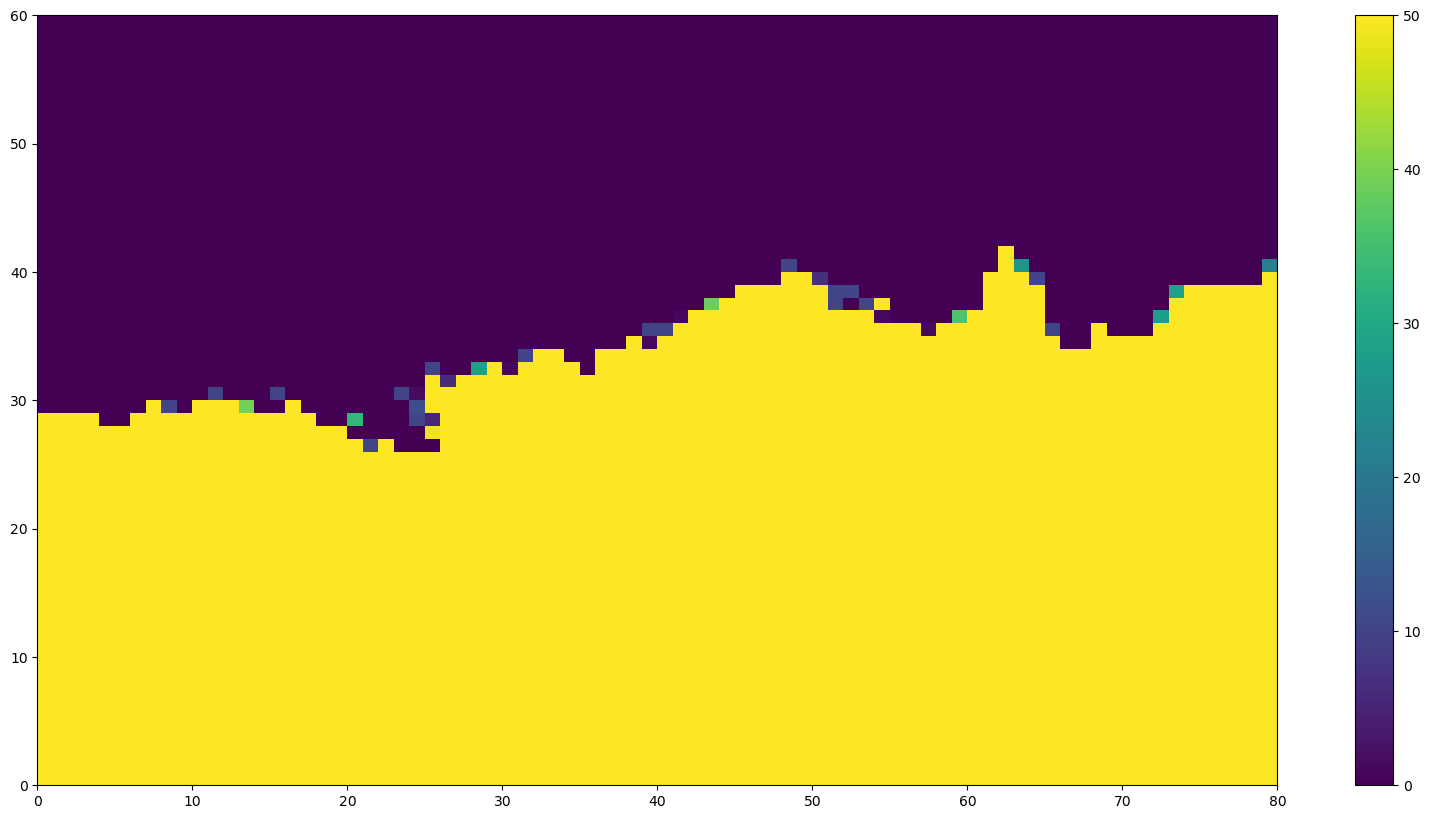

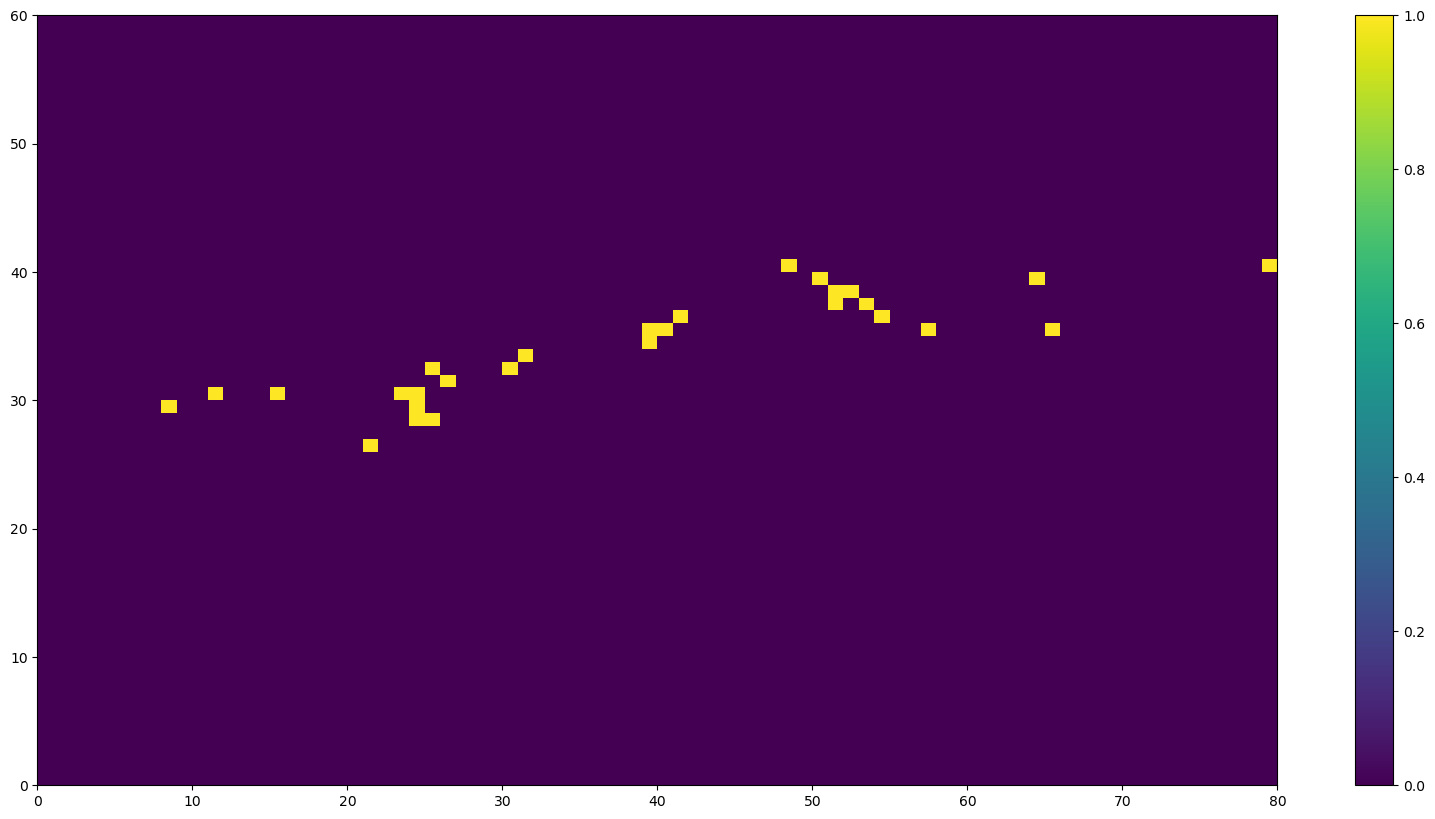

In [16]:
# First need to check for any badly masked points - before any smoothing happens
Thresh = 25

%matplotlib inline
fig = plt.figure(figsize=(20,10))
thin_WCT = (roms_tmp['bathy']+roms_tmp['draft'])*roms_tmp['mask_ocean']
plt.pcolormesh(thin_WCT,vmin=0,vmax=50)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
thin_WCT_mask = (thin_WCT<Thresh) & (roms_tmp['mask_ocean']==1)
plt.pcolormesh(thin_WCT_mask)
plt.colorbar()


In [17]:
# # fix a missing blob of ice that wreaks havoc later on!

# %matplotlib inline
# plt.figure(figsize=(15,15))
# plt.pcolormesh(roms_tmp['draft'],vmin=-10,vmax=0)
# plt.colorbar()

# # roms_tmp['draft_orig'] = roms_tmp['draft'].copy()

# # roms_tmp['draft'][28:37,37:40] = roms_tmp['draft'][37,40]


# plt.figure(figsize=(15,15))
# plt.pcolormesh(roms_tmp['draft'],vmin=-10,vmax=0)
# plt.colorbar()


In [18]:
# do checks
print('min/max zice is',roms_tmp['draft'].min(),'/',roms_tmp['draft'].max())
print('min/max h is',roms_tmp['bathy'].min(),'/',roms_tmp['bathy'].max())
print('min/max wct is',(roms_tmp['draft']+roms_tmp['bathy']).min(),'/',(roms_tmp['draft']+roms_tmp['bathy']).max())

min/max zice is -2207.2122 / 1269.7273
min/max h is -1269.7273 / 3790.2278
min/max wct is 0.0 / 3790.2278


First round of smoothing
make masks
remove mountains etc
deepen bed until it is at least min_depth
begin smoothing
now, smooth bed
Iteration # 1
current r= 0.9957850575447083   nbPointMod= 214 
 
Iteration # 2
current r= 0.5096936948856842   nbPointMod= 139 
 
Iteration # 3
current r= 0.41894883062962374   nbPointMod= 72 
 
Iteration # 4
current r= 0.36615640580124575   nbPointMod= 44 
 
Iteration # 5
current r= 0.34228323342505085   nbPointMod= 35 
 
Iteration # 6
current r= 0.3282877247726791   nbPointMod= 20 
 
Iteration # 7
current r= 0.3215845138746703   nbPointMod= 8 
 
Iteration # 8
current r= 0.31805829874259267   nbPointMod= 2  no erase
 
Iteration # 9
current r= 0.3164530542783051   nbPointMod= 2  no erase
 
Iteration # 10
current r= 0.3154394948849247   nbPointMod= 8  no erase
 
Iteration # 11
current r= 0.3148023408021012   nbPointMod= 16 
 
Iteration # 12
current r= 0.2999624650687488   nbPointMod= 0  no erase
 
  
Minimum r-value =  0.0
Maximum r-value =  0.69923870986387

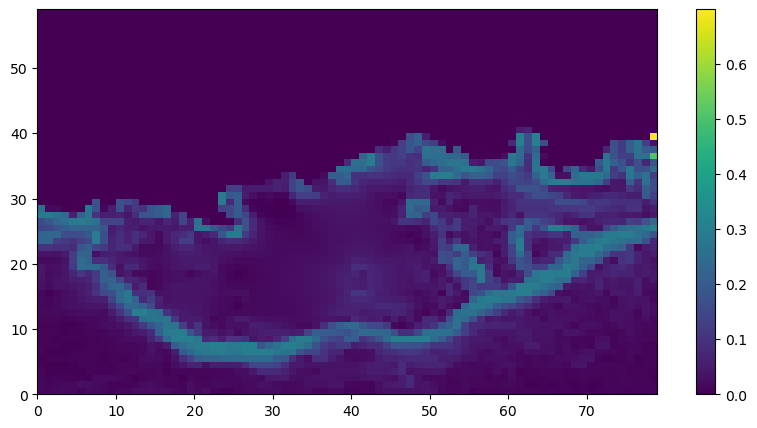

  
Minimum r-value =  0.0
Maximum r-value =  12978.901735422029
Mean    r-value =  27.535861267243362
Median  r-value =  2.411335864048203


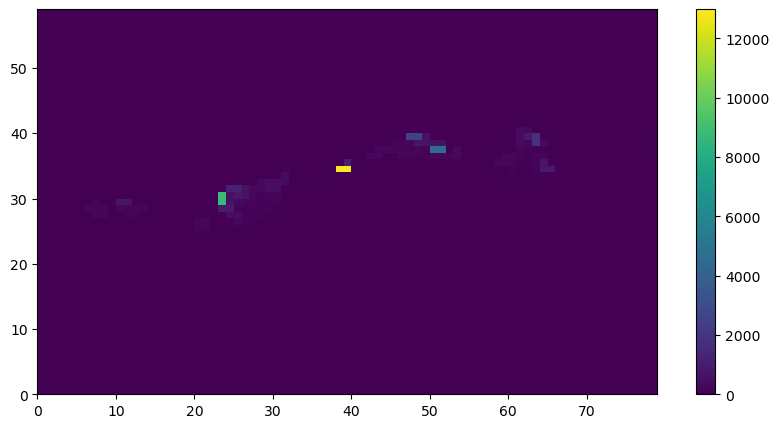

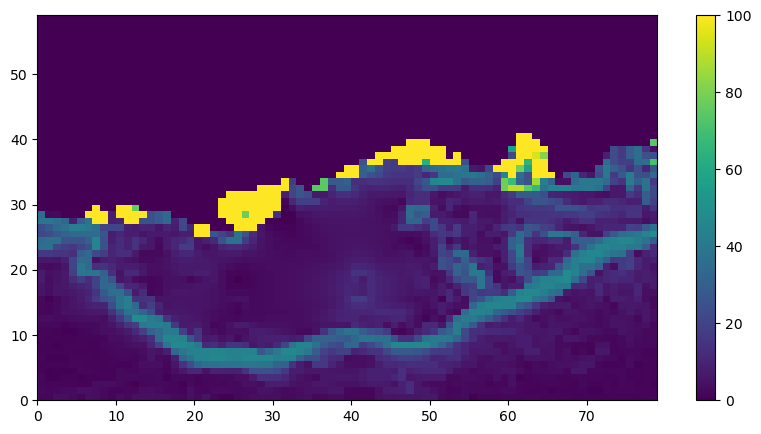

In [23]:
print('First round of smoothing')

print('make masks')
bed = roms_tmp['bathy']
bed_raw = roms_tmp['bathy']
ice = roms_tmp['draft']
mask = roms_tmp['mask_ocean']
maskNaN = mask.copy() # make a nan mask.
maskNaN = np.where(maskNaN==0,np.NaN,maskNaN)
mask_ice = ice.copy()
mask_ice[mask_ice<0]=1
mask_ice[mask_ice>=0]=0

# first, make any bedrock above MSL, and any ice above MSL to 0. (remove mountains)
print('remove mountains etc')
min_depth0=0.3
ice[ice>0] = 0
bed[bed < min_depth0] = min_depth0 #note that bathy cannot >=0

# for any locations where there is wct<min_depth0; deepen the ice a bit until it is at least min_depth0
print('deepen bed until it is at least min_depth')
wct = bed + ice
bed[wct<min_depth0] = bed[wct<min_depth0] + min_depth0  
wct = bed + ice

# plt.figure()
# plot_where=120
# plt.plot(-roms_tmp['bathy'][:,plot_where],color='C0',marker='.')
# plt.plot(roms_tmp['draft'][:,plot_where],color='C1',marker='.')
# # plt.plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# plt.plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# plt.plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # plt.plot(-1000*mask[:,plot_where],'.-')
# plt.axis((345,375,-2600,0))

# make ice mask
mask_ice = ice.copy()
mask_ice[mask_ice>=0]=0
mask_ice[mask_ice<0]=1
mask_ice = mask_ice*mask
mask_openocean = (mask_ice==0)*mask

# smooth the wct and bed, then deepen the ice to correct for smoothed wct/bed.
print('begin smoothing')
# GOOD VALUE --> rx0in = 0.06
rx0in = 0.06
max_iter = 50

Area = 1/(pm*pn)

# print('smooth wct')
# wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,wct,rx0in,Area,max_iter)
# print('now push bed down by new smoothed wct')
# bed = wct - ice

# print('smooth ice')
# rx0in = 0.09
# max_iter = 1
# ice, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,ice,rx0in,Area,max_iter)


print('now, smooth bed')
rx0in = 0.3
bed= smoothing_Laplacian_rx0(mask,bed,rx0in)




z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)

fig = plt.figure(figsize=(10,5))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
plt.pcolormesh(grd_rx1_mid,vmin=0,vmax=100)
plt.colorbar()
plt.show()


In [121]:
# # plt.figure(figsize=(10,7.5))
# # plt.pcolormesh(ice-ice_o,vmin=-20,vmax=20)
# # plt.colorbar()
# # plt.figure(figsize=(10,7.5))
# # plt.pcolormesh(mask_ice)
# # plt.colorbar()
# # plt.figure(figsize=(10,7.5))
# # plt.pcolormesh(mask_ice*(ice-ice_o),vmin=-100,vmax=100)
# # plt.colorbar()
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh(mask_ice)
# plt.colorbar()
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh((mask_ice==0)*mask)
# plt.colorbar()

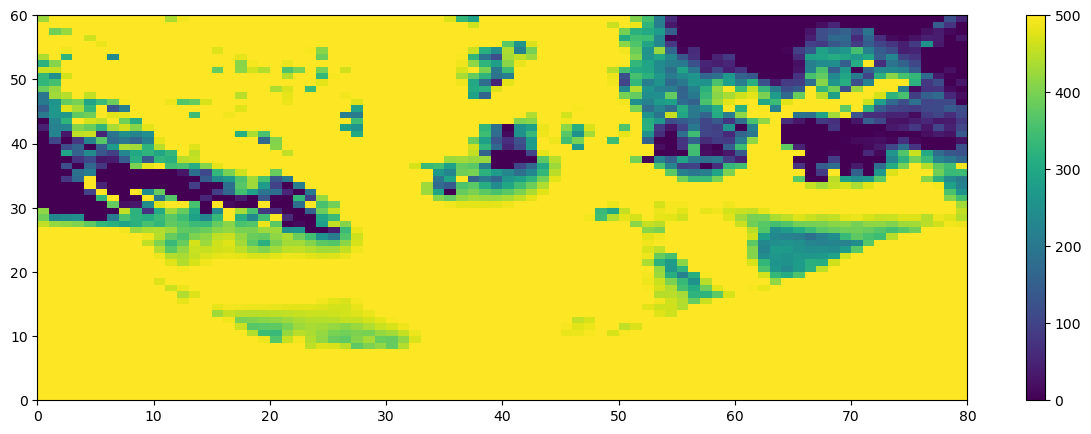

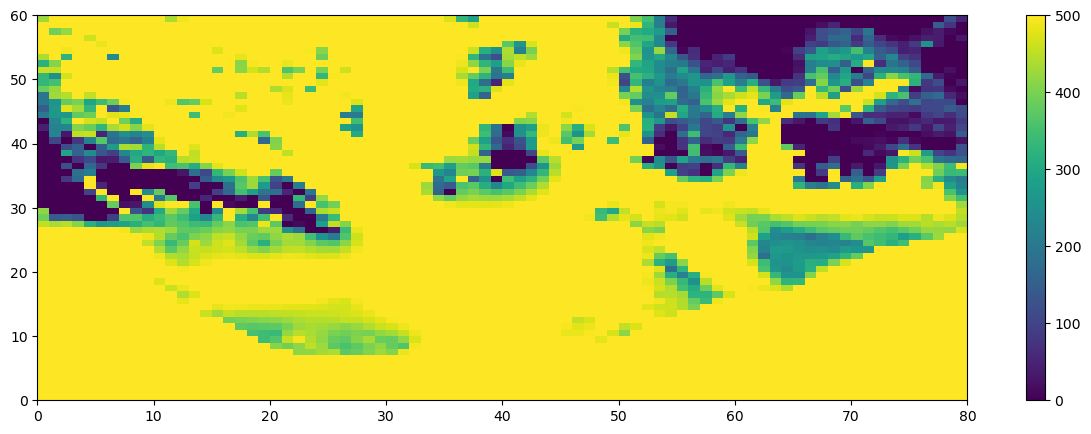

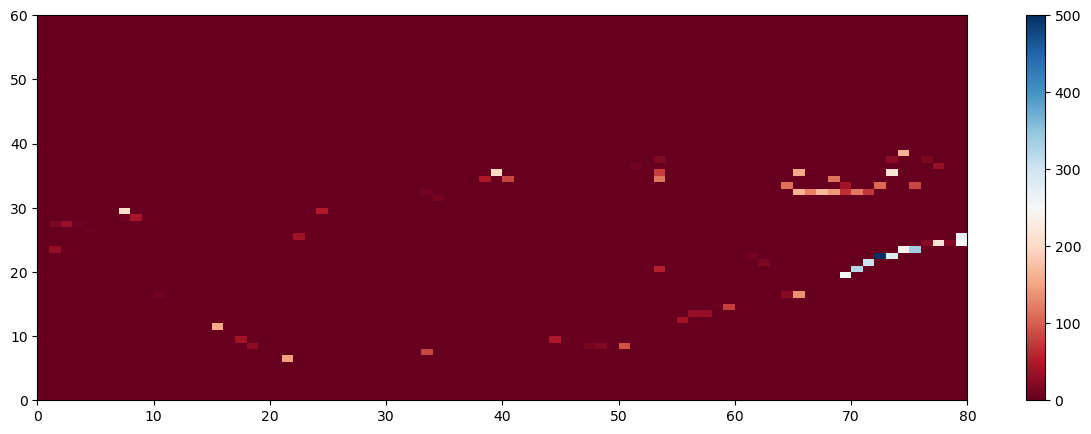

In [24]:
plt.figure(figsize=(15,5))
plt.pcolormesh(bed,vmin=00,vmax=500)
plt.colorbar()
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['bathy'],vmin=00,vmax=500)
plt.colorbar()
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['bathy']-bed,vmin=00,vmax=500,cmap='RdBu')
plt.colorbar()

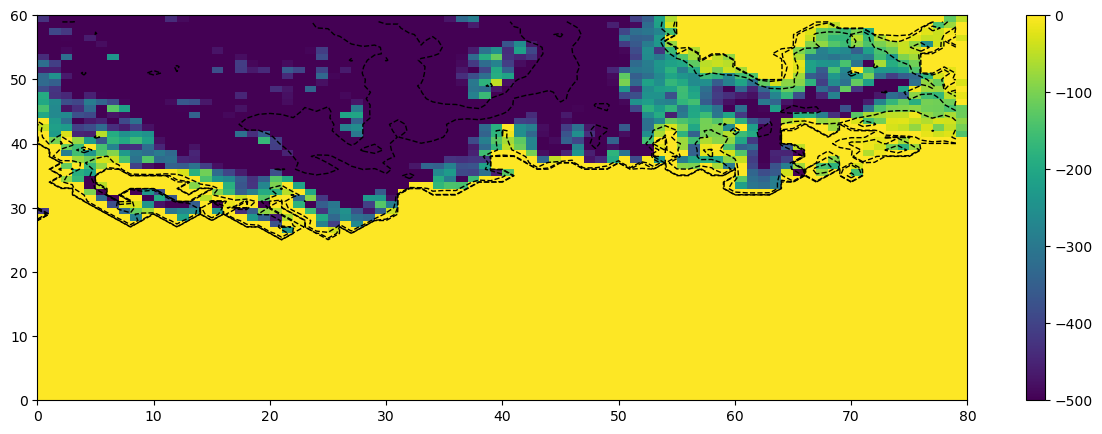

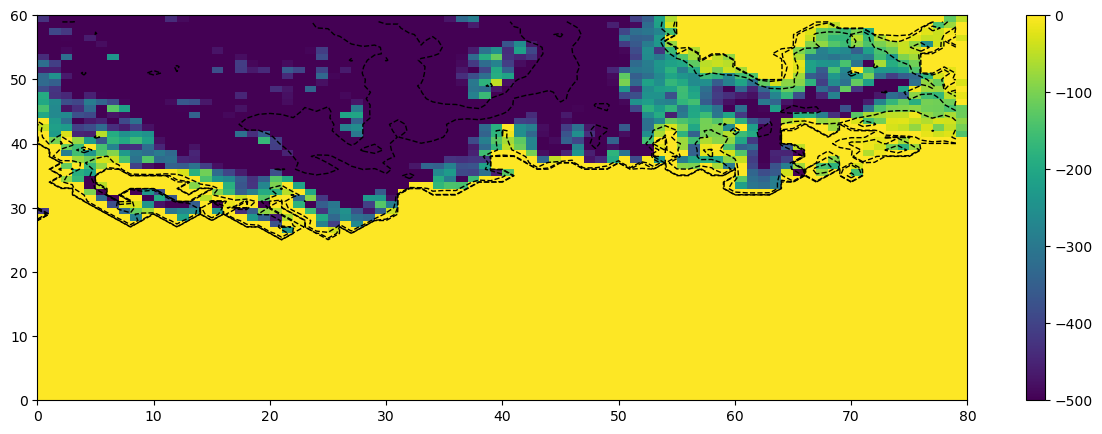

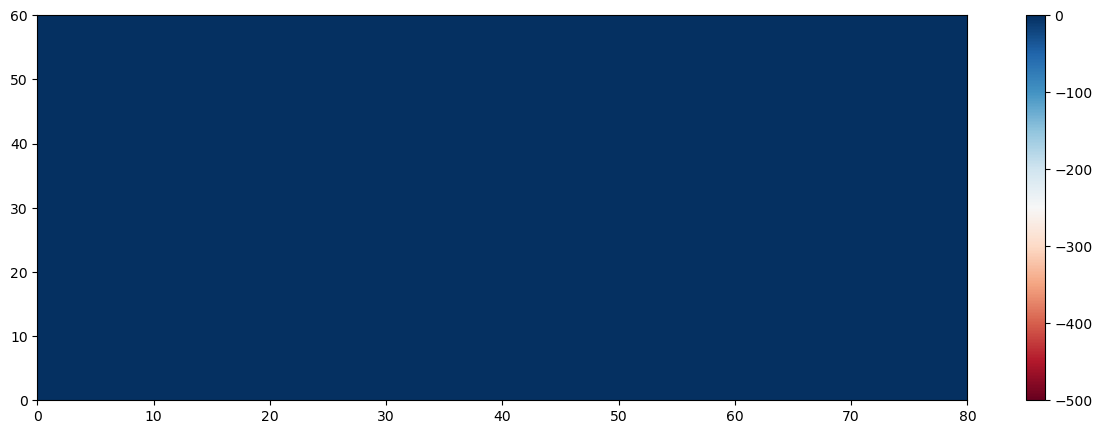

In [25]:
plt.figure(figsize=(15,5))
plt.pcolormesh(ice,vmin=-500,vmax=0)
plt.colorbar()
plt.contour(ice,levels=(-1000,-100,-10,-1,0),colors='k',linewidths=1)
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['draft'],vmin=-500,vmax=0)
plt.colorbar()
plt.contour(roms_tmp['draft'],levels=(-1000,-100,-10,-1,0),colors='k',linewidths=1)
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['draft']-ice,vmin=-500,vmax=0,cmap='RdBu')
plt.colorbar()

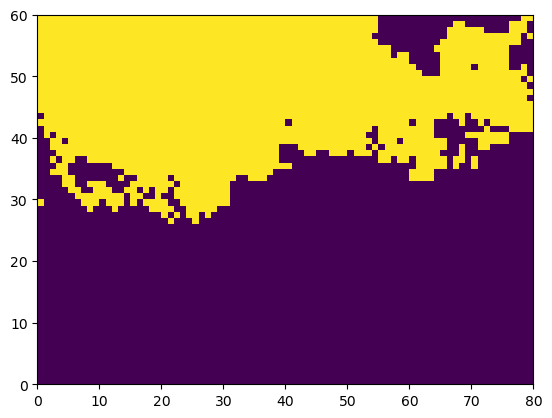

In [26]:
%matplotlib inline
plt.pcolormesh(ice<0)
plt.show()

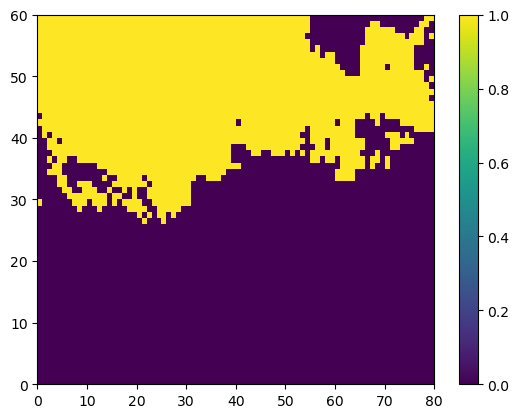

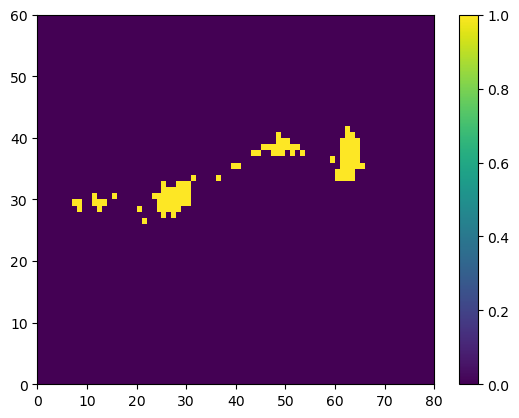

In [27]:
x=slice(37,41)
e=slice(28,38)
#mask new ice by old ice boundaries
mask_newice_10m = ice<-10
# ice = ice*mask_ice
ice = ice*mask_newice_10m
# plt.pcolormesh(mask_newice_1m)
plt.close('all')
plt.figure()
plt.pcolormesh(ice<-10)
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(mask_ice)
plt.colorbar()
plt.show()

In [28]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

whole domain
min/max zice is -2207.2122 / 0.0
min/max h is 0.30000001192092896 / 3790.227783203125
min/max wct is 0.3 / 3790.2278
ocean cells
min/max zice is -1356.8079833984375 / -0.0
min/max h is 21.67595672607422 / 3790.227783203125
min/max wct is 1.0 / 3790.227783203125


In [127]:
# where ever the wct<min_depth, deepen the 

min_depth = 50.0
ii = ((bed + ice) < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth
wct=bed+ice


In [128]:
# plt.figure(figsize=(15,7))
# plt.pcolormesh(ice-ice_o,vmin=-20,vmax=20,cmap='RdBu_r')
# plt.colorbar()

In [129]:
# do checks
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

min/max zice is -1631.7772 / -0.0
min/max h is 0.3 / 3222.336
min/max wct is 0.2999878 / 3222.336
ocean cells
min/max zice is -1202.32763671875 / -0.0
min/max h is 61.10673522949219 / 3222.3359375
min/max wct is 49.999969482421875 / 3222.3359375


In [130]:

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=270
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((340,420,-1500,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((340,420,-1500,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((340,420,-1500,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((340,420))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=98
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=205
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))



  
Minimum r-value =  0.0
Maximum r-value =  0.4696131944656372
Mean    r-value =  0.02157599919784305
Median  r-value =  0.01595542300492525


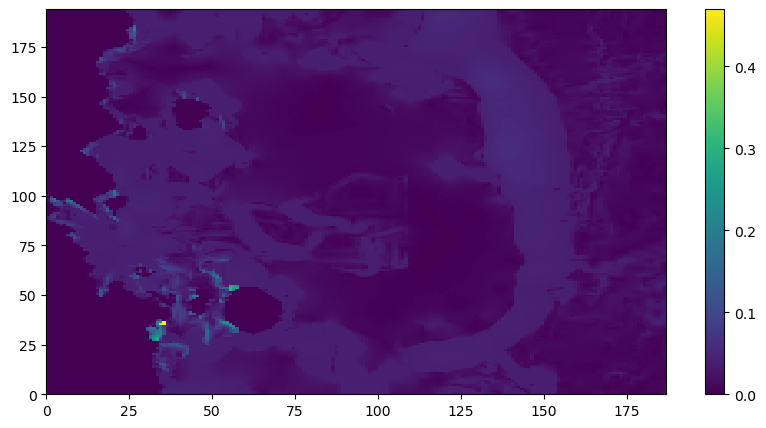

  
Minimum r-value =  0.0
Maximum r-value =  893.5776548230878
Mean    r-value =  11.424446015605122
Median  r-value =  3.3645500953696823


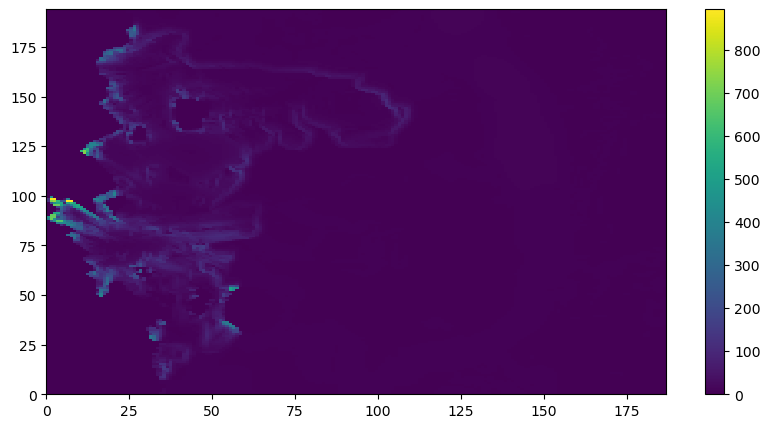

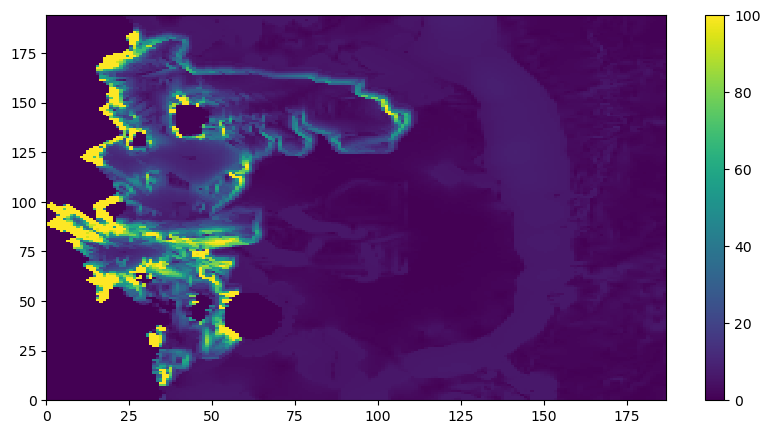

In [131]:


z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)

fig = plt.figure(figsize=(10,5))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
plt.pcolormesh(grd_rx1_mid,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [132]:
print('deepen bedrock in shallow open ocean and thin cavity')
min_depth_open_ocean = 100.0
min_depth_under_ice = 280.0


# if input('to continue (Y)?')=='Y':
ii = ((bed + ice) < min_depth_open_ocean) & (mask == 1) & (ice == 0) #set the minimum open ocean water column thickness
bed[ii] = -ice[ii] + min_depth_open_ocean
wct=bed+ice

ii = ((bed + ice) < min_depth_under_ice) & (mask == 1) & (ice < 0) #set the minimum wct beneath ice shelf
bed[ii] = -ice[ii] + min_depth_under_ice
wct=bed+ice


deepen bedrock in shallow open ocean and thin cavity


  
Minimum r-value =  0.0
Maximum r-value =  0.45924484729766846
Mean    r-value =  0.021065074553119224
Median  r-value =  0.014615256804972887
  
Minimum r-value =  0.0
Maximum r-value =  235.1216255339715
Mean    r-value =  5.993696343044689
Median  r-value =  2.982870507561465


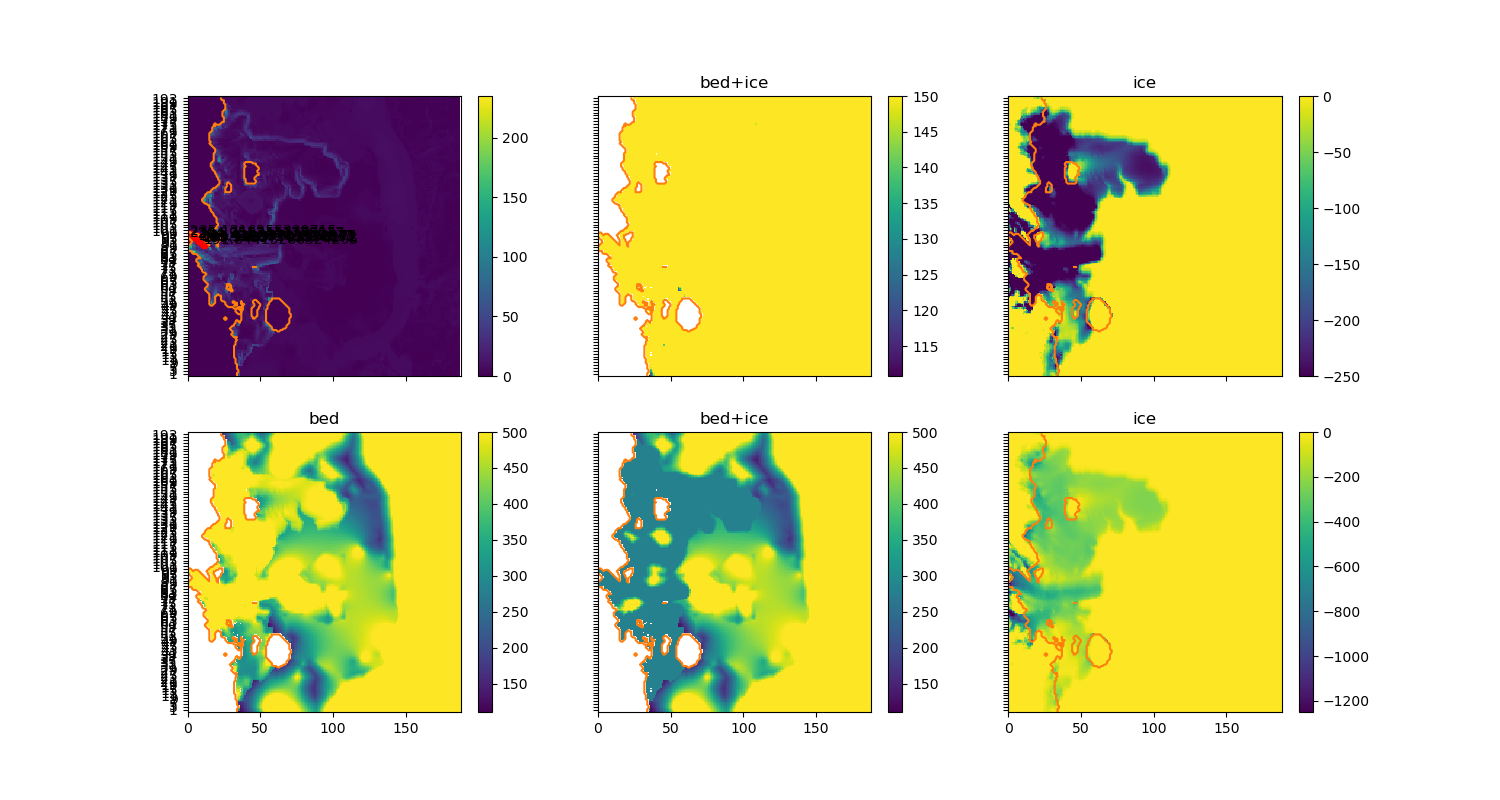

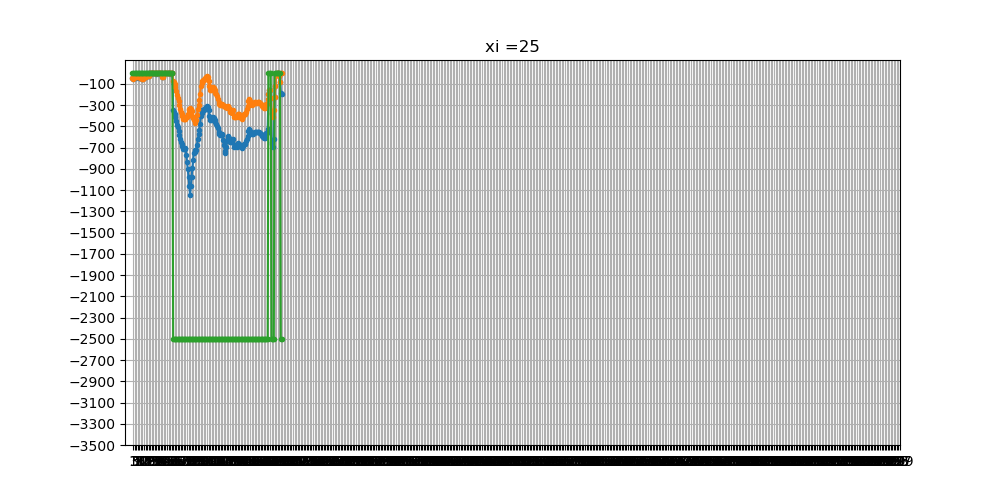

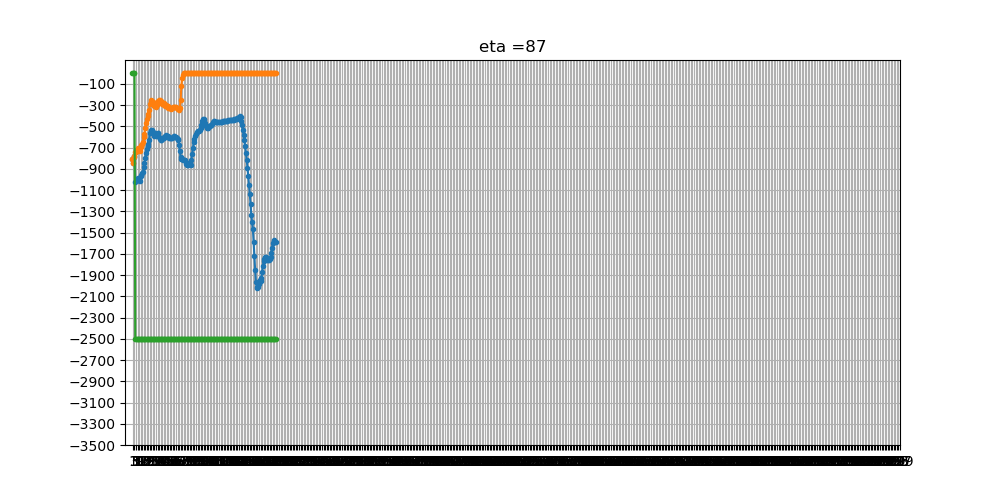

In [133]:

import matplotlib.pyplot as plt
%matplotlib widget

z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)
grd_rx0_post=GridStiffness.rx0(bed,mask)
grd_rx1_post=GridStiffness.rx1(z_w_post,mask)

plt.close('all')


fig,axs = plt.subplots(ncols=3,nrows=2,figsize=(15,8),sharex=True,sharey=True)
im=axs[0,0].pcolormesh(grd_rx1_post)
rx1_flat = grd_rx1_post.ravel()
ind = np.argpartition(rx1_flat,-10)[-10:]
ind
for where in ind: 
    w_j,w_i=np.unravel_index(where,grd_rx1_post.shape)
    axs[0,0].plot(w_i,w_j,'ro')
    axs[0,0].text(w_i,w_j,rx1_flat[where])
axs[0,0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0,0])
axs[0,0].contour(mask,levels=((0,1)),colors='C1')
im=axs[0,1].pcolormesh((bed+ice)*maskNaN,vmax=150)
axs[0,1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0,1])
axs[0,1].contour(mask,levels=((0,1)),colors='C1')
axs[0,1].set_title('bed+ice')
im=axs[0,2].pcolormesh(ice,vmin=-250)
axs[0,2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0,2])
axs[0,2].contour(mask,levels=((0,1)),colors='C1')
axs[0,2].set_title('ice')
im=axs[1,0].pcolormesh(bed*maskNaN,vmax=500)
axs[1,0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1,0])
axs[1,0].contour(mask,levels=((0,1)),colors='C1')
axs[1,0].set_title('bed')
im=axs[1,1].pcolormesh((bed+ice)*maskNaN,vmax=500)
axs[1,1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1,1])
axs[1,1].contour(mask,levels=((0,1)),colors='C1')
axs[1,1].set_title('bed+ice')
im=axs[1,2].pcolormesh(ice,vmin=-1250)
axs[1,2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1,2])
axs[1,2].contour(mask,levels=((0,1)),colors='C1')
axs[1,2].set_title('ice')

# look along a single xi value
lookAtX=25
fig = plt.figure(figsize=(10,5))
plt.plot(-bed[:,lookAtX],'.-')
plt.plot(ice[:,lookAtX],'.-')
plt.plot(-1*mask[:,lookAtX]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('xi ='+str(lookAtX))
# plt.xlim(focusRange[2],focusRange[3])
plt.grid()

# look along a single eta value
lookAtE=87
fig = plt.figure(figsize=(10,5))
plt.plot(-bed[lookAtE,:],'.-')
plt.plot(ice[lookAtE,:],'.-')
plt.plot(-1*mask[lookAtE,:]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('eta ='+str(lookAtE))
plt.grid()



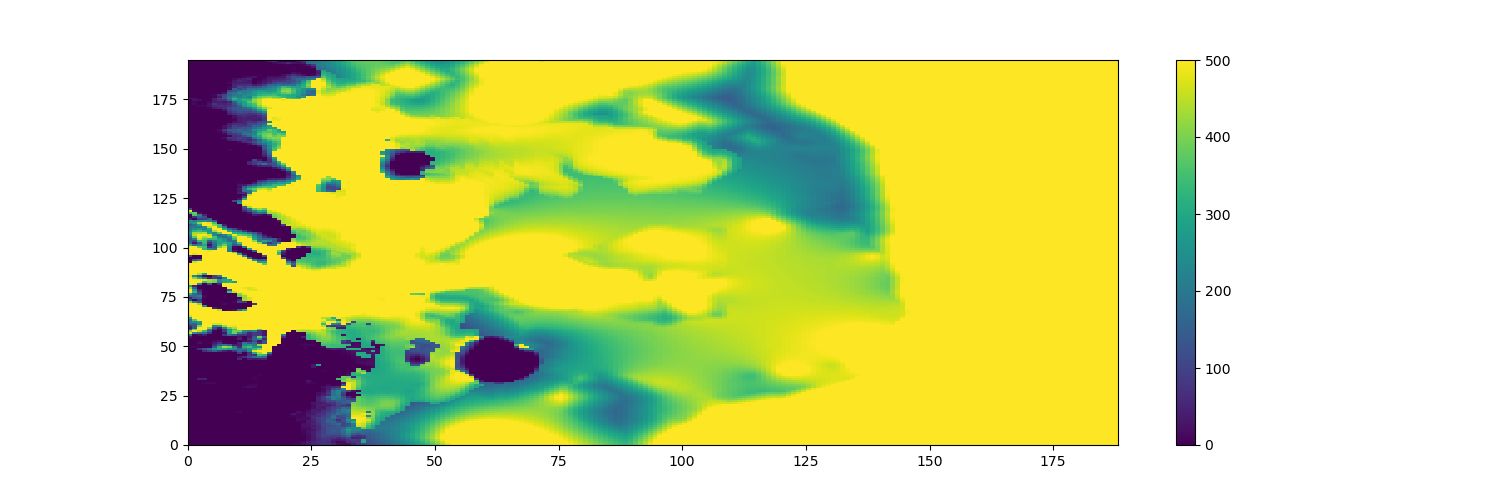

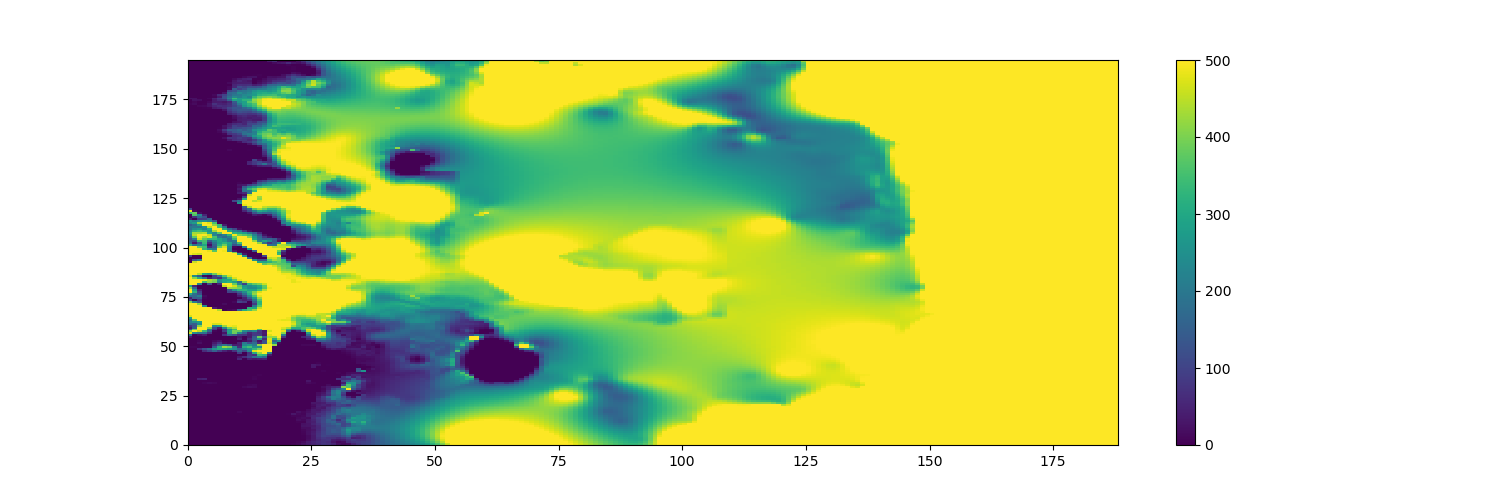

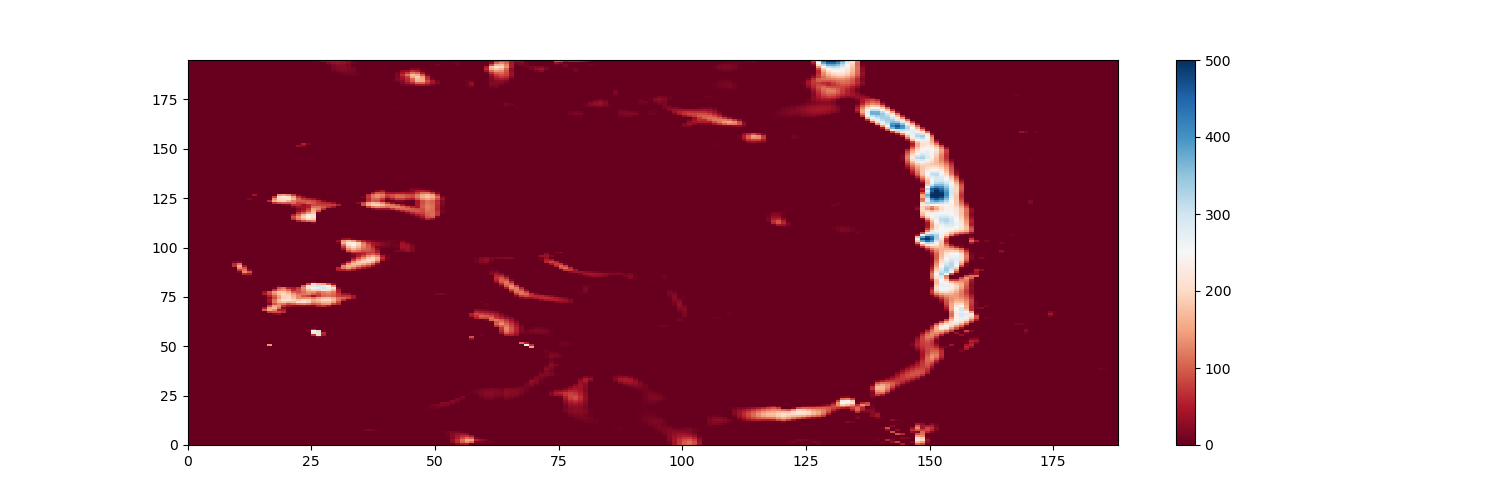

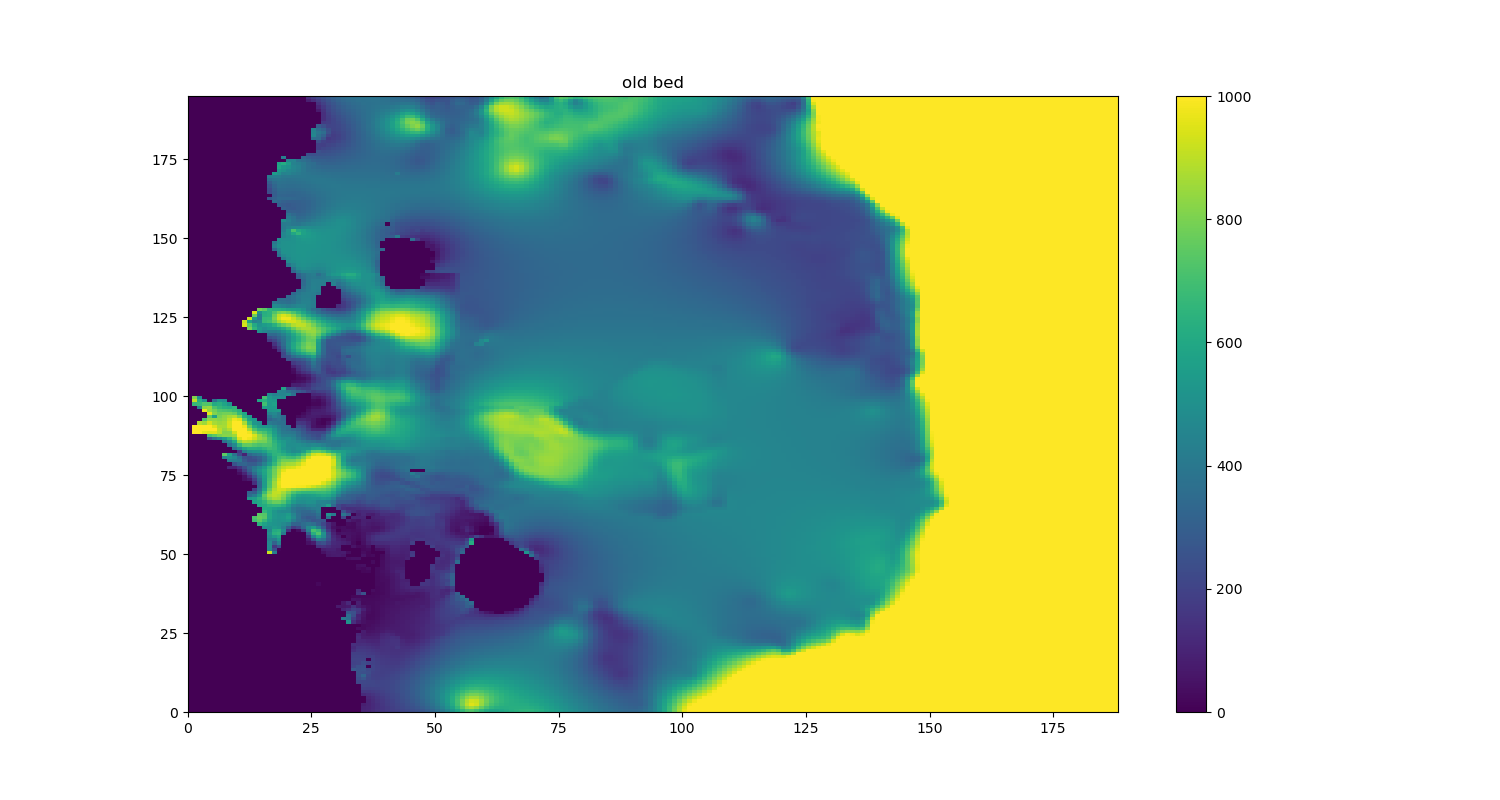

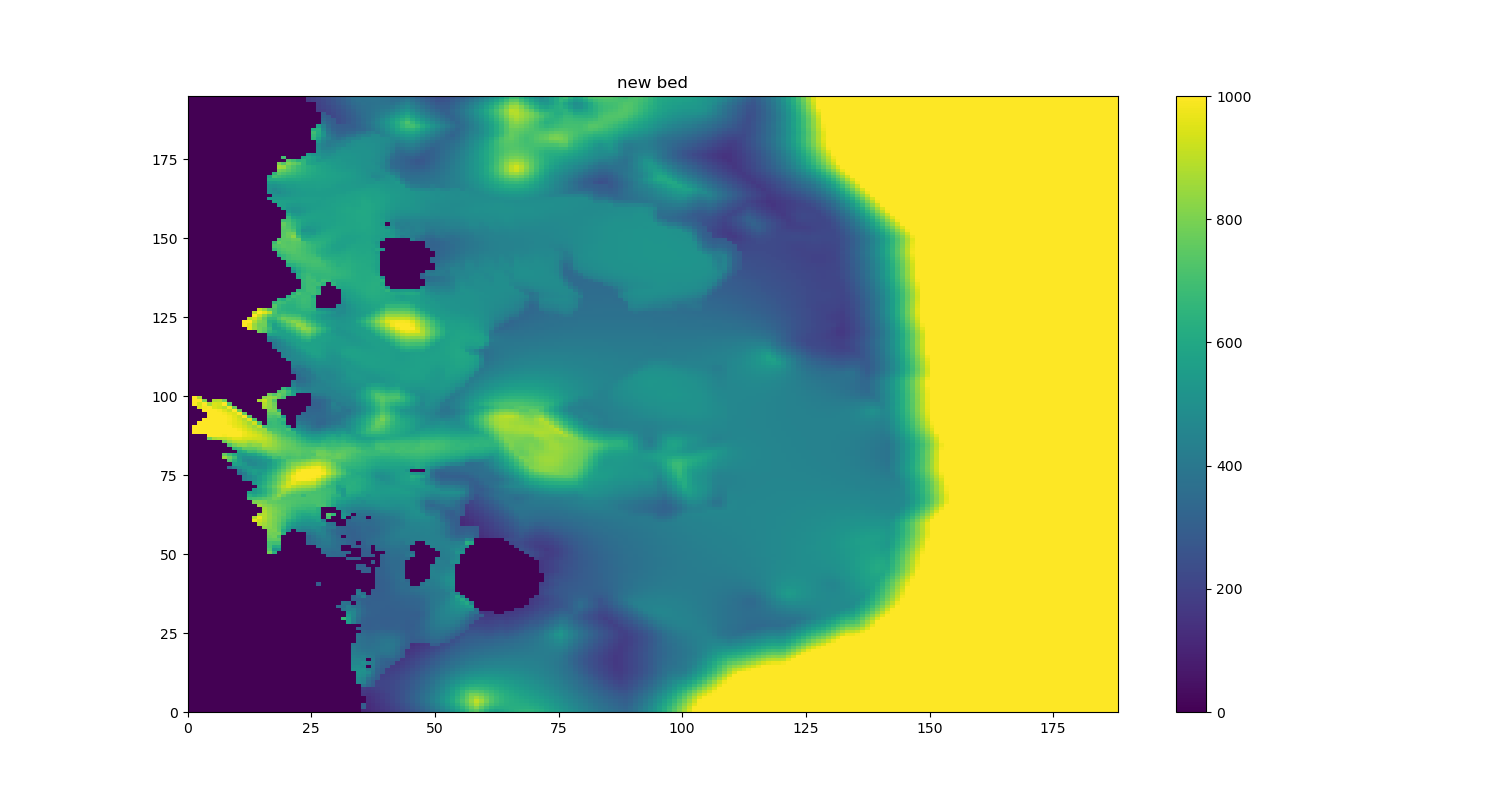

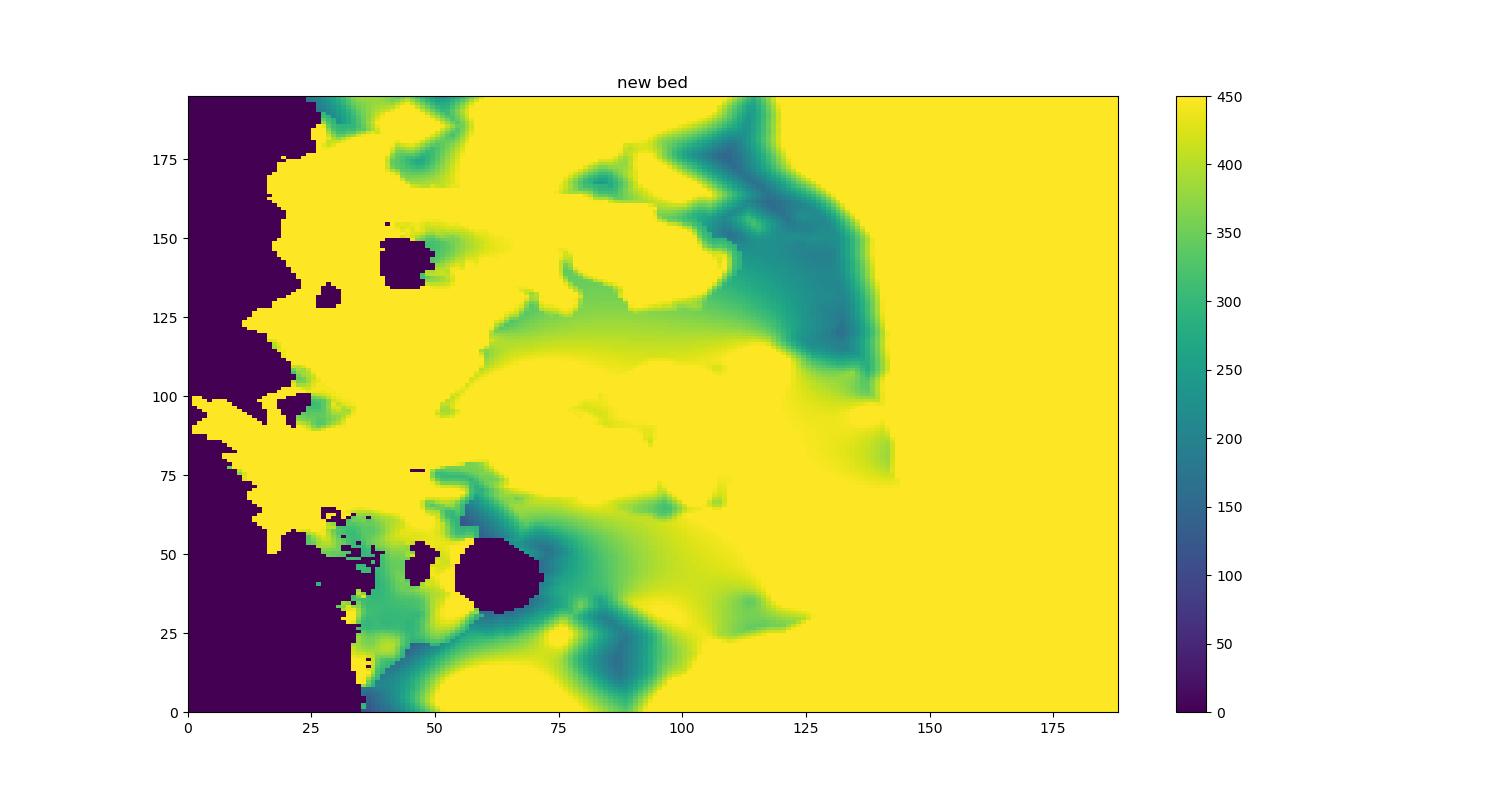

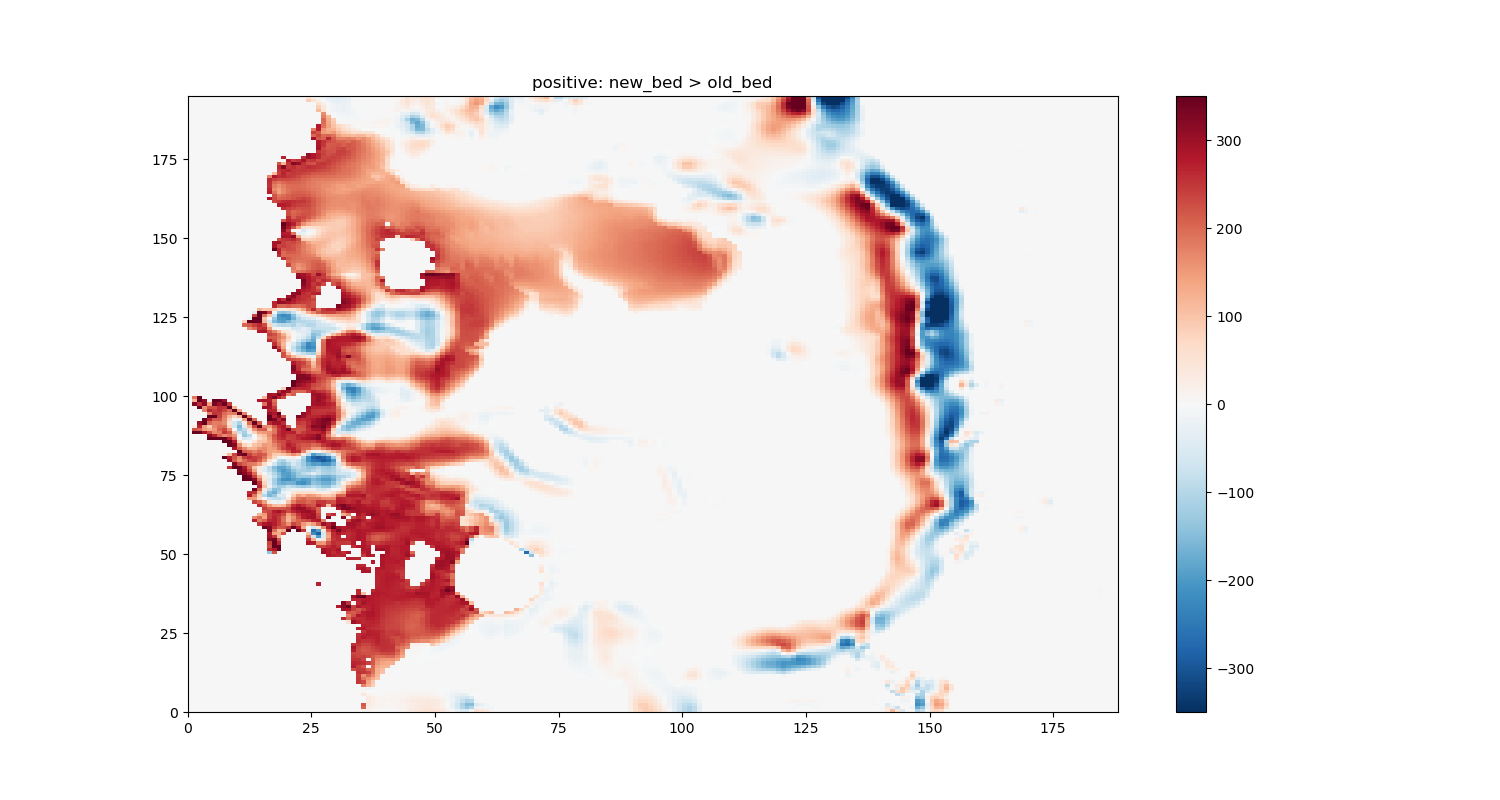

In [134]:
plt.figure(figsize=(15,5))
plt.pcolormesh(bed,vmin=00,vmax=500)
plt.colorbar()
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['bathy'],vmin=00,vmax=500)
plt.colorbar()
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['bathy']-bed,vmin=00,vmax=500,cmap='RdBu')
plt.colorbar()

old_bed = (roms_tmp['bathy'])*roms_tmp['mask_ocean']
new_bed = (bed)*mask

fig = plt.figure(figsize=(15,8))
plt.pcolormesh(old_bed,vmin=0,vmax=1000)
plt.colorbar()
plt.title('old bed')

fig = plt.figure(figsize=(15,8))
plt.pcolormesh(new_bed,vmin=0,vmax=1000)
plt.colorbar()
plt.title('new bed')

fig = plt.figure(figsize=(15,8))
plt.pcolormesh(new_bed,vmin=0,vmax=450)
plt.colorbar()
plt.title('new bed')

fig = plt.figure(figsize=(15,8))
plt.pcolormesh(new_bed-old_bed,vmin=-350,vmax=350,cmap='RdBu_r')
plt.title('positive: new_bed > old_bed')
plt.colorbar()

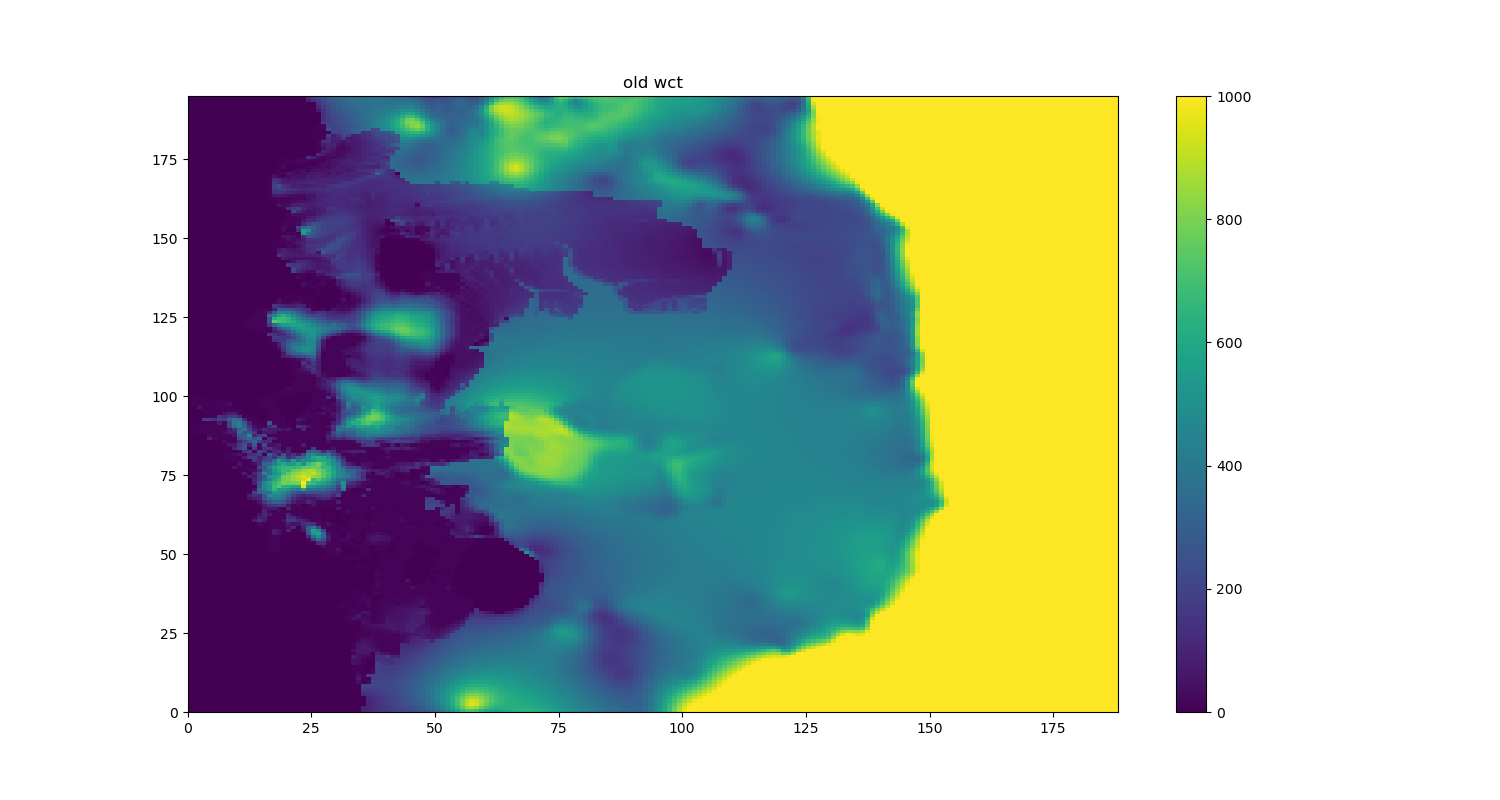

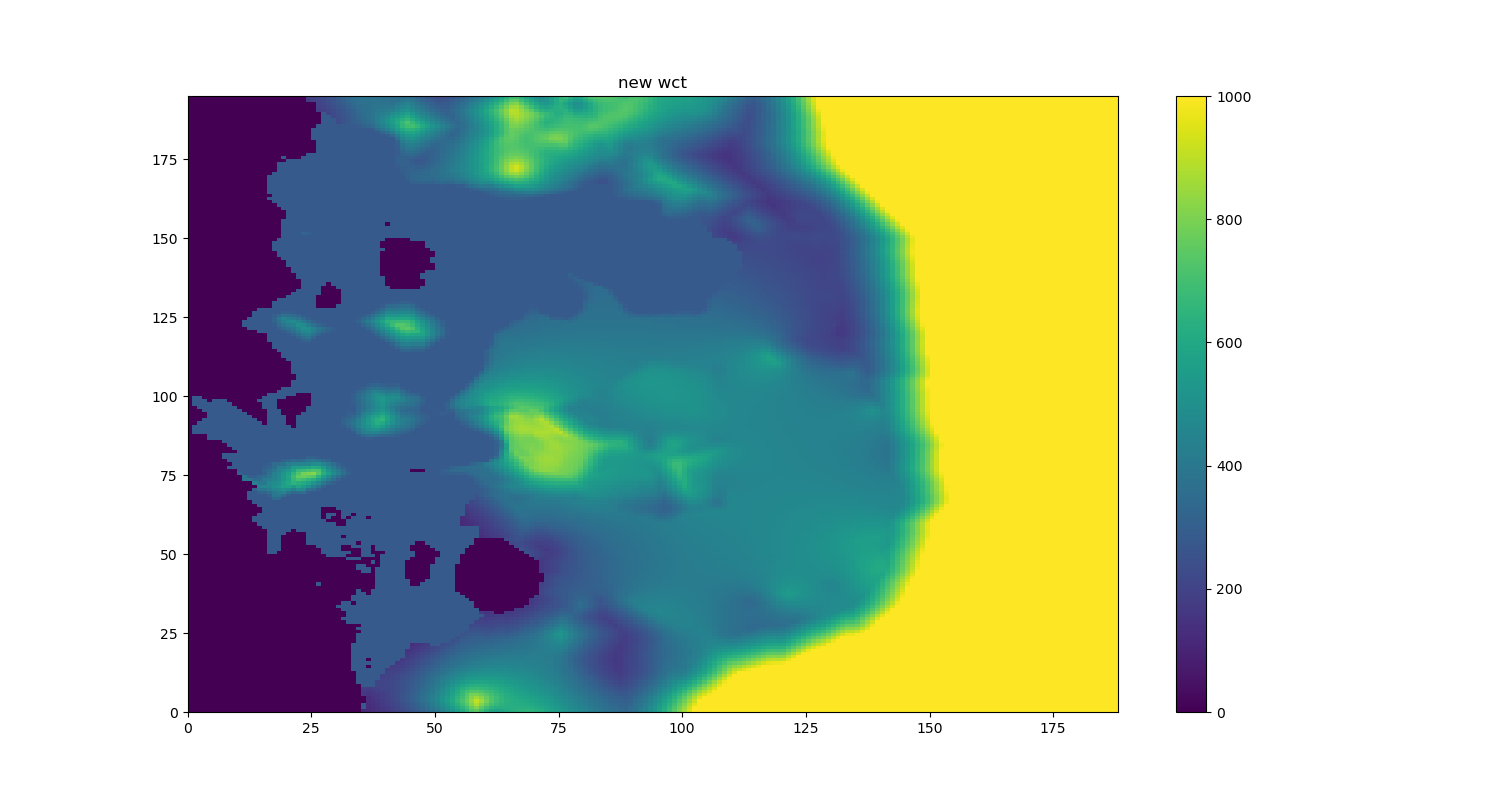

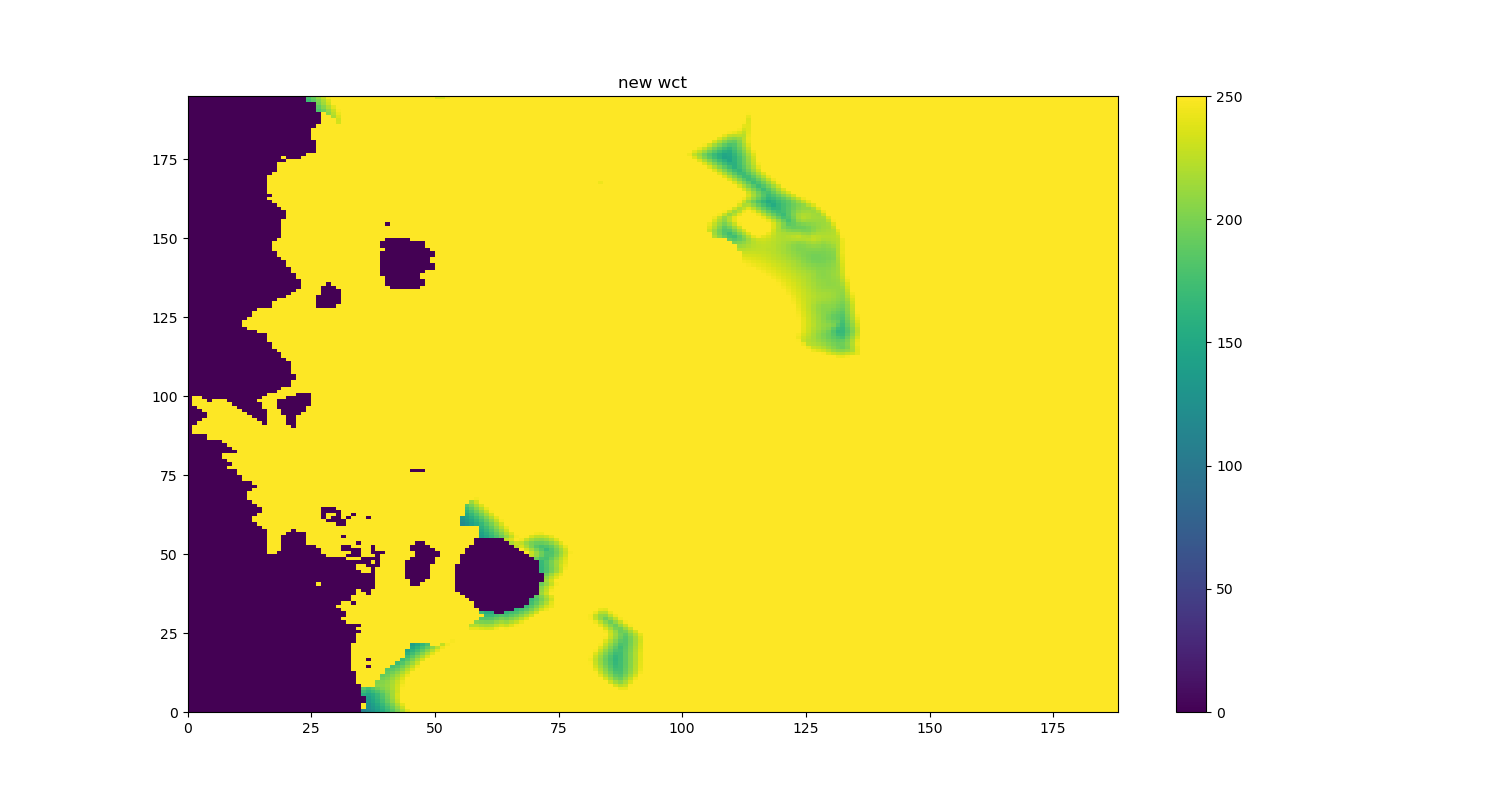

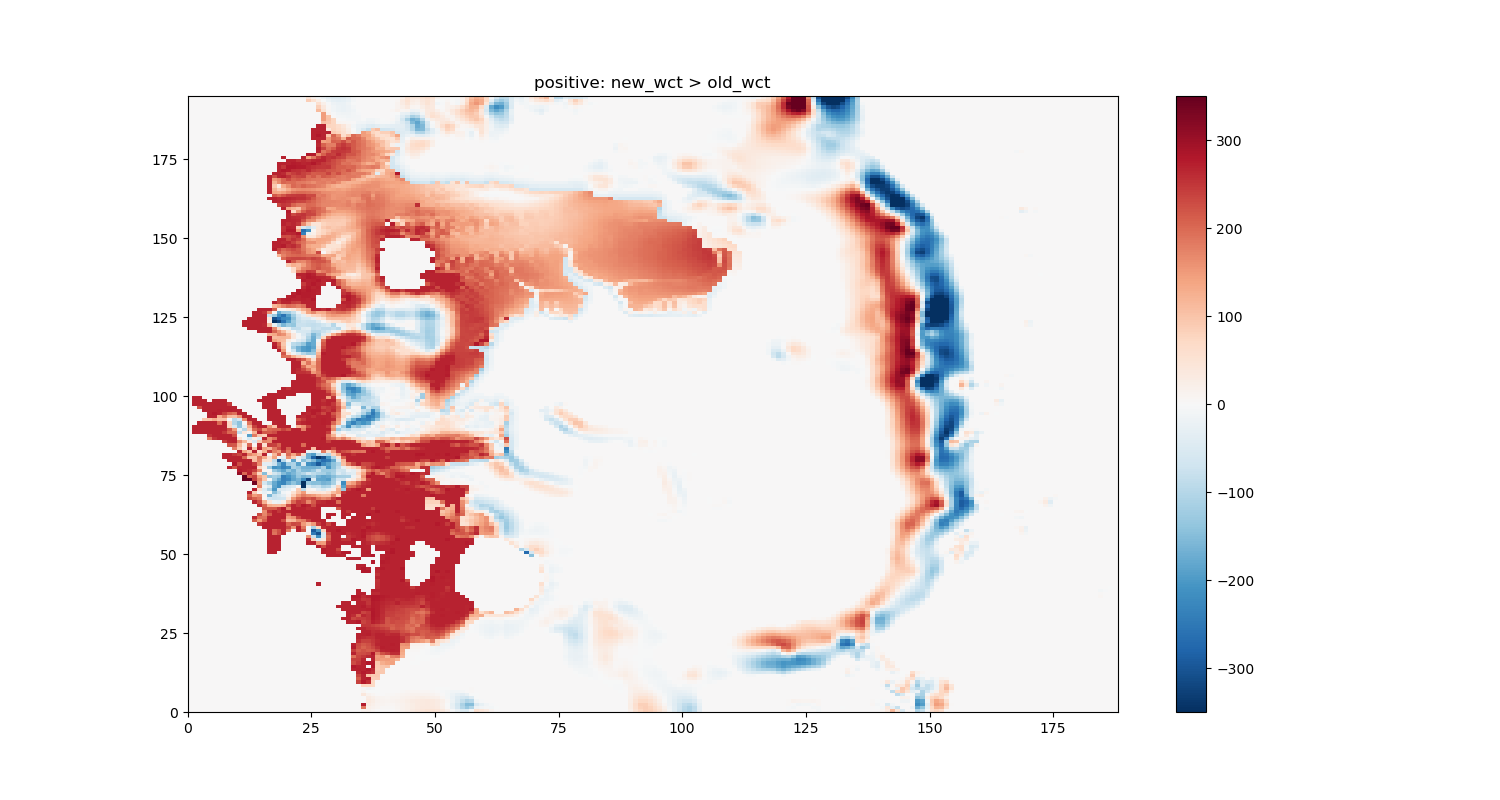

In [135]:
old_wct = (roms_tmp['bathy']+roms_tmp['draft'])*roms_tmp['mask_ocean']
new_wct = (bed+ice)*mask

fig = plt.figure(figsize=(15,8))
plt.pcolormesh(old_wct,vmin=0,vmax=1000)
plt.colorbar()
plt.title('old wct')

fig = plt.figure(figsize=(15,8))
plt.pcolormesh(new_wct,vmin=0,vmax=1000)
plt.colorbar()
plt.title('new wct')

fig = plt.figure(figsize=(15,8))
plt.pcolormesh(new_wct,vmin=0,vmax=250)
plt.colorbar()
plt.title('new wct')

fig = plt.figure(figsize=(15,8))
plt.pcolormesh(new_wct-old_wct,vmin=-350,vmax=350,cmap='RdBu_r')
plt.title('positive: new_wct > old_wct')
plt.colorbar()

In [136]:
# # check new cavity volume

# print('initial volume was ',initial_volume/1e12,'x10^12 m3')


# print('new volume ',np.sum(mask_amery*(ice+bed)*dx*dy),'m3')
# print(np.sum(mask_amery*(bed+ice)*dx*dy)/1e12,'x10^12 m3')
# print('ratio of new/old volume is ',np.sum(mask_amery*(ice+bed)*dx*dy)/initial_volume)


In [137]:
# i don't think second round of smoothing helps.
# # Second round of smoothing 
# rx0in=0.3
# bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)
# wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct,rx0in,Area,max_iter)
# ice = wct-bed
# bed_smooth2 = bed.copy()
# ice_smooth2 = ice.copy()

# Now enforce that there is no ice > 0
ii = ice>0
ice[ii] = 0

# now re-check that min_depth is obeyed for all ocean points
ii = ((bed + ice) < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

# do the same for all non-ocean points
ii = ((bed + ice) < min_depth) & (mask == 0)
ice[ii] = min_depth-bed[ii] # for those locations, the depth needs to be min_depth above the bathy

wct=bed+ice

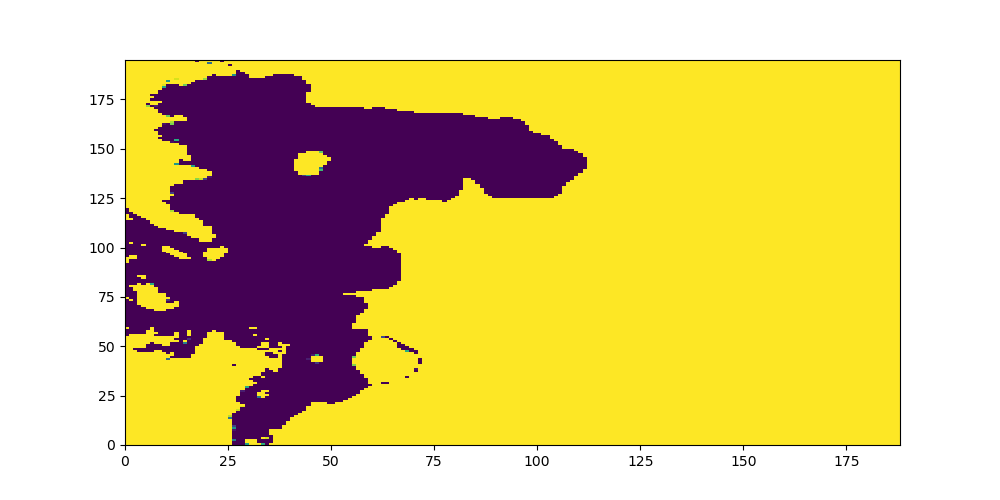

In [138]:
plt.figure(figsize=(10,5))
plt.pcolormesh(ice,vmin=-10,vmax=0)

In [139]:

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=270
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((340,420,-1500,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((340,420,-1500,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((340,420,-1500,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((340,420))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=98
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=120
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=205
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))



In [140]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin(wct*maskNaN),'/',np.nanmax(wct*maskNaN))

whole domain
min/max zice is -1582.0773 / 49.7
min/max h is 0.3 / 3222.336
min/max wct is 50.0 / 3222.336
ocean cells
min/max zice is -1202.32763671875 / -0.0
min/max h is 110.81787109375 / 3222.3359375
min/max wct is 110.81787109375 / 3222.3359375


In [141]:


roms_tmp['bed'] = bed
roms_tmp['ice'] = ice
roms_tmp['mask'] = mask

In [142]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))
print('max slow DT in s following CFL: ', np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/np.nanmin(CFL)).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))

max fast DT in s following CFL:  10.904577255249023
max slow DT in s following CFL:  242.34762513853738
Set ROMS timestep settings of at least: 
 DT < 242.34762513853738 s 
 NDTFAST > 22.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  8.816049465795384
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.8816049465795384


  
Minimum r-value =  0.0
Maximum r-value =  0.45924484729766846
Mean    r-value =  0.021065074553119224
Median  r-value =  0.014615256804972887


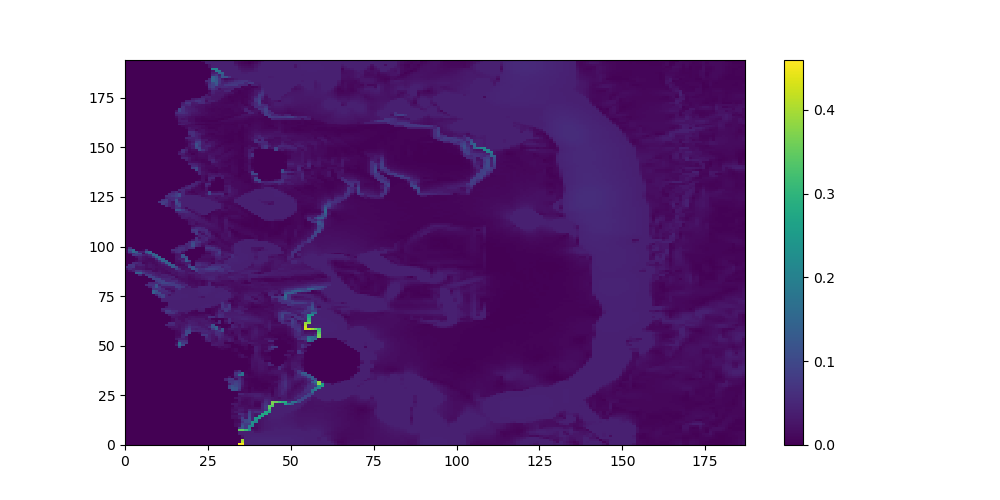

  
Minimum r-value =  0.0
Maximum r-value =  235.1216255339715
Mean    r-value =  5.993696343044689
Median  r-value =  2.982870507561465


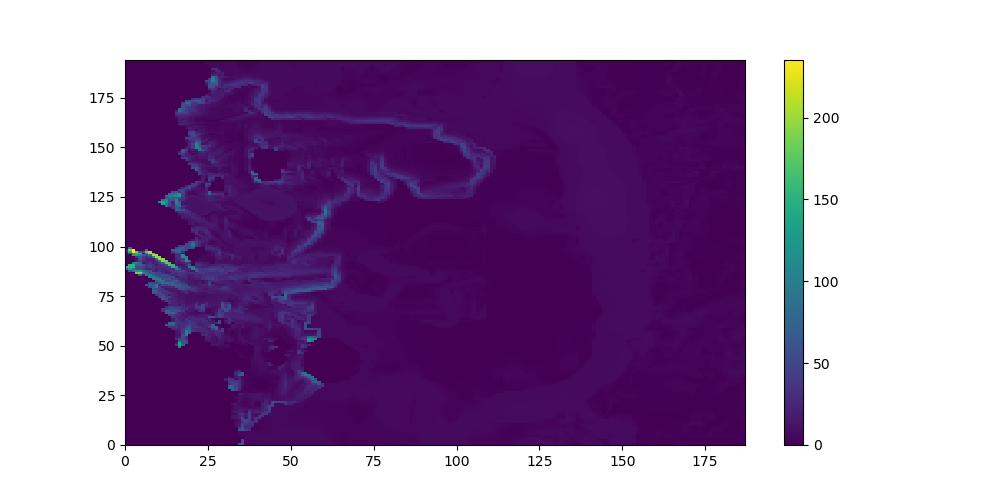

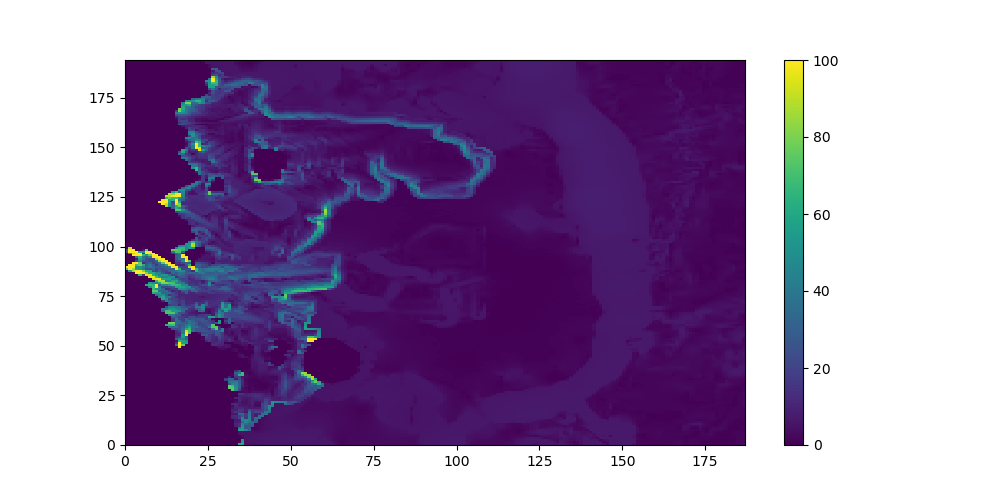

In [143]:



z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bed'],roms_tmp['ice'])

fig = plt.figure(figsize=(10,5))
grd_rx0_post=GridStiffness.rx0(roms_tmp['bed'],roms_tmp['mask'])
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
grd_rx1_post=GridStiffness.rx1(z_w_post,roms_tmp['mask'])
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
plt.pcolormesh(grd_rx1_post,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [144]:

# # correct ice so that it isn't adjusted where it never previously existed.
# zzz_backup = roms_tmp['ice'].copy()

# # OPTION 1:
# # need to correct to only update ice below ice shelves. Could do it with a find ice<0, or could just multiply by mask....
# # This will keep the strict masking and precisely defined ice shelf edges 
# #zzz = zzz_backup*(mask_openocean==0) 

# #OPTION 2:
# # manually remove any false ice. This will leave the slight smoothing that has been applied through the smoothin process.
# # This will keep the reduced rx1 at the edge of ice shelves.
# roms_tmp_ice_da = xr.DataArray(roms_tmp['ice'],name='ice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'roms_["ice"]', 'units': 'meter'})
# try:
#     roms_tmp_ice_da.to_netcdf('../data/proc/temporary_zice.nc')
# except:
#     print('already opened somewhere!')

# # plt.close('all')
# # # import matplotlib
# # # matplotlib.use('Qt5Agg')
# # import matplotlib.pyplot as plt
# # import PyQt5
# # %matplotlib qt
# # # import mplcursors

# # fig,ax=plt.subplots(figsize=(15,10))
# # im = ax.pcolormesh(roms_tmp['ice']!=0)
# # # cursor = mplcursors.cursor(im, hover=True)
# # pts = plt.ginput(n=-1)

# # plt.show()

# masking_ds = xr.open_dataset('../data/proc/temporary_zice_mask.nc')

# plt.figure()
# plt.pcolormesh(~masking_ds.IN_icemask)
# plt.colorbar()

# plt.figure()
# plt.pcolormesh(roms_tmp['ice']*~masking_ds.IN_icemask*roms_tmp['mask'],vmin=-20,vmax=0)
# plt.colorbar()
# plt.show()

# # if input('Are you happy with this? (Y/N)?')=='Y':
# print('continuing...')
# roms_tmp['ice'] = (roms_tmp['ice']*~masking_ds.IN_icemask.values).copy()
    
# # else:
# #     STOP
# # print(pts)

In [145]:
# !!! BEWARE, ALL YE WHO ENTER HERE, THE REALM OF HAND-EDITING SUB-ICE SHELF GEOMETRY. HERE BE DRAGONS. !!!
# ensure that GridAdjustments functions are already loaded.



hhh=roms_tmp['bed'].copy()
zzz=roms_tmp['ice'].copy()
mmm=roms_tmp['mask'].copy()

## an edit to eta_n, xi_n will affect rx1 in the eta_n-2--eta_n-1,xi_n--xi_n+1

# fix strange open ocean triangle in east shelf
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=15,roi_row_max=45,roi_col_min=32,roi_col_max=50,if_plotting=0,min_threshold_h=150) 


#adjust denman
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=97,xi=7)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=96,xi=8)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=95,xi=9)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=94,xi=10)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=93,xi=11)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=92,xi=12)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=91,xi=13)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=90,xi=14)
# hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=71,roi_row_max=103,roi_col_min=0,roi_col_max=14,if_plotting=0,min_threshold_h=300) 
# hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=71,roi_row_max=97,roi_col_min=0,roi_col_max=23,if_plotting=0,min_threshold_h=200) 
out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,1,roi_row_min=71,roi_row_max=103,roi_col_min=0,roi_col_max=14,if_plotting=0)
hhh = hhh + (zzz - out_smooth)
zzz = out_smooth.copy()
out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,1,roi_row_min=91,roi_row_max=96,roi_col_min=15,roi_col_max=20,if_plotting=0)
hhh = hhh + (zzz - out_smooth)
zzz = out_smooth.copy()
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=71,roi_row_max=105,roi_col_min=0,roi_col_max=20,if_plotting=0,min_threshold_h=220) 
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=0,eta=slice(115,130),xi=slice(5,19))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=0,eta=slice(117,128),xi=slice(20,23))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=89,xi=(15,16))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=89,xi=20)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=0,eta=slice(85,93),xi=slice(0,5))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=75,zice_alter=0,eta=slice(88,91),xi=slice(13,18))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=89,xi=16)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-40,zice_alter=40,eta=89,xi=14)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-40,zice_alter=40,eta=87,xi=14)
# hhh,zzz=adjustWCT(hhh,zzz,h_alter=00,zice_alter=0,eta=88,xi=15)
out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,1,roi_row_min=113,roi_row_max=131,roi_col_min=10,roi_col_max=25,if_plotting=0)
hhh = hhh + (zzz - out_smooth)
zzz = out_smooth.copy()
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=0,eta=slice(83,101),xi=slice(0,9))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=0,eta=slice(94,104),xi=slice(13,21))


# west of denman
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=43,roi_row_max=57,roi_col_min=15,roi_col_max=20,if_plotting=0,min_threshold_h=320) 
out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,1,roi_row_min=146,roi_row_max=153,roi_col_min=0,roi_col_max=25,if_plotting=0)
hhh = hhh + (zzz - out_smooth)
zzz = out_smooth.copy()
out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,1,roi_row_min=88,roi_row_max=91,roi_col_min=12,roi_col_max=16,if_plotting=0)
hhh = hhh + (zzz - out_smooth)
zzz = out_smooth.copy()

#far west
mmm=adjustMask(mmm,0,eta=slice(181,186),xi=slice(20,29))

# outer shelf region
mmm=adjustMask(mmm,0,eta=slice(52,55),xi=slice(55,58))

#far east of shelf
mmm=adjustMask(mmm,0,eta=50,xi=slice(16,18))
mmm=adjustMask(mmm,0,eta=51,xi=16)


# mask out bigger lakes
mmm=adjustMask(mmm,0,eta=slice(61,63),xi=slice(28,30))
mmm=adjustMask(mmm,0,eta=slice(43,49),xi=slice(32,38))
mmm=adjustMask(mmm,0,eta=slice(40,41),xi=slice(26,27))





mmmNaN = mmm.copy().astype('float')
mmmNaN[mmmNaN == 0] = np.NaN


Old Max Roughness value is:  0.5659151673316956


DeltaBathymetry =  1662.9872436523438
New Max Roughness value is:  0.3951285779476166
Old Max Roughness value is:  0.23196101188659668


DeltaBathymetry =  564.5405540466309
New Max Roughness value is:  0.07197919487953186
Old Max Roughness value is:  0.24626599252223969


DeltaBathymetry =  -200.44277954101562
New Max Roughness value is:  0.16059944033622742
Old Max Roughness value is:  0.18924497067928314


DeltaBathymetry =  430.2855682373047
New Max Roughness value is:  0.09515807032585144
Old Max Roughness value is:  0.10626786202192307


DeltaBathymetry =  472.9075393676758
New Max Roughness value is:  0.04505623131990433


  
Minimum r-value =  0.0
Maximum r-value =  0.45924484729766846
Mean    r-value =  0.020859790863358908
Median  r-value =  0.014554122928529978
  
Minimum r-value =  0.0
Maximum r-value =  92.90369595422295
Mean    r-value =  5.645335372193398
Median  r-value =  2.9723728872205544


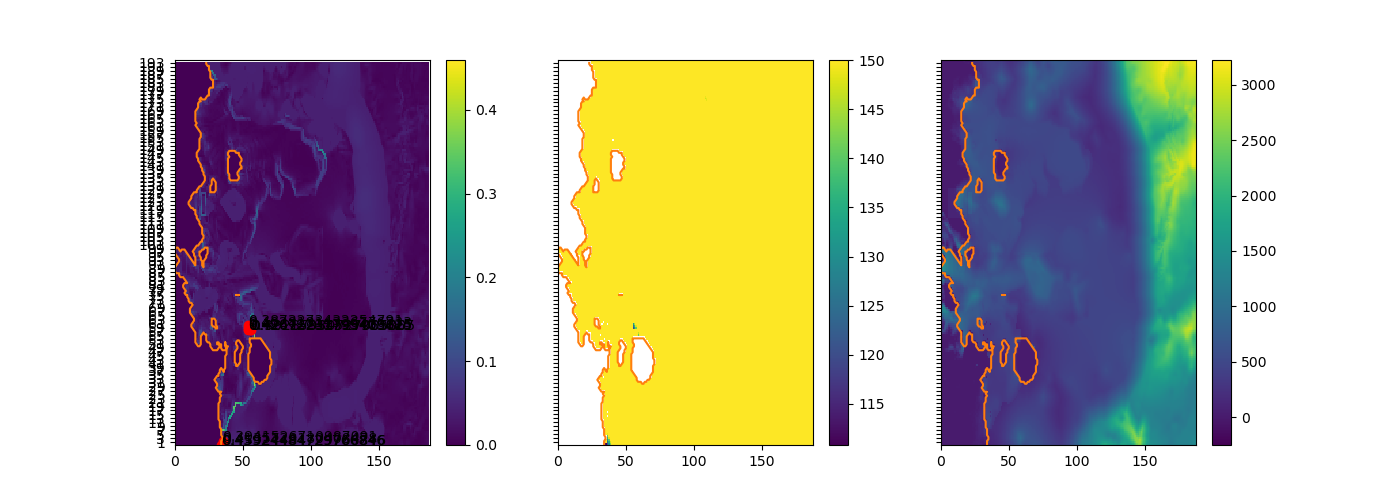

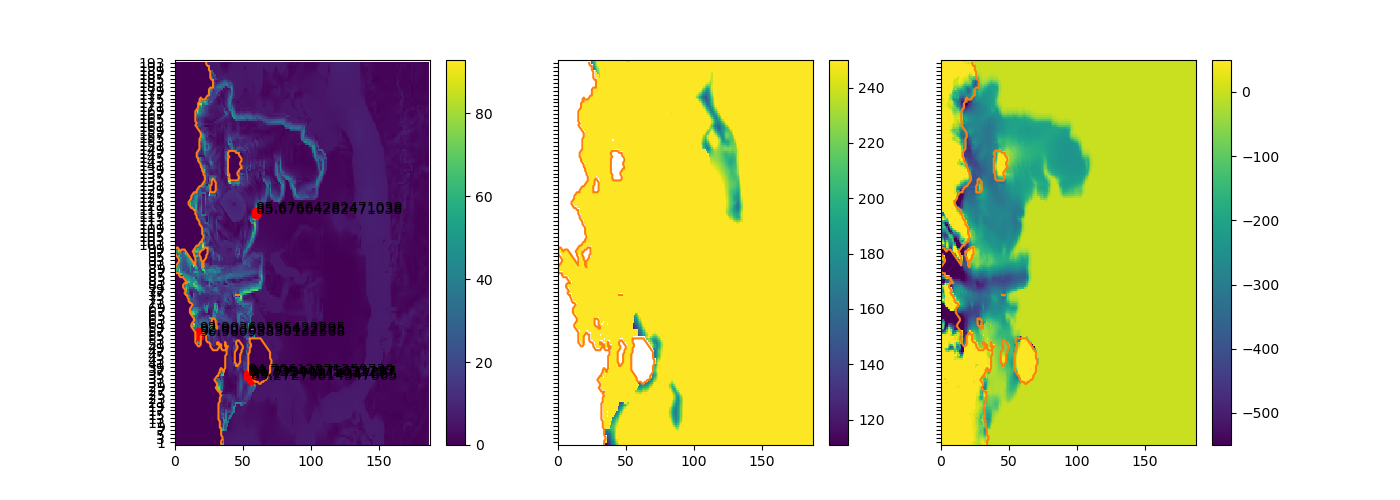

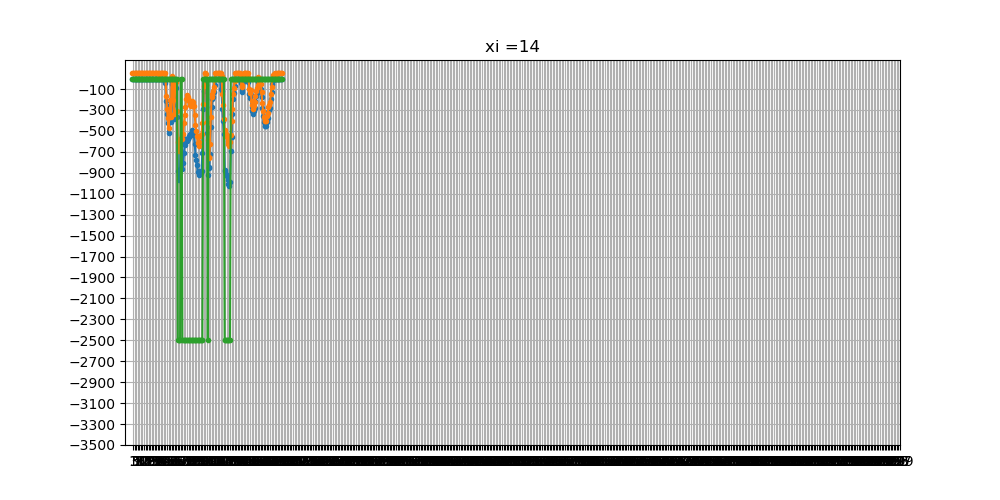

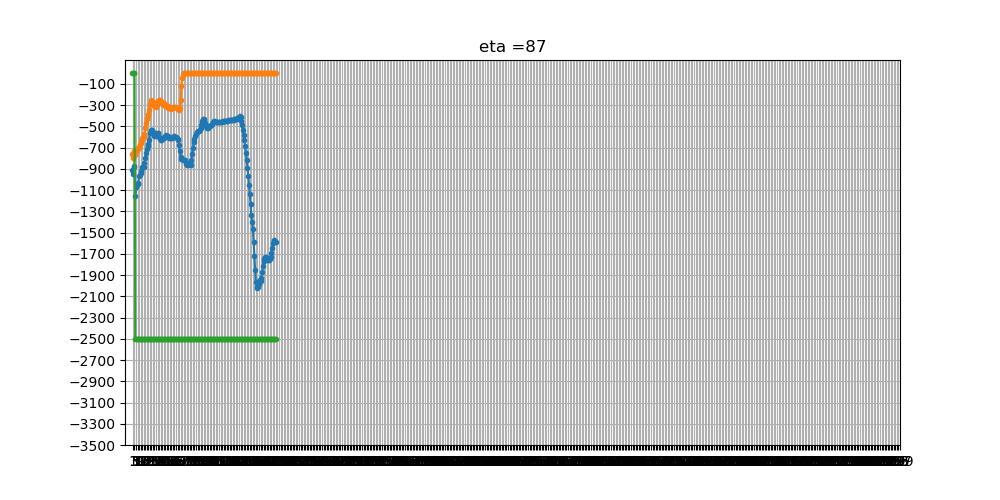

In [146]:

import matplotlib.pyplot as plt
%matplotlib widget
z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
# z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,4,1,Tcline+50,hc+50,25,hhh,zzz)
grd_rx0_post=GridStiffness.rx0(hhh,mmm)
grd_rx1_post=GridStiffness.rx1(z_w_post,mmm)

plt.close('all')


fig,axs = plt.subplots(ncols=3,figsize=(14,5),sharex=True,sharey=True)
im=axs[0].pcolormesh(grd_rx0_post)
rx0_flat = grd_rx0_post.ravel()
ind = np.argpartition(rx0_flat,-10)[-10:]
ind
for where in ind: 
    w_j,w_i=np.unravel_index(where,grd_rx0_post.shape)
    axs[0].plot(w_i,w_j,'ro')
    axs[0].text(w_i,w_j,rx0_flat[where])
axs[0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0])
axs[0].contour(mmm,levels=((0,1)),colors='C1')
im=axs[1].pcolormesh((hhh+zzz)*mmmNaN,vmax=150)
axs[1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1])
axs[1].contour(mmm,levels=((0,1)),colors='C1')
im=axs[2].pcolormesh(hhh,vmin=-250)
axs[2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[2])
axs[2].contour(mmm,levels=((0,1)),colors='C1')


fig,axs = plt.subplots(ncols=3,figsize=(14,5),sharex=True,sharey=True)
im=axs[0].pcolormesh(grd_rx1_post)
rx1_flat = grd_rx1_post.ravel()
ind = np.argpartition(rx1_flat,-10)[-10:]
ind
for where in ind: 
    w_j,w_i=np.unravel_index(where,grd_rx1_post.shape)
    axs[0].plot(w_i,w_j,'ro')
    axs[0].text(w_i,w_j,rx1_flat[where])
axs[0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0])
axs[0].contour(mmm,levels=((0,1)),colors='C1')
im=axs[1].pcolormesh((hhh+zzz)*mmmNaN,vmax=250)
axs[1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1])
axs[1].contour(mmm,levels=((0,1)),colors='C1')
im=axs[2].pcolormesh(zzz,vmin=-550)
axs[2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[2])
axs[2].contour(mmm,levels=((0,1)),colors='C1')


# look along a single xi value
lookAtX=14
fig = plt.figure(figsize=(10,5))
plt.plot(-hhh[:,lookAtX],'.-')
plt.plot(zzz[:,lookAtX],'.-')
plt.plot(-1*mmm[:,lookAtX]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('xi ='+str(lookAtX))
# plt.xlim(focusRange[2],focusRange[3])
plt.grid()

# look along a single eta value
lookAtE=87
fig = plt.figure(figsize=(10,5))
plt.plot(-hhh[lookAtE,:],'.-')
plt.plot(zzz[lookAtE,:],'.-')
plt.plot(-1*mmm[lookAtE,:]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('eta ='+str(lookAtE))
plt.grid()


# from mpl_toolkits.mplot3d import axes3d
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(projection='3d')
# # # Grab some test data.
# # X, Y, Z = axes3d.get_test_data(0.05)
# # Plot a basic wireframe.
# X,Y = np.meshgrid(np.arange(1,zzz.shape[1]+1),np.arange(1,zzz.shape[0]+1))
# ax.plot_wireframe(X[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20],Y[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20],hhh[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20], rstride=1, cstride=1)
# ax.plot_wireframe(X[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20],Y[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20],zzz[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20], rstride=1, cstride=1)
# ax.set_xlabel('xi')
# ax.set_ylabel('eta')


In [43]:
# plt.close('all')
# %matplotlib inline
# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh(hhh,vmin=0,vmax=250)
# plt.colorbar()

# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh(zzz,vmin=-250,vmax=0)
# plt.colorbar()

# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh(zzz*(mask_openocean==0),vmin=-250,vmax=0)
# plt.colorbar()

# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh(hhh-roms_tmp['bed'],vmin=-350,vmax=350,cmap='RdBu_r')
# plt.title('positive: new_hhh > old_hhh')
# plt.colorbar()

# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh(zzz-roms_tmp['draft'],vmin=-350,vmax=350,cmap='RdBu_r')
# plt.title('positive: new_hhh > old_hhh')
# plt.colorbar()

# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh(zzz!=0,cmap='RdBu_r')
# plt.title('z != 0')
# plt.colorbar()

# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh(roms_tmp['draft']!=0,cmap='RdBu_r')
# plt.title('z != 0')
# plt.colorbar()

# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh((zzz!=0)*1-(roms_tmp['draft']!=0)*1,cmap='RdBu_r')
# plt.title('z != 0')
# plt.colorbar()

In [147]:
# Remove single cell water "lakes"


from contextlib import suppress

def compare_neighbors(arr):
# # test example:
# arr = np.array([[False, False, False, False, False, False],
#                 [False, True, False, True, False, False],
#                 [False, False, False, False, True, False],
#                 [True, False, False, True, True, False],
#                 [False, True, True, True, False, False],
#                 [False, True, False, True, False, False],
#                 [False, True, True, True, False, False]])

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # print(x,y)
        # print(x,y,arr.shape[0],arr.shape[1])
        # print((x<arr.shape[0]) & (y<arr.shape[1]))
        if (x>0) & (y>0) & (x<arr.shape[0]-1) & (y<arr.shape[1]-1):
            # print(x,y)
            if (arr[x-1, y] != item) & (arr[x+1, y] != item) & (arr[x, y+1] != item) & (arr[x, y-1] != item):
                if (arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item):
                    comp_arr[x, y] = True # Isolated cells are set to True
                if ((arr[x-1, y-1] == item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] == item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] == item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] == item)):
                    comp_arr[x, y] = True # find diagonal single cells
    return comp_arr


islands = compare_neighbors(mmm)

mmm_noSS = mmm.copy()

islandBehaviour = 'keep_islands' #'keep_islands' or 'remove_islands'
if islandBehaviour=='remove_islands':
    mmm_noSS[islands] = np.logical_not(mmm_noSS[islands]) # flip sign on only the islands
elif islandBehaviour=='keep_islands':
    mmm_noSS[islands] = np.full(mmm_noSS[islands].shape,False) # flip sign on only the islands



mmm = mmm_noSS

  
Minimum r-value =  0.0
Maximum r-value =  0.45924484729766846
Mean    r-value =  0.020859790863358908
Median  r-value =  0.014554122928529978


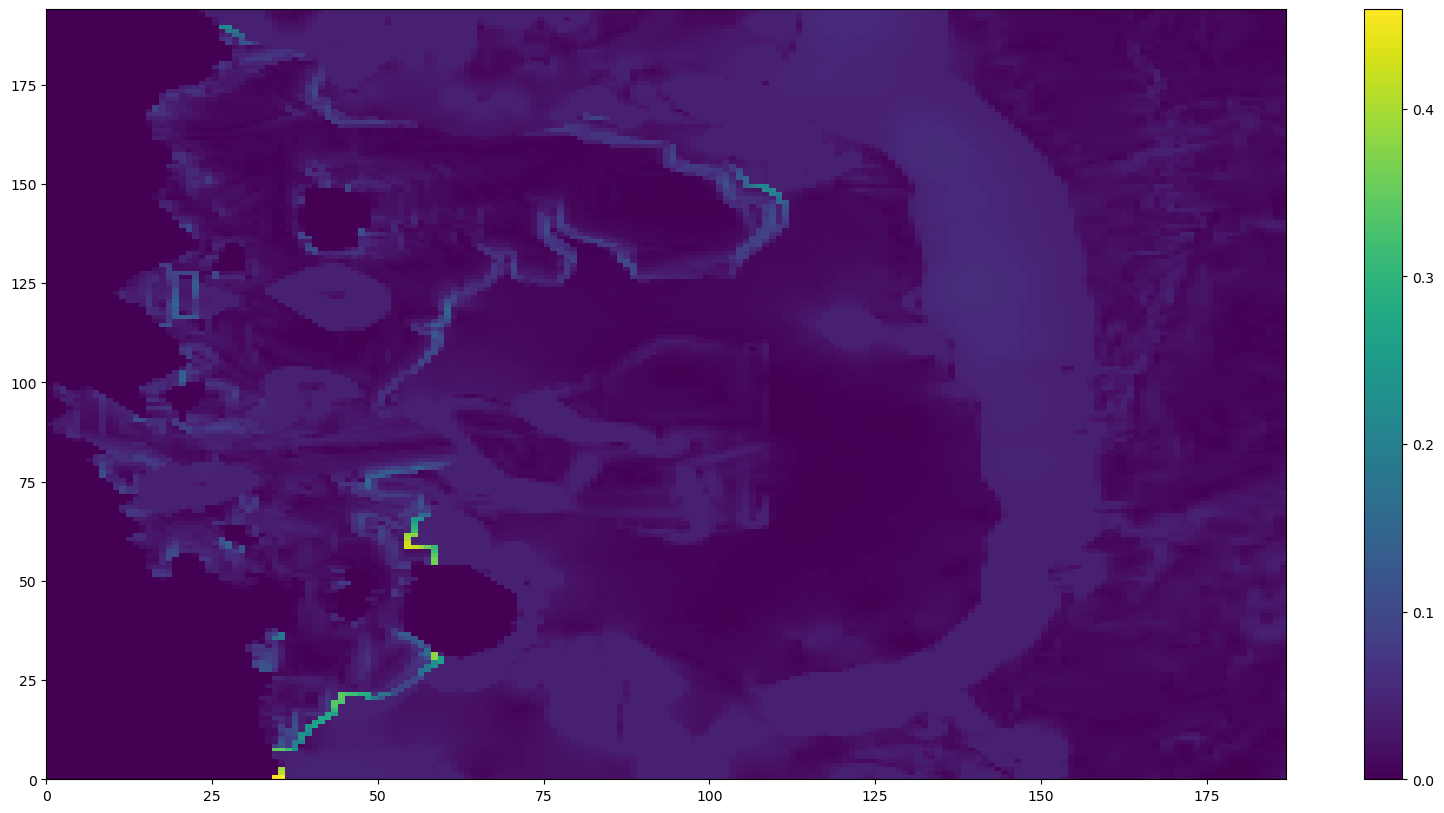

  
Minimum r-value =  0.0
Maximum r-value =  92.90369595422295
Mean    r-value =  5.645335372193398
Median  r-value =  2.9723728872205544


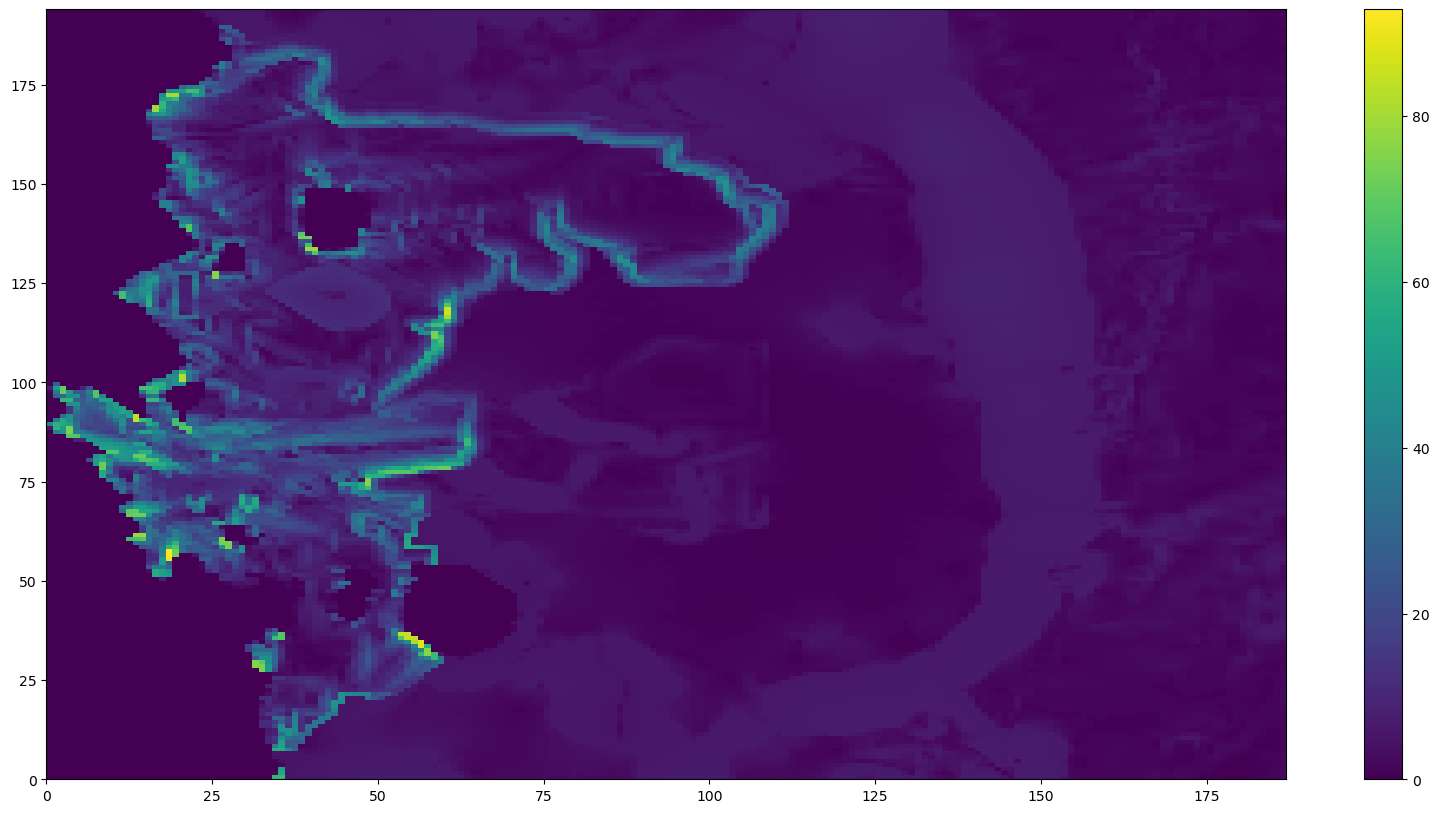

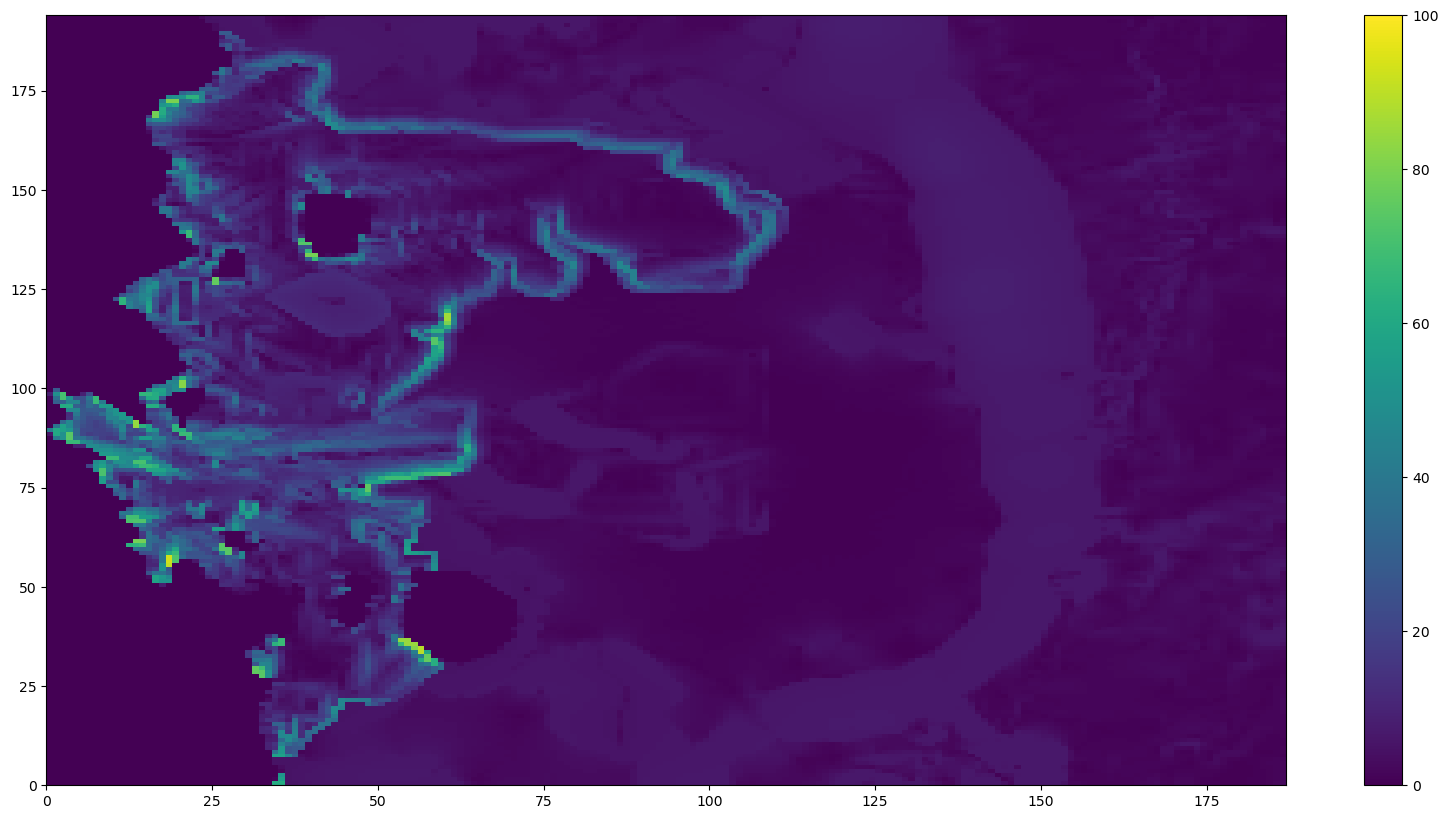

In [148]:
# Now check post-manual editing rx values

%matplotlib inline

z_rho_postManualEdits,z_w_postManualEdits,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
plt.close('all')
fig = plt.figure(figsize=(20,10))
grd_rx0_postManualEdits=GridStiffness.rx0(hhh,mmm)
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_postManualEdits=GridStiffness.rx1(z_w_postManualEdits,mmm)
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_postManualEdits,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [149]:
# interannual_coverage_cutoff = 0.5 # Interannual persistence: at least this fractional% required over 2000-2018 monthly climatology to be considered as ice.
# annual_coverage_cutoff = 0.9 # Annual persistence: at least this fractional % required over the year to be considered as ice

# filelist= glob.glob(data_dir+'/raw/adf_fastice/'+'FastIce*.nc')
# for file in filelist:
#     fi_singlefile = xr.open_dataset(filelist)
#     fi_full = fi_singlefile.drop(['x','y','area','date_alt'])

#     # make the fast ice mask data array
#     fi = (fi_full.Fast_Ice_Time_series==4) | (fi_full.Fast_Ice_Time_series==5) | (fi_full.Fast_Ice_Time_series==6)
    
#     # # check that i'm adding all the required fields
#     # (((fi - fi_full.Fast_Ice_Time_series==4) - fi_full.Fast_Ice_Time_series==5) - fi_full.Fast_Ice_Time_series==6).isel(time=10).plot()


#     fi_clima = fi.groupby('time.month').mean() #make the monthly climatology
#     # # check that the mean is working
#     # (fi.groupby('time.month').mean()>0.5).isel(month=2).plot()
#     # plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')
#     # plt.show()
#     # (fi.groupby('time.month').mean()).isel(month=2).plot()
#     # plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')


#     fi_mean_interannual = (fi_clima>=interannual_coverage_cutoff).mean(dim='month')

#     fi_mean_annual = fi_mean_interannual>=annual_coverage_cutoff

In [150]:
# add fast ice

# fi_fulldata = xr.open_mfdataset(data_dir+'/raw/adf_fastice/'+'*.nc') # load full fast ice data set
fi_fulldata = xr.open_mfdataset(data_dir+'/raw/adf_fastice/'+'FastIce_70_200[0-2].nc',data_vars='different') # load full fast ice data set, don't concat similar datavars (e.g. lon)

fi_full = fi_fulldata.drop(['x','y','area','date_alt'])
# fi_full = fi_full_coordCorrected

fi_full.nbytes/1e9

2.009250544

In [151]:
fi_full

<xarray.Dataset>
Dimensions:               (Y: 4700, X: 5625, time: 68)
Coordinates:
  * time                  (time) datetime64[ns] 2000-03-01 ... 2002-12-12
Dimensions without coordinates: Y, X
Data variables:
    latitude              (Y, X) float32 dask.array<chunksize=(4700, 5625), meta=np.ndarray>
    longitude             (Y, X) float32 dask.array<chunksize=(4700, 5625), meta=np.ndarray>
    Fast_Ice_Time_series  (time, Y, X) int8 dask.array<chunksize=(20, 4700, 5625), meta=np.ndarray>
Attributes:
    title:        Fast ice time series
    institution:  Institute for Marine and Antarctic Studies, University of T...
    source:       MODIS 15-day composite images and automated edge detection
    history:      Version 2.2
    references:   Fraser et al., 2020 (Earth System Science Data, submitted)
    comment:      This is the lat_ts=-70 version of the data - year 2000
    contact:      Alex Fraser (adfraser@utas.edu.au)
    Conventions:  CF-1.7

In [152]:
interannual_coverage_cutoff = 0.5 # Interannual persistence: at least this fractional% required over 2000-2018 monthly climatology to be considered as ice.
annual_coverage_cutoff = 0.8 # Annual persistence: at least this fractional % required over the year to be considered as fast ice

fi = (fi_full.Fast_Ice_Time_series==4) | (fi_full.Fast_Ice_Time_series==5) | (fi_full.Fast_Ice_Time_series==6) # make the fast ice mask data array
# # check that i'm adding all the required fields
# (((fi - fi_full.Fast_Ice_Time_series==4) - fi_full.Fast_Ice_Time_series==5) - fi_full.Fast_Ice_Time_series==6).isel(time=10).plot()


fi_clima = fi.groupby('time.month').mean() #make the monthly climatology
# # check that the mean is working
# (fi.groupby('time.month').mean()>0.5).isel(month=2).plot()
# plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')
# plt.show()
# (fi.groupby('time.month').mean()).isel(month=2).plot()
# plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')


fi_mean_interannual = (fi_clima>=interannual_coverage_cutoff).mean(dim='month')

fi_mean_annual = fi_mean_interannual>=annual_coverage_cutoff




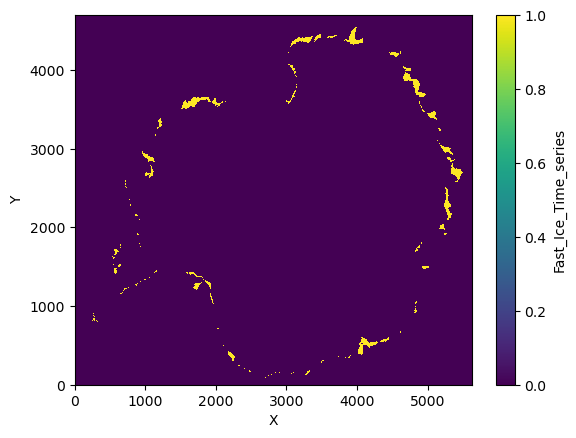

In [153]:
# now map the fast ice data to the model grid
fi_mean_annual.plot()

# interp (nearest) to the model lat/lon

fi_mean_annual_i = griddata((fi_full['longitude'].values.flatten(),fi_full['latitude'].values.flatten()),fi_mean_annual.values.flatten(),(lon_rho,lat_rho),'nearest')


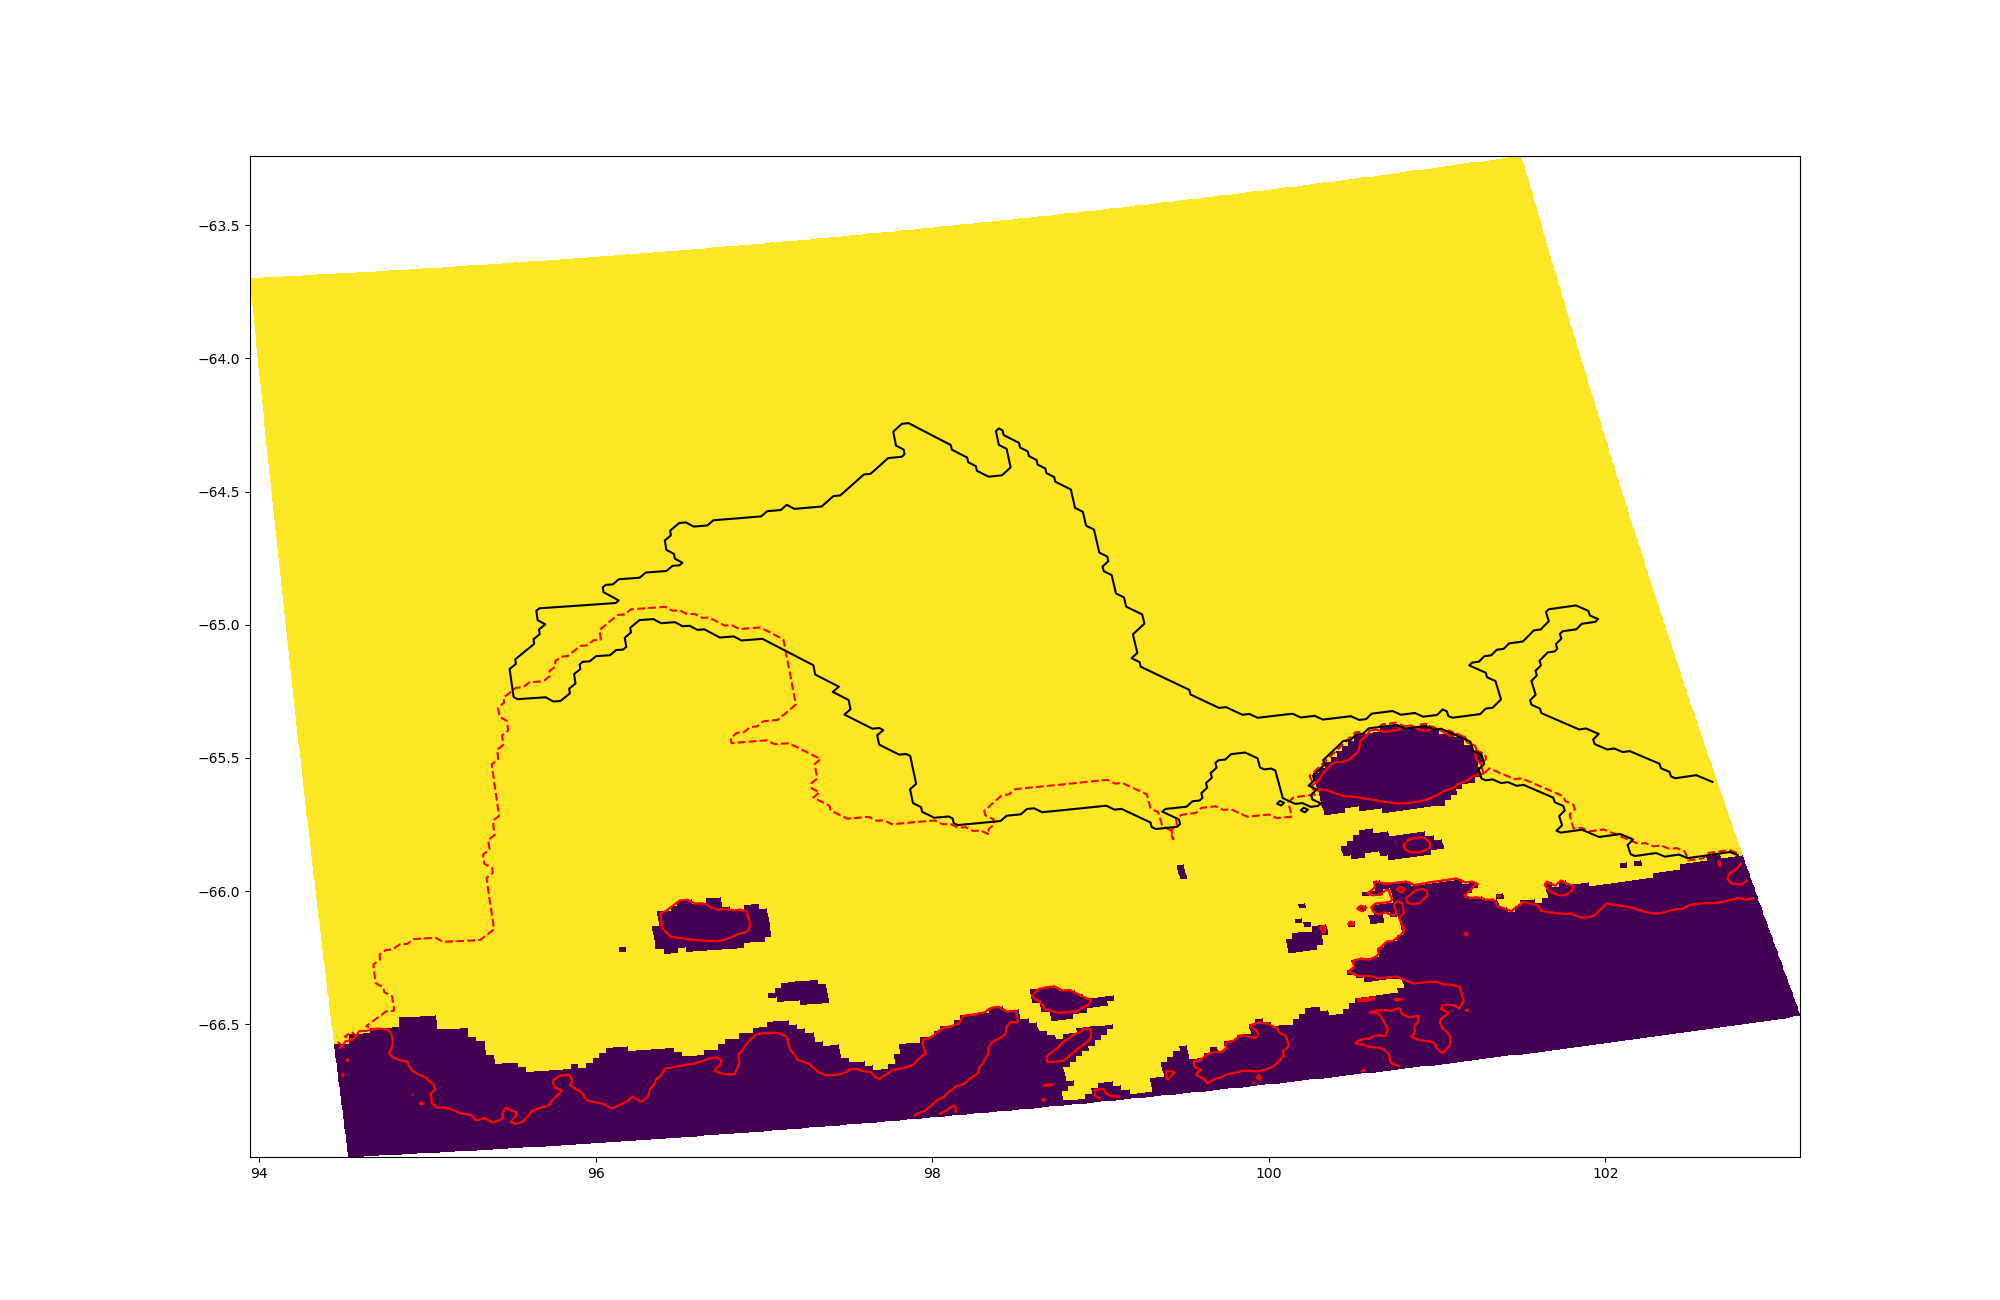

In [154]:
%matplotlib widget
fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,mmm)
plt.contour(lon_rho,lat_rho,zzz,levels=[-1,0],colors='r')

plt.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')

In [155]:
# manually add missing fast ice

# fig = plt.figure(figsize=(20,13))
# plt.pcolormesh(lon_rho,lat_rho,mmm)
# plt.contour(lon_rho,lat_rho,zzz,levels=[0,-1])

# plt.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')



add_fasticefill = np.array([
    [100.239,-65.771],
    [99.377,-65.846],
    [97.220,-65.771],
    [96.649,-65.422],
    [96.691,-64.862],
    [98.444,-65.238],
    [99.841,-65.403],
    [100.185,-65.531]
])

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


mask_fasticefill = inpolygon(lon_rho, lat_rho,add_fasticefill[:,0], add_fasticefill[:,1])


In [156]:
# # add icebergs
# # download from https://apps.sentinel-hub.com/eo-browser/ (need log in)
# # download as a tif, georeferenced, high res, etc, Sentinel-1 AWS-EW-HHHV, HH-linear gamma0 - radiometric terrain, clip extra bands, note the coordinate system. e.g. WGS84 is EPSG:4326 
# import rioxarray

# S1b = rioxarray.open_rasterio('../data/raw/Sentinel/2023-05-01-00 00_2023-05-01-23 59_Sentinel-1_AWS-EW-HHHV_HH_-_linear_gamma0_-_radiometric_terrain_corrected.tiff')

# # import matplotlib
# # matplotlib.use('Qt5Agg')
# import matplotlib.pyplot as plt
# %matplotlib widget
# import mplcursors

# fig,ax=plt.subplots(figsize=(15,10))
# im = ax.pcolormesh(S1b.x,S1b.y,S1b.isel(band=0).values)
# cursor = mplcursors.cursor(im, hover=True)


# #define outline of icebergs (manually until vscode/jupyter can use plt.ginput())

# d12=np.array([
# [81.89,-66.246],
# [82.07,-66.309],
# [82.11,-66.396],
# [82.24,-66.469],
# [82.23,-66.513],
# [82.42,-66.576],
# [82.52,-66.746],
# [82.56,-66.906],
# [82.58,-67.023],
# [82.42,-67.047],
# [82.49,-67.071],
# # [82.19,-67.091],
# [82.33,-67.11],
# [81.79,-67.173],
# [81.45,-67.100],
# [81.79,-67.178],
# [81.40,-67.086],
# [81.36,-66.989],
# [81.22,-66.935],
# [81.29,-66.887],
# [81.14,-66.824],
# [81.05,-66.726],
# [81.14,-66.707],
# [81.32,-66.697],
# [81.35,-66.615],
# [81.37,-66.552],
# [81.26,-66.522],
# [81.30,-66.484],
# [81.24,-66.435],
# [81.25,-66.372],
# [81.20,-66.343],
# [81.40,-66.270 ]
# ])


# def inpolygon(xq, yq, xv, yv):
#     from matplotlib import path
#     shape = xq.shape
#     xq = xq.reshape(-1)
#     yq = yq.reshape(-1)
#     xv = xv.reshape(-1)
#     yv = yv.reshape(-1)
#     q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
#     p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
#     return p.contains_points(q).reshape(shape)


# mask_icebergs = inpolygon(lon_rho, lat_rho,d12[:,0], d12[:,1])



# fig,ax=plt.subplots(figsize=(15,10))
# im = ax.pcolormesh(S1b.x,S1b.y,S1b.isel(band=0).values)
# plt.plot(d12[:,0],d12[:,1],'k')



# fig = plt.figure(figsize=(20,13))
# plt.pcolormesh(lon_rho,lat_rho,mmm)
# plt.contour(lon_rho,lat_rho,zzz,levels=np.array((-1,0)))

# plt.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')
# plt.contour(lon_rho,lat_rho,mask_icebergs,colors='r')

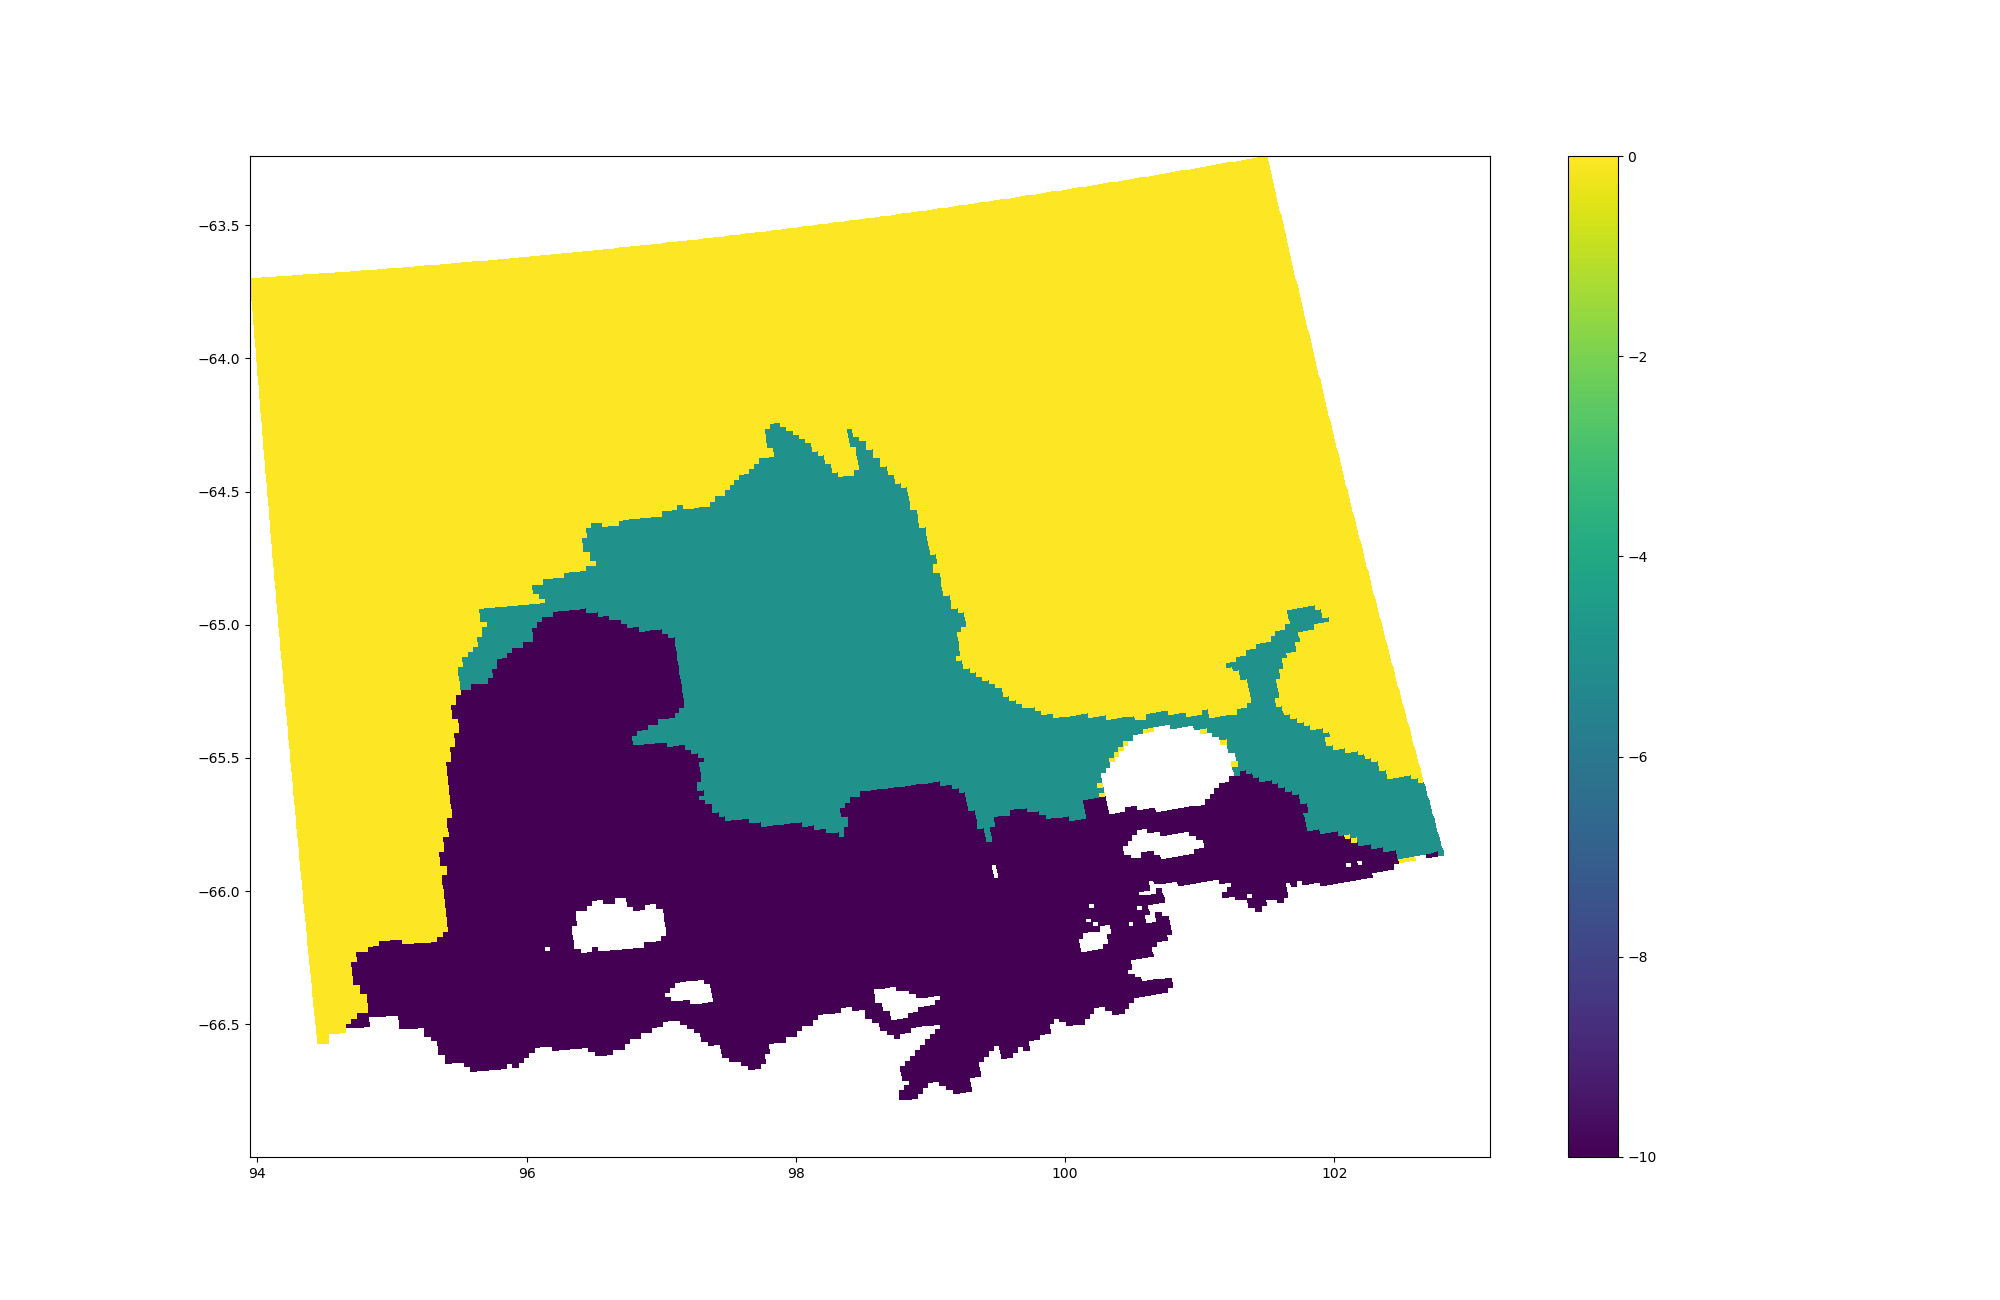

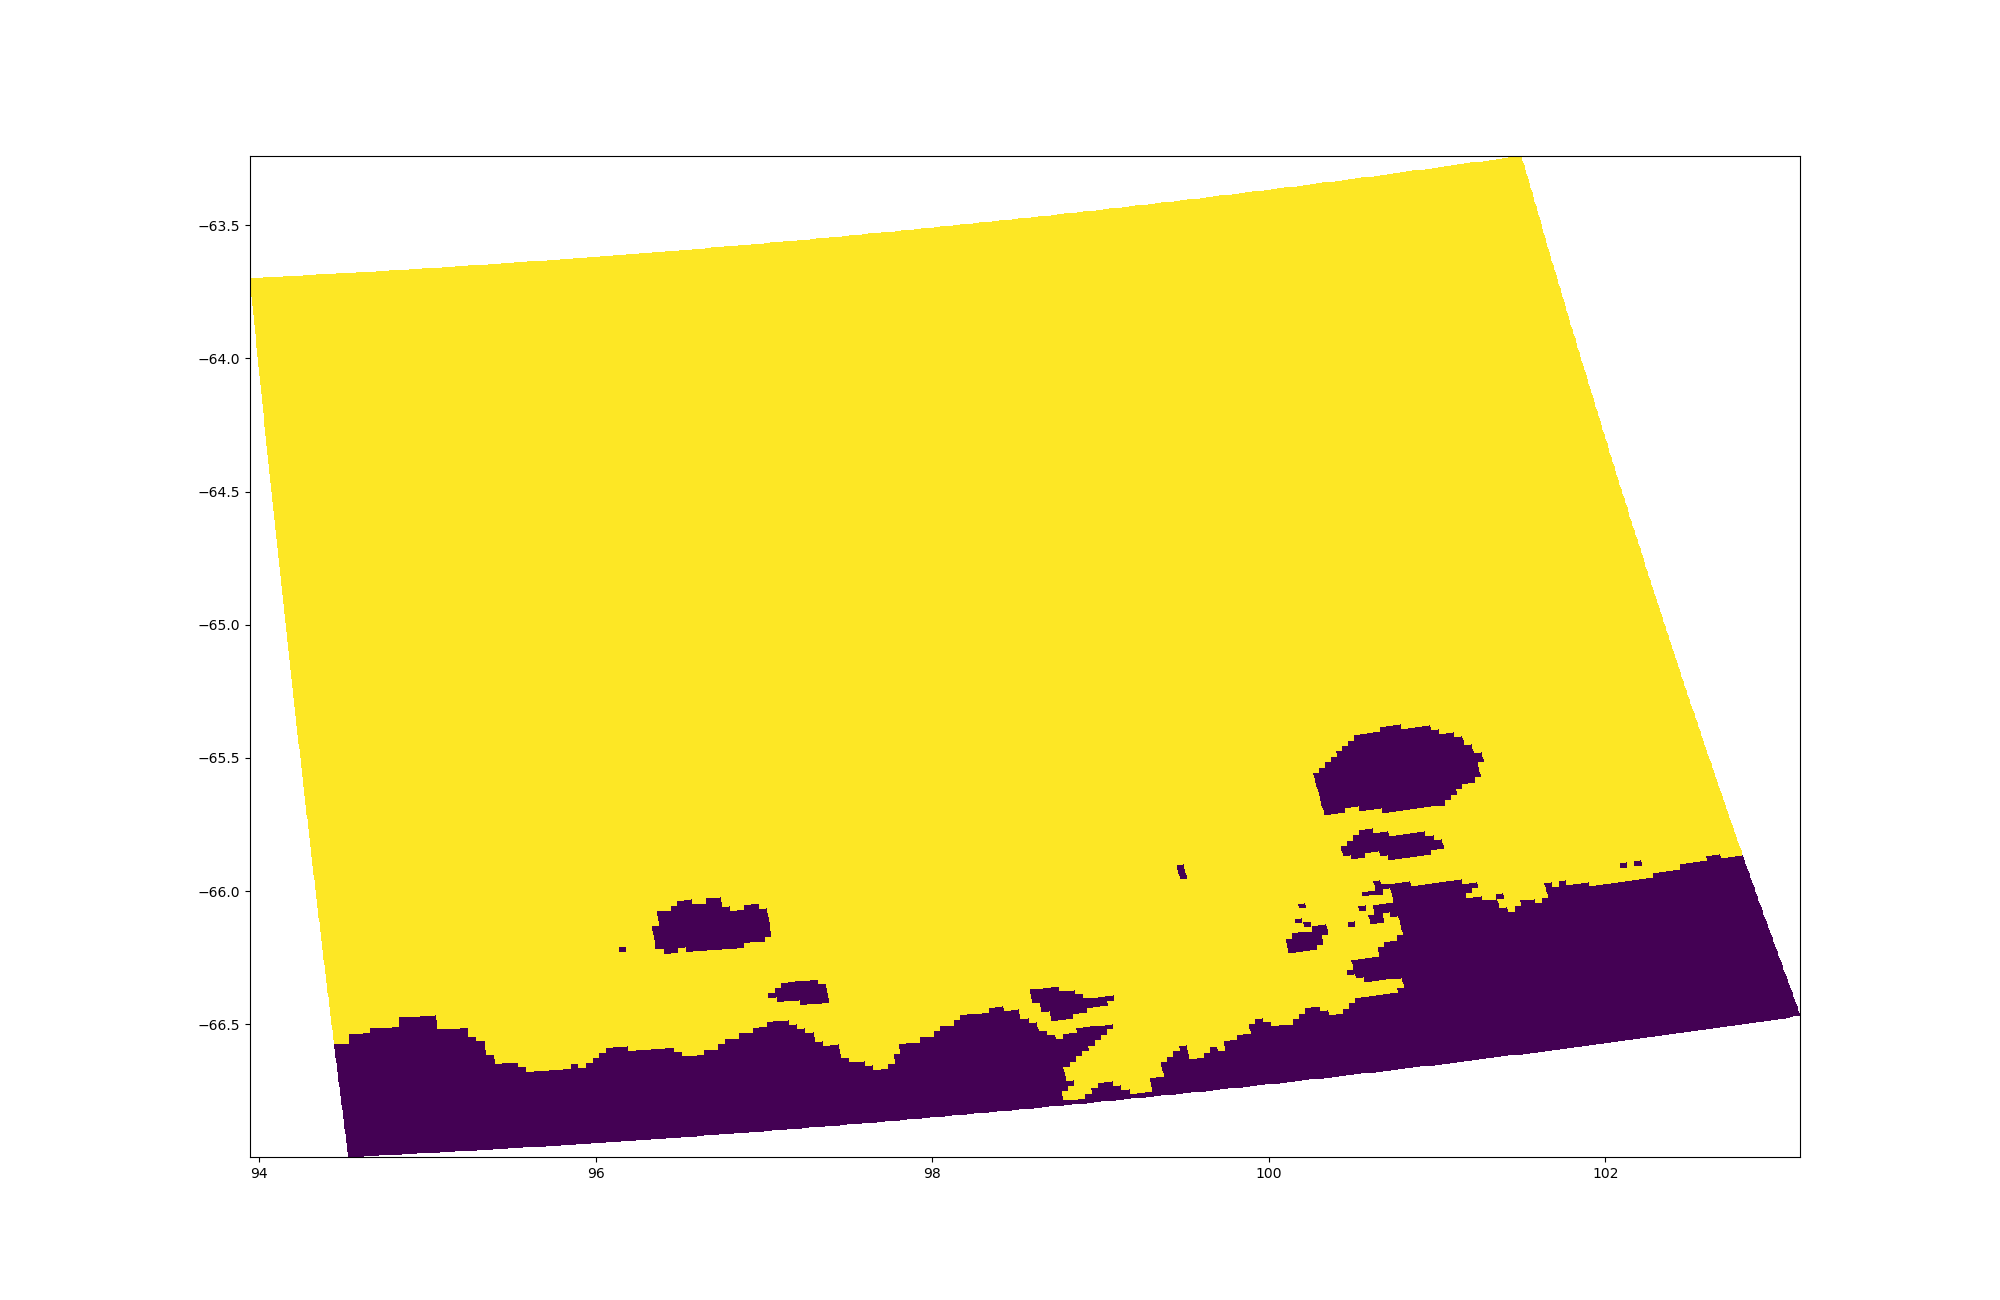

In [157]:
# for fast ice alter the zice.
fastice_draft = -5 #m below surface, negative downwards
zzz_test = zzz.copy()
mmm_test = mmm.copy()
zzz_test[(fi_mean_annual_i==1) & (zzz==0) & (mmm==1)] = fastice_draft
hhh_test = hhh.copy()

# also add any missing fast ice fill
zzz_test[(mask_fasticefill==1) & (zzz==0) & (mmm==1)] = fastice_draft


# # for icebergs, assume fully grounded.
# zzz_test[mask_icebergs==1] = min_depth-hhh_test[mask_icebergs] # set ice to be min depth above bathy,
# mmm_test[mask_icebergs==1] = 0                                  # and remove from water, i.e. grounded.

mmmNaN = mmm.copy().astype('float')
mmmNaN[mmmNaN == 0] = np.NaN

fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,zzz_test*mmmNaN,vmin=-10,vmax=0)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,mmm_test)
plt.show()

In [158]:
# update with new fastice and iceberg geometry

zzz = zzz_test.copy()
mmm = mmm_test.copy()
hhh = hhh_test.copy()

  
Minimum r-value =  0.0
Maximum r-value =  0.45924484729766846
Mean    r-value =  0.020859790863358908
Median  r-value =  0.014554122928529978
  
Minimum r-value =  0.0
Maximum r-value =  69.18661876485643
Mean    r-value =  4.556382988738637
Median  r-value =  2.6517951408101443


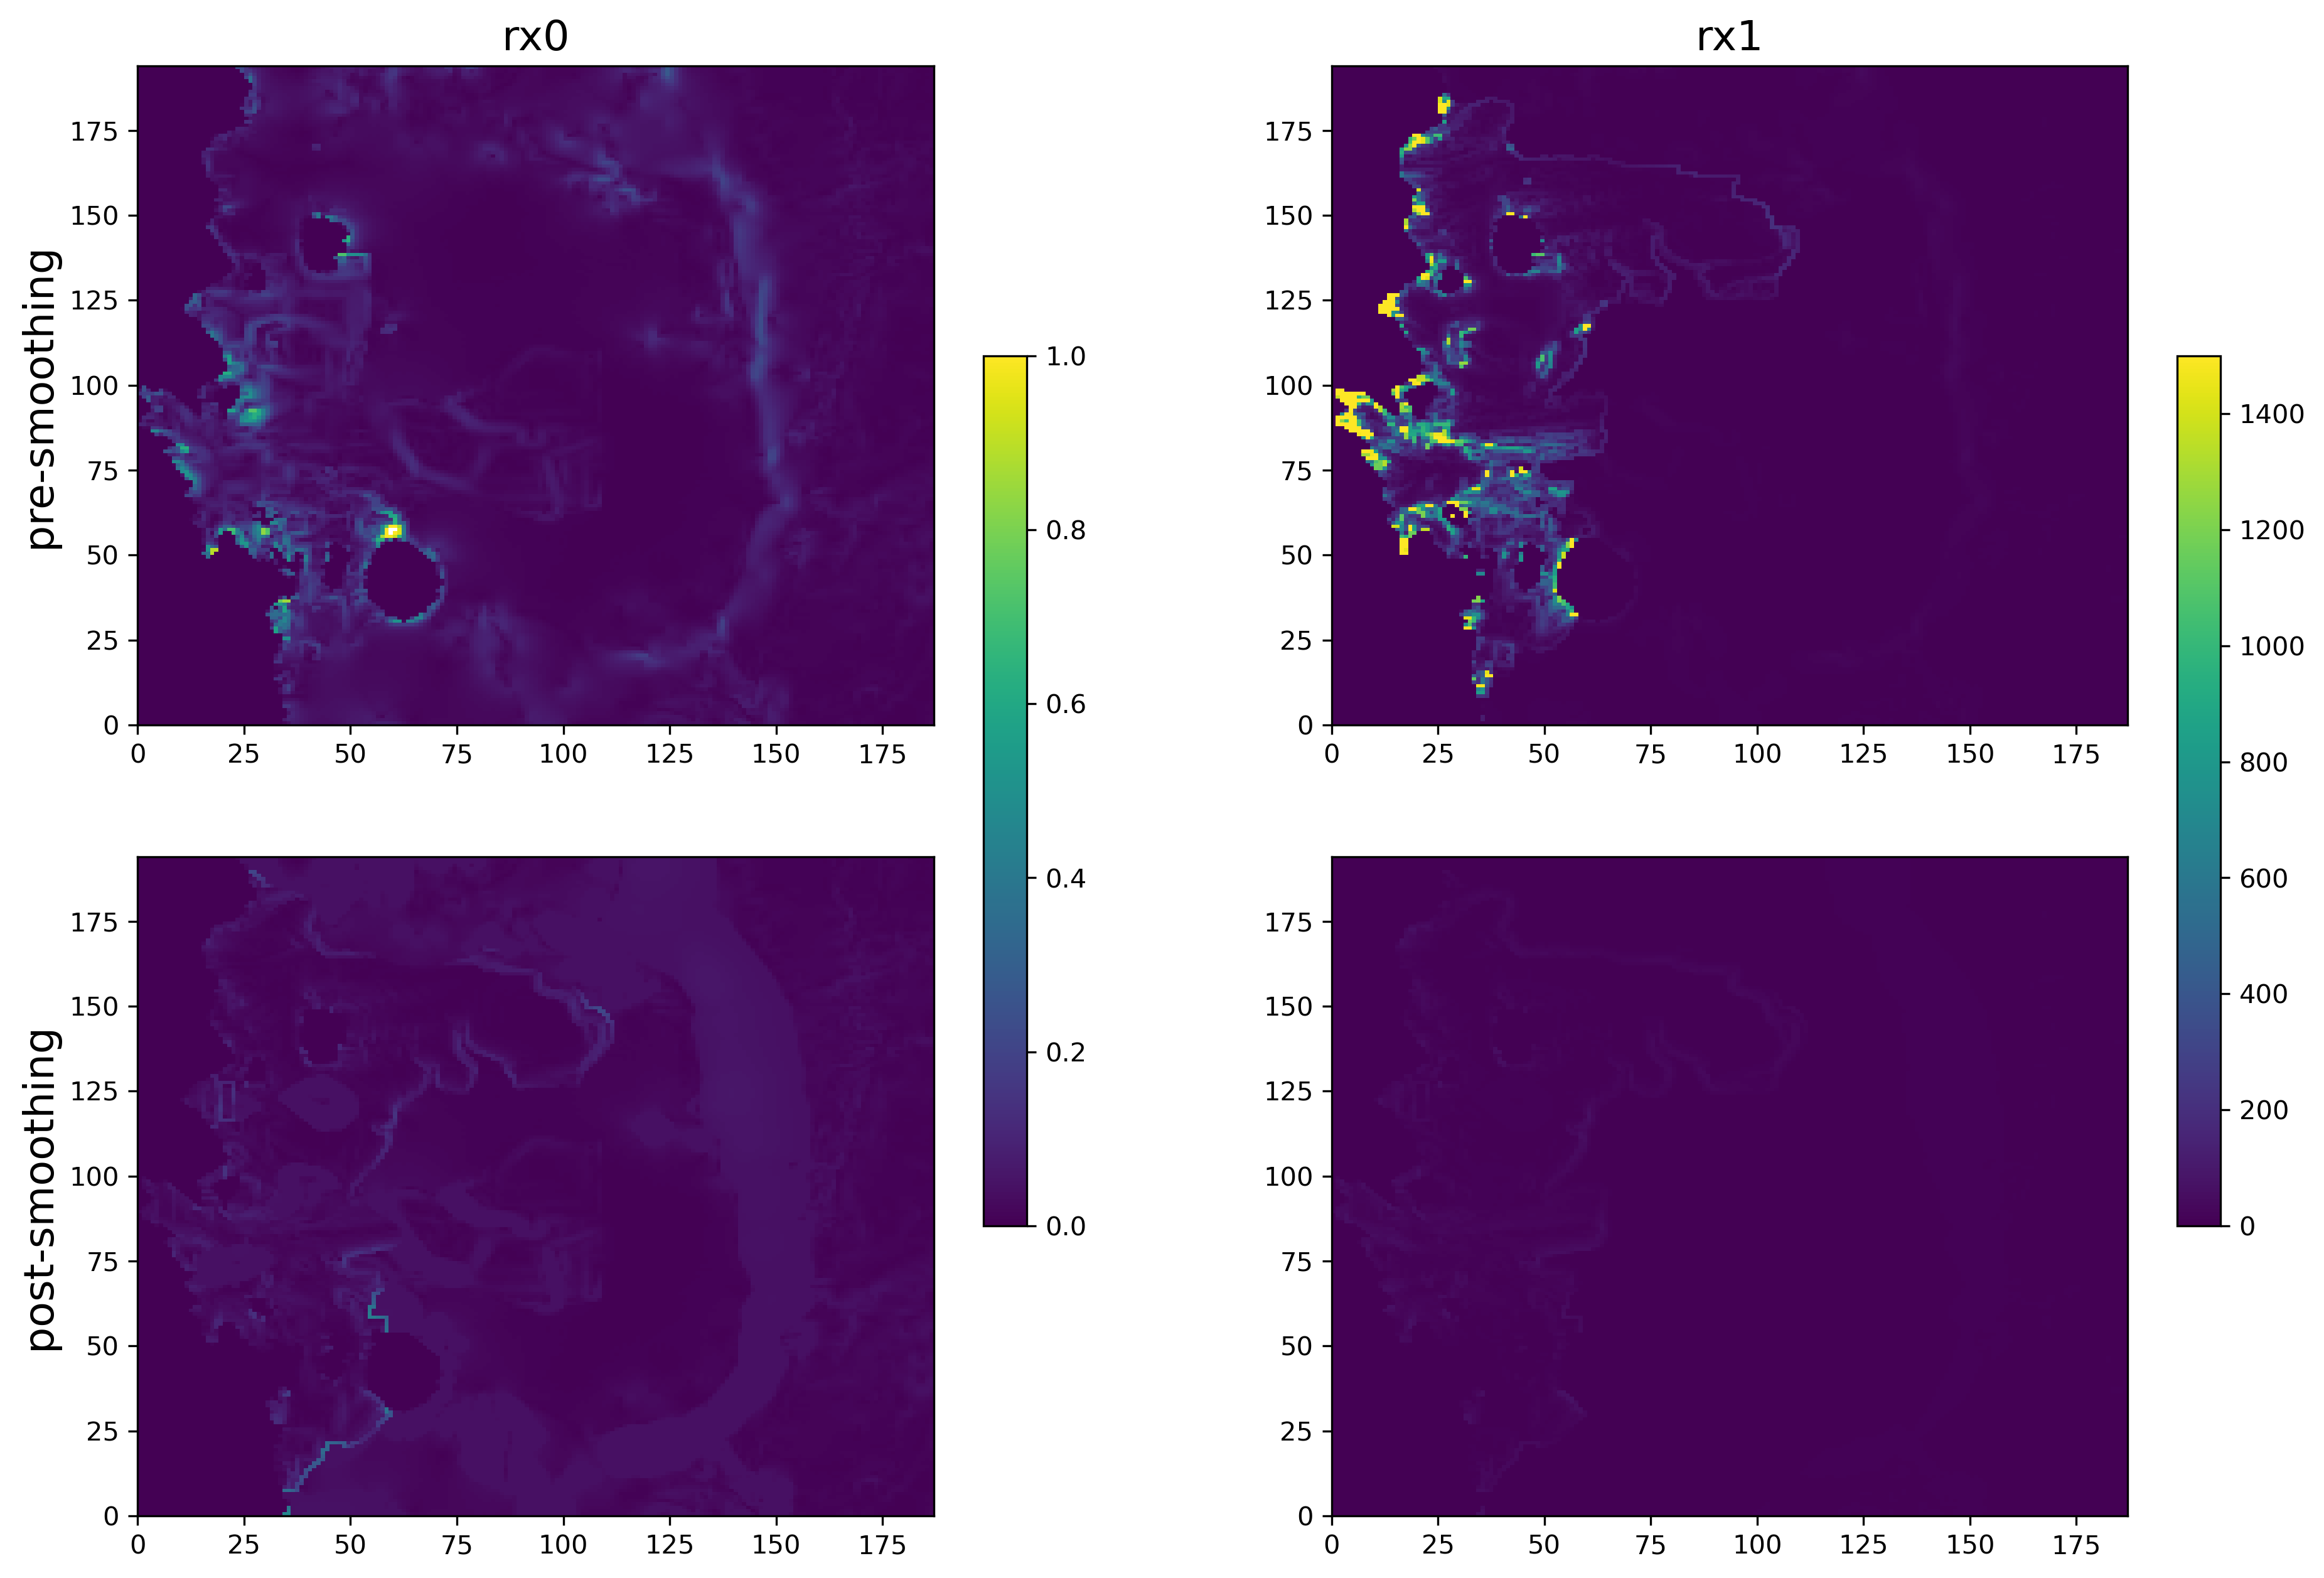

In [159]:
%matplotlib inline


z_rho_postManualEdits,z_w_postManualEdits,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline+50,hc+50,N,hhh,zzz)
grd_rx0_postManualEdits=GridStiffness.rx0(hhh,mmm)
grd_rx1_postManualEdits=GridStiffness.rx1(z_w_postManualEdits,mmm)


plt.close('all')
fig,axs = plt.subplots(2,2,figsize=[15,10],dpi=300)

ax = axs[0,0]
ax.pcolormesh(grd_rx0_pre,vmax=1)
ax.set_title('rx0',fontsize=16)
ax.set_ylabel('pre-smoothing',fontsize=16)
ax = axs[0,1]
grd_rx1_pre[np.isnan(grd_rx1_pre)]=0
ax.pcolormesh(grd_rx1_pre,vmax=1500)
ax.set_title('rx1',fontsize=16)
ax = axs[1,0]
im=ax.pcolormesh(grd_rx0_postManualEdits,vmax=1)
plt.colorbar(im,ax=axs[:,0],shrink=0.6)
ax.set_ylabel('post-smoothing',fontsize=16)
ax = axs[1,1]
im=ax.pcolormesh(grd_rx1_postManualEdits,vmax=1500)
plt.colorbar(im,ax=axs[:,1],shrink=0.6)

plt.savefig('../out/pre_post_rxVals.png')

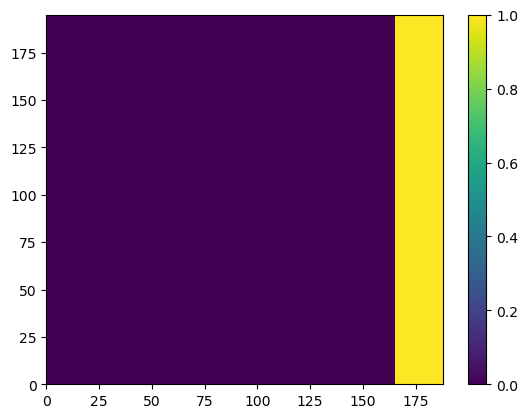

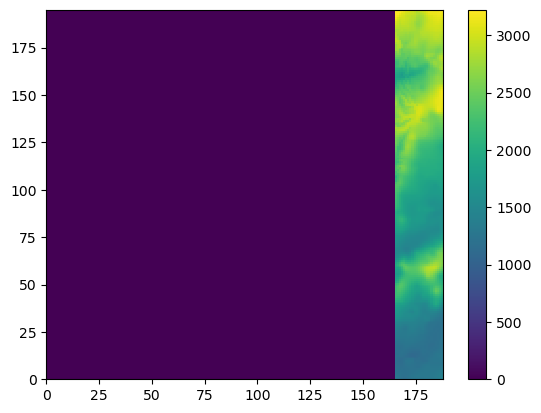

Old Max Roughness value is:  0.04000004753470421


DeltaBathymetry =  -10780.71875
New Max Roughness value is:  0.030000053346157074


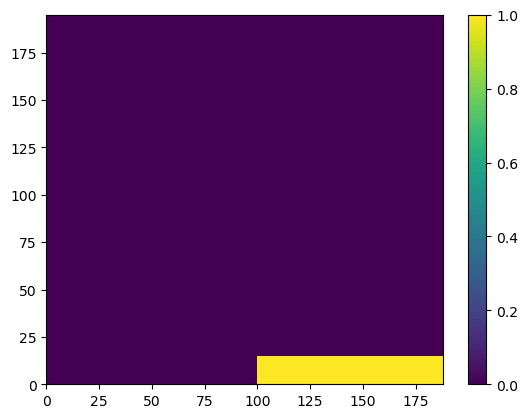

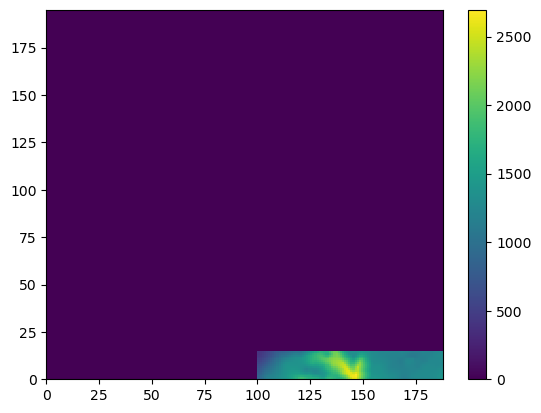

Old Max Roughness value is:  0.041647765785455704


DeltaBathymetry =  62519.935546875
New Max Roughness value is:  0.025092734023928642


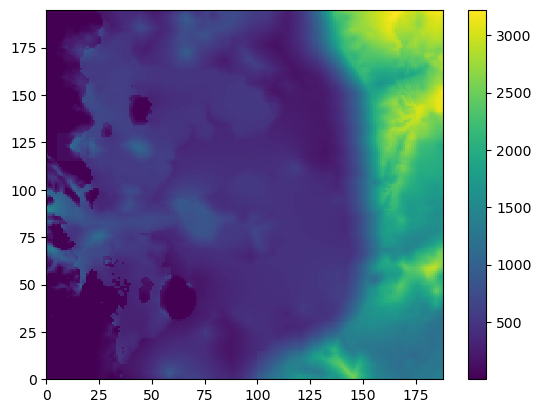

In [169]:
# border grid modifications

# do some smoothing of the deep bathy on east bnd
mask_eastbnd = np.zeros_like(hhh)
mask_eastbnd[:,165:]=True

plt.pcolormesh(mask_eastbnd)
plt.colorbar()
plt.show()
plt.pcolormesh(mask_eastbnd*hhh)
plt.colorbar()
plt.show()

# smooth the wct
rx0in = 0.03
max_iter = 100
Area = 1/(pm*pn)
hhh_tmp = hhh.copy()
hhh_tmp, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask_eastbnd,hhh_tmp,rx0in,Area,max_iter)


# do some replication of the southern boundary
for ii in range(1,5):
    hhh_tmp[ii,110:] = hhh_tmp[0,110:]



# now do some smoothing of the deep bathy on south bnd
mask_southbnd = np.zeros_like(hhh)
mask_southbnd[:15,100:]=True

plt.pcolormesh(mask_southbnd)
plt.colorbar()
plt.show()
plt.pcolormesh(mask_southbnd*hhh)
plt.colorbar()
plt.show()

# smooth the wct
rx0in = 0.025
max_iter = 100
Area = 1/(pm*pn)
hhh_tmp = hhh.copy()
hhh_tmp, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask_southbnd,hhh_tmp,rx0in,Area,max_iter)




plt.pcolormesh(hhh_tmp)
plt.colorbar()
plt.show()


In [170]:
# calculate final rx0 and rx1 values, check that you're happy before overwriting these
z_rho_final,z_w_final,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_final=GridStiffness.rx0(hhh,mmm)

grd_rx1_final=GridStiffness.rx1(z_w_final,mmm)

maskNaN = mmm.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',zzz.min(),'/',zzz.max())
print('min/max h is',hhh.min(),'/',hhh.max())
print('min/max wct is',(hhh+zzz).min(),'/',(hhh+zzz).max())
print('ocean cells')
print('min/max zice is',np.nanmin(zzz*maskNaN),'/',np.nanmax(zzz*maskNaN))
print('min/max h is',np.nanmin(hhh*maskNaN),'/',np.nanmax(hhh*maskNaN))
print('min/max wct is',np.nanmin((hhh+zzz)*maskNaN),'/',np.nanmax((hhh+zzz)*maskNaN))


  
Minimum r-value =  0.0
Maximum r-value =  0.45924484729766846
Mean    r-value =  0.020859790863358908
Median  r-value =  0.014554122928529978
  
Minimum r-value =  0.0
Maximum r-value =  92.90369595422295
Mean    r-value =  5.649254854426338
Median  r-value =  2.977218555428755
whole domain
min/max zice is -1582.0773 / 49.7
min/max h is 0.3 / 3222.336
min/max wct is 50.0 / 3222.336
ocean cells
min/max zice is -1104.0343017578125 / -0.0
min/max h is 110.81787109375 / 3222.3359375
min/max wct is 105.81787109375 / 3222.3359375


In [171]:
# Make final versions
hhh_final = hhh.copy()
zzz_final = zzz.copy()
mmm_final = mmm.copy()

# now re-check that min_depth is obeyed for all ocean points
ii = ((hhh_final + zzz_final) < min_depth) & (mmm == 1)
hhh_final[ii] = -zzz_final[ii] + min_depth

# do the same for all non-ocean points
ii = ((hhh_final + zzz_final) < min_depth) & (mmm == 0)
zzz_final[ii] = min_depth-hhh_final[ii] # for those locations, the depth needs to be min_depth above the bathy

# remove any zice that is >0.
zzz_final_backup = zzz_final.copy()

anyPosZice=np.any(zzz_final>0)

if anyPosZice:
    new_ice = zzz_final.copy()
    new_ice[(zzz_final>0)]=0
    zzz_final=new_ice.copy()

In [172]:
maskNaN = mmm.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',zzz_final.min(),'/',zzz_final.max())
print('min/max h is',hhh_final.min(),'/',hhh_final.max())
print('min/max wct is',(hhh_final+zzz_final).min(),'/',(hhh_final+zzz_final).max())
print('ocean cells')
print('min/max zice is',np.nanmin(zzz_final*maskNaN),'/',np.nanmax(zzz_final*maskNaN))
print('min/max h is',np.nanmin(hhh_final*maskNaN),'/',np.nanmax(hhh_final*maskNaN))
print('min/max wct is',np.nanmin((hhh_final+zzz_final)*maskNaN),'/',np.nanmax((hhh_final+zzz_final)*maskNaN))

whole domain
min/max zice is -1582.0773 / -0.0
min/max h is 0.3 / 3222.336
min/max wct is 0.3 / 3222.336
ocean cells
min/max zice is -1104.0343017578125 / -0.0
min/max h is 110.81787109375 / 3222.3359375
min/max wct is 105.81787109375 / 3222.3359375


In [173]:
# if this is set as 'True', then overwrite the bed, ice and mask with updated values.

handAdjustments=True
if handAdjustments:
    print('updating bathy, zice and mask')
    roms_tmp['bed_backup'] = roms_tmp['bed'].copy()
    roms_tmp['ice_backup'] = roms_tmp['ice'].copy()
    roms_tmp['mask_backup'] = roms_tmp['mask'].copy()
    roms_tmp['bed']=hhh_final.copy()
    roms_tmp['ice']=zzz_final.copy()
    roms_tmp['mask']=mmm_final.copy()
    
    bed = hhh_final.copy()
    ice = zzz_final.copy()
    mask = mmm_final.copy()


updating bathy, zice and mask


In [174]:
# do checks

maskNaN = mask.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(bed+ice).min(),'/',(bed+ice).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin((bed+ice)*maskNaN),'/',np.nanmax((bed+ice)*maskNaN))

whole domain
min/max zice is -1582.0773 / -0.0
min/max h is 0.3 / 3222.336
min/max wct is 0.3 / 3222.336
ocean cells
min/max zice is -1104.0343017578125 / -0.0
min/max h is 110.81787109375 / 3222.3359375
min/max wct is 105.81787109375 / 3222.3359375


In [177]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL with ROMS requiring a 0.85 tolerance: ', 0.85*np.nanmin(CFL))
print('max slow DT in s following CFL: ', 0.85*np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',0.85*np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/(0.85*np.nanmin(CFL))).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))



max fast DT in s following CFL with ROMS requiring a 0.85 tolerance:  9.268890666961669
max slow DT in s following CFL:  205.99548136775678
Set ROMS timestep settings of at least: 
 DT < 205.99548136775678 s 
 NDTFAST > 26.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  8.816049465795384
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.8816049465795384


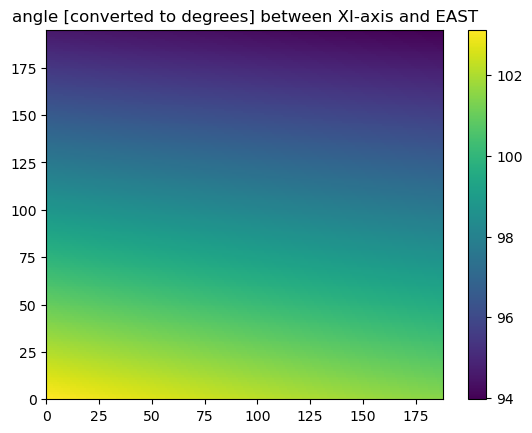

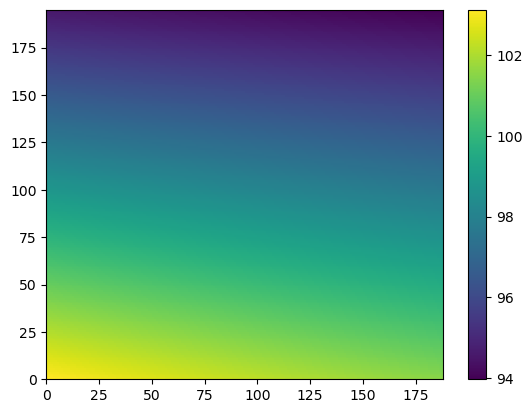

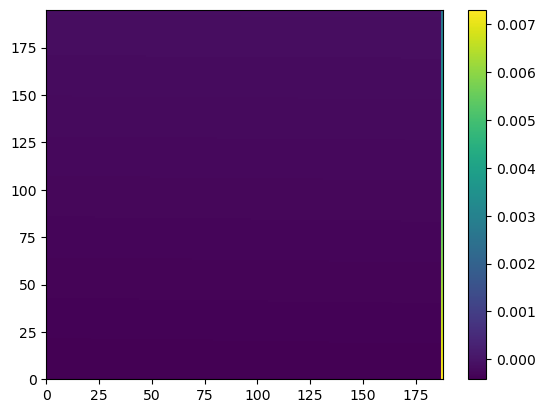

In [178]:
# Calculate the grid angle. !Important!

Angle_method = 'powell'

if Angle_method=='ole':
    angle = lon_rho/180.0*np.pi
    # ^^ only works for the polar stereographic grid of the Ole style WAOM model.
    # and note there is a slight error of a few fractions of a degree.
elif Angle_method == 'charles':
    # From Charles James GridBuilder:
    # note that the approximations within this method don't work so well
    # close to the poles. So best used near the low latitudes

    _,dxdxi = np.gradient(lon_rho)
    _,dydxi = np.gradient(lat_rho)

    angle = np.arctan2(dydxi,dxdxi)

elif Angle_method == 'powell':
    ### method from Brian Powell group

    def _distq(lon1, lat1, lon2, lat2):
        """
        Compute the geodesic distance between lat/lon points. This code is
        taken from the dist.f routine and the Matlab version distg.m passed
        around WHOI and APL. This was stripped down to use the WGS84 ellipsoid.

        Parameters
        ----------
        lon1 : array_like or scalar
            Input array of source longitude(s)
        lat1 : array_like or scalar
            Input array of source latitude(s)
        lon2 : array_like or scalar
            Input array of destination longitude(s)
        lat2 : array_like or scalar
            Input array of destination latitude(s)

        Returns
        -------
        distance : array or scalar of distance in meters
        angle: array or scalar of angle in radians

        """
        lon1 = np.asanyarray(np.radians(lon1))
        lat1 = np.asanyarray(np.radians(lat1))
        lon2 = np.asanyarray(np.radians(lon2))
        lat2 = np.asanyarray(np.radians(lat2))

        # # If one of the points is a singleton and the other is an
        # array, make them the same size
        if lon1.size == 1 and lon2.size > 1:
            lon1 = lon1.repeat(lon2.size)
            lat1 = lat1.repeat(lat2.size)
        if lon2.size == 1 and lon1.size > 1:
            lon2 = lon2.repeat(lon1.size)
            lat2 = lat2.repeat(lat1.size)

        # Set the WGS84 parameters
        A = 6378137.
        E = 0.081819191
        B = np.sqrt(A * A - (A * E)**2)
        EPS = E * E / (1.0 - E * E)

        # Move any latitudes off of the equator
        lat1[lat1 == 0] = np.finfo(float).eps
        lat2[lat2 == 0] = -np.finfo(float).eps

        # COMPUTE THE RADIUS OF CURVATURE IN THE PRIME VERTICAL FOR EACH POINT
        xnu1 = A / np.sqrt(1.0 - (E * np.sin(lat1))**2)
        xnu2 = A / np.sqrt(1.0 - (E * np.sin(lat2))**2)

        TPSI2 = (1.0 - E * E) * np.tan(lat2) + E * E * xnu1 * np.sin(lat1) / \
            (xnu2 * np.cos(lat2))
        PSI2 = np.arctan(TPSI2)

        DPHI2 = lat2 - PSI2
        DLAM = (lon2 - lon1) + np.finfo(float).eps
        CTA12 = np.sin(DLAM) / (np.cos(lat1) * TPSI2 - np.sin(lat1) * np.cos(DLAM))
        A12 = np.arctan(CTA12)
        CTA21P = np.sin(DLAM) / (np.sin(PSI2) * np.cos(DLAM) -
                                np.cos(PSI2) * np.tan(lat1))
        A21P = np.arctan(CTA21P)

        # C    GET THE QUADRANT RIGHT
        DLAM2 = (np.abs(DLAM) < np.pi).astype(int) * DLAM + \
            (DLAM >= np.pi).astype(int) * (-2 * np.pi + DLAM) + \
            (DLAM <= -np.pi).astype(int) * (2 * np.pi + DLAM)
        A12 = A12 + (A12 < -np.pi).astype(int) * 2 * np.pi - \
            (A12 >= np.pi).astype(int) * 2 * np.pi
        A12 = A12 + np.pi * np.sign(-A12) * \
            (np.sign(A12).astype(int) != np.sign(DLAM2))
        A21P = A21P + (A21P < -np.pi).astype(int) * 2 * np.pi - \
            (A21P >= np.pi).astype(int) * 2 * np.pi
        A21P = A21P + np.pi * np.sign(-A21P) * \
            (np.sign(A21P).astype(int) != np.sign(-DLAM2))

        SSIG = np.sin(DLAM) * np.cos(PSI2) / np.sin(A12)

        dd1 = np.array([np.cos(lon1) * np.cos(lat1),
                        np.sin(lon1) * np.cos(lat1), np.sin(lat1)])
        dd2 = np.array([np.cos(lon2) * np.cos(lat2),
                        np.sin(lon2) * np.cos(lat2), np.sin(lat2)])
        dd2 = np.sum((dd2 - dd1)**2, axis=0)
        bigbrnch = (dd2 > 2).astype(int)

        SIG = np.arcsin(SSIG) * (bigbrnch == 0).astype(int) + \
            (np.pi - np.arcsin(SSIG)) * bigbrnch

        SSIGC = -np.sin(DLAM) * np.cos(lat1) / np.sin(A21P)
        SIGC = np.arcsin(SSIGC)
        A21 = A21P - DPHI2 * np.sin(A21P) * np.tan(SIG / 2.0)

        # C   COMPUTE RANGE
        G2 = EPS * (np.sin(lat1))**2
        G = np.sqrt(G2)
        H2 = EPS * (np.cos(lat1) * np.cos(A12))**2
        H = np.sqrt(H2)
        SIG2 = SIG * SIG
        TERM1 = -H2 * (1.0 - H2) / 6.0
        TERM2 = G * H * (1.0 - 2.0 * H2) / 8.0
        TERM3 = (H2 * (4.0 - 7.0 * H2) - 3.0 * G2 * (1.0 - 7.0 * H2)) / 120.0
        TERM4 = -G * H / 48.0
        rng = xnu1 * SIG * (1.0 + SIG2 * (TERM1 + SIG * TERM2 + SIG2 * TERM3 +
                                        SIG2 * SIG * TERM4))

        return rng, A12


    def earth_angle(lon1, lat1, lon2, lat2):
        """
        Compute the angle between lat/lon points. NOTE: The bearing angle
        is computed, but then converted to geometric (counter-clockwise)
        angle to be returned.

        Parameters
        ----------
        lon1 : array_like or scalar
            Input array of source longitude(s)
        lat1 : array_like or scalar
            Input array of source latitude(s)
        lon2 : array_like or scalar
            Input array of destination longitude(s)
        lat2 : array_like or scalar
            Input array of destination latitude(s)

        Returns
        -------
        angle : array or scalar of bearing in radians

        """
        _, angle = _distq(lon1, lat1, lon2, lat2)
        return (np.pi / 2.0 - angle)


    # Calculate the angle between the points
    angle = np.zeros(lon_rho.shape)
    angle[:, :-1] = earth_angle(lon_rho[:, :-1],
                                        lat_rho[:, :-1], lon_rho[:, 1:], lat_rho[:, 1:])
    angle[:, -1] = angle[:, -2]
    angle[np.rad2deg(angle)>180] = angle[np.rad2deg(angle)>180] - np.deg2rad(360) # this last line was added
    # to make the angle variable stretch from -180 to 180, not -90 to 270.
    
    # i think this method is similar to that from the pyroms repo:
        # from  https://github.com/BobTorgerson/Pyroms/blob/master/pyroms/hgrid.py

                    # geod = pyproj.Geod(ellps=self.ellipse)
                    # az_forward, az_back, dx = geod.inv(self.lon[:,:-1], self.lat[:,:-1], \
                    #                                    self.lon[:,1:], self.lat[:,1:])

                    # angle = 0.5 * (az_forward[1:,:] + az_forward[:-1,:])
                    # self.angle_rho = (90 - angle) * np.pi/180.



plt.pcolormesh(np.rad2deg(angle))
plt.colorbar()
plt.title('angle [converted to degrees] between XI-axis and EAST')
plt.show()
plt.pcolormesh(np.rad2deg(lon_rho/180.0*np.pi))
plt.colorbar()
plt.show()
plt.pcolormesh(np.rad2deg(angle)-np.rad2deg(lon_rho/180.0*np.pi))
plt.colorbar()

In [179]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray('"T"',name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array(['"F"', '"T"'], dtype=str),
 'long_name': 'grid type logical switch'})

xl = np.maximum(dx[0,:].sum(), dx[-1,:].sum())
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = np.maximum(dy[:,0].sum(), dy[:,-1].sum())
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

# angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(bed,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})
# hraw_da = xr.DataArray(bed_raw.astype(float),name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working unmasked bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(ice,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})
# zice_raw_da = xr.DataArray(ice_raw.astype(float),name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'raw unmasked model ice draft at RHO-points', 'units': 'meter'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})

x_rho_da = xr.DataArray(x_rho,name='x_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'x-location of RHO-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_rho_da = xr.DataArray(y_rho,name='y_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'y-location of RHO-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_psi_da = xr.DataArray(x_psi,name='x_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'x-location of psi-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_psi_da = xr.DataArray(y_psi,name='y_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'y-location of psi-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_u_da = xr.DataArray(x_u,name='x_u',dims=['eta_u','xi_u'],attrs={'long_name': 'x-location of u-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_u_da = xr.DataArray(y_u,name='y_u',dims=['eta_u','xi_u'],attrs={'long_name': 'y-location of u-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_v_da = xr.DataArray(x_v,name='x_v',dims=['eta_v','xi_v'],attrs={'long_name': 'x-location of v-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_v_da = xr.DataArray(y_v,name='y_v',dims=['eta_v','xi_v'],attrs={'long_name': 'y-location of v-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})


mask_u,mask_v,mask_psi = uvp_masks(mask)

mask_rho_da = xr.DataArray(mask,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pm_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
              #   'hraw':hraw_da,
                'zice':zice_da,
              #   'zice_raw':zice_raw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'x_rho':x_rho_da,
                'y_rho':y_rho_da,
                'x_psi':x_psi_da,
                'y_psi':y_psi_da,
                'x_u':x_u_da,
                'y_u':y_u_da,
                'x_v':x_v_da,
                'y_v':y_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

In [180]:
print('saving to',out_path)
grd.to_netcdf(out_path,unlimited_dims='bath')

saving to /home/woden/Documents/shackleton-setup/data/proc/shac_2km_v2_grd.nc


Text(0, 0.5, 'ice draft [mbsl]')

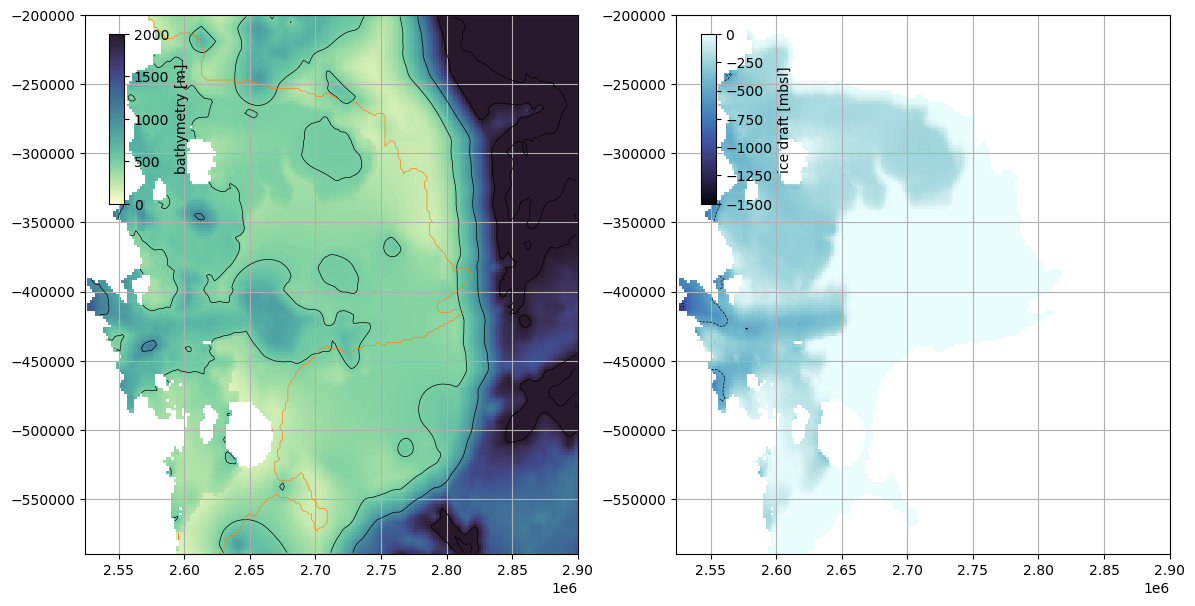

In [181]:
# plot of bathy and draft subset

nanMask = grd.mask_rho.where(grd.mask_rho!=0,np.NaN)
nanMaskZice = grd.mask_rho.where((grd.mask_rho!=0)&(grd.zice<0),np.NaN)

plt.close('all')
fig,axs=plt.subplots(ncols=2,figsize=(14,7))
im=axs[0].pcolormesh(grd.x_rho,grd.y_rho,(grd.h*nanMask),vmin=000,vmax=2000,cmap='cmo.deep')
axs[0].contour(grd.x_rho,grd.y_rho,(grd.h*nanMask),levels=[0,500,1000,2000,2500],colors='k',linewidths=0.5)
axs[0].contour(grd.x_rho,grd.y_rho,(grd.zice!=0 * nanMask),levels=[0,1],colors='C1',linewidths=0.5)

axs[0].grid()
# axs[0].set_aspect('equal','box')
# colorbar
cax = inset_axes(axs[0],
                 width="3%",  # width = 10% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.65, 1, .7),
                 bbox_transform=axs[0].transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('bathymetry [m]')

im=axs[1].pcolormesh(grd.x_rho,grd.y_rho,grd.zice*nanMask*nanMaskZice,vmin=-1500,vmax=000,cmap='cmo.ice')
axs[1].contour(grd.x_rho,grd.y_rho,grd.zice*nanMask*nanMaskZice,levels=[-1500,-1000,-500,0],colors='k',linewidths=0.5)

axs[1].grid()

cax = inset_axes(axs[1],
                 width="3%",  # width = 10% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.65, 1, .7),
                 bbox_transform=axs[1].transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('ice draft [mbsl]')
